<a href="https://colab.research.google.com/github/GAUTAMMANU/projminor/blob/main/code/modelling-Brazil-new2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Settings

In [ ]:
!git clone https://github.com/GAUTAMMANU/projminor.git
%cd projminor

Cloning into 'projminor'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 93 (delta 0), reused 0 (delta 0), pack-reused 89 (from 1)
Receiving objects: 100% (93/93), 82.12 MiB | 9.68 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Updating files: 100% (103/103), done.
/content/projminor


In [92]:
# %cd code
# insert your desired path to work on
import os
from os.path import join
project_path = os.path.dirname(os.getcwd())
# os.chdir(join('..','data'))
os.getcwd()

'E:\\minor\\proj\\code'

Run the following section one time per session. This cell links the code folder to the python exectution path.

In [93]:
import sys
sys.path.append(join(project_path, 'code'))

The following cell allows Jupyter Notebooks to detect changes in external code and to automatically update it without restarting the runtime.

In [94]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Plots settings.

In [95]:
import matplotlib
font = {'family':'Arial', 'size':'15', 'weight':'normal'}

matplotlib.rc('font', **font)

Set folder structure.

In [96]:
config = {
    'main_brazil': 'Brazil',
    'main_peru': 'Peru',
    'baseline': join(project_path, "baseline_models"),
    'output': join(project_path, "code", "saved_models"),
    'metrics': join(project_path, "code", "metrics")
}
project_path

# List comprehension for the folder structure code
[os.makedirs(val, exist_ok=True) for key, val in config.items()]

[None, None, None, None, None]

# **AI4Dengue forecasting**
![](https://drive.google.com/uc?export=view&id=1J5Bt5Cks-e2IV-dEJLHJkuwXFJNFAZgr)

In [97]:
import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from glob import glob
from config import DEP_NAMES, GROUPED_VARS, DATA_REDUCER_SETTINGS, DATA_PROCESSING_SETTINGS


# Data

## Load the dataframe
**This dataframe comprises all the variables (climatic, epidemiological etc.) acquired for each Department during a defined number of years.**

In [98]:
dataframe = pd.read_csv(join('dataset', "Brazil_UF_dengue_monthly.csv"))
dataframe.head()
dataframe.iloc[1000]

Date                2004-02-01
Year                      2004
Month                        2
CD_UF                       12
area_km2            164173.431
                       ...    
rdpc_def_vulner         119.68
t_analf_18m              17.79
t_formal_18m             46.45
t_fundc_ocup18m           55.2
t_medioc_ocup18m         39.61
Name: 1000, Length: 62, dtype: object

**Load CNN results as columns to dataframe.**

In [99]:
cnn = pd.read_csv(join('saved_models', "cnn_dataframe.csv")).drop('Unnamed: 0', axis=1)
cnn['CD_UF'] = cnn['CD_UF'].astype(np.int64)

assert dataframe.shape[0] == cnn.shape[0]
assert all(dataframe['CD_UF'].unique() == cnn['CD_UF'].unique())
cnn

,CD_UF,CNN_all,CNN_0-19
0,11,1.000000,1.000000
1,11,1.000000,1.000000
2,11,1.000000,1.000000
3,11,1.000000,1.000000
4,11,32.159859,17.186546
...,...,...,...
6151,53,29.022461,16.795465
6152,53,20.277210,5.658783
6153,53,7.219064,16.862005
6154,53,17.866333,28.619926


In [100]:
dataframe.sort_values(['CD_UF', 'Date'], inplace=True, ignore_index=True)
dataframe

,Date,Year,Month,CD_UF,area_km2,NDVI_d,dewpoint_temperature_2m_d,humidity_d,max_temperature_2m_d,min_temperature_2m_d,...,pea10a14,pea15a17,pea18m,t_eletrica,t_densidadem2,rdpc_def_vulner,t_analf_18m,t_formal_18m,t_fundc_ocup18m,t_medioc_ocup18m
0,2001-01-01,2001,1,11,237765.347,0.154301,295.674980,88.460308,303.987216,294.155015,...,18698,34904,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93
1,2001-02-01,2001,2,11,237765.347,0.216873,295.944060,88.856948,304.738755,294.332566,...,18698,34904,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93
2,2001-03-01,2001,3,11,237765.347,0.239112,296.092747,89.305463,304.620829,294.304126,...,18698,34904,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93
3,2001-04-01,2001,4,11,237765.347,0.334660,296.186143,88.590375,304.168669,293.921815,...,18698,34904,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93
4,2001-05-01,2001,5,11,237765.347,0.378931,295.562972,86.939606,303.903043,293.395959,...,18698,34904,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6151,2019-08-01,2019,8,53,5760.784,0.362744,282.150351,42.202163,304.210083,287.271135,...,10706,36652,1361053,99.91,23.48,171.62,3.66,71.62,76.39,61.00
6152,2019-09-01,2019,9,53,5760.784,0.317748,281.820936,34.023500,307.566780,290.719267,...,10706,36652,1361053,99.91,23.48,171.62,3.66,71.62,76.39,61.00
6153,2019-10-01,2019,10,53,5760.784,0.271795,286.196146,45.486547,307.716003,291.720099,...,10706,36652,1361053,99.91,23.48,171.62,3.66,71.62,76.39,61.00
6154,2019-11-01,2019,11,53,5760.784,0.235493,290.445969,64.916154,306.706715,291.496597,...,10706,36652,1361053,99.91,23.48,171.62,3.66,71.62,76.39,61.00


In [101]:
dataframe = pd.concat([dataframe, cnn[['CNN_all', 'CNN_0-19']]], axis=1)
dataframe

,Date,Year,Month,CD_UF,area_km2,NDVI_d,dewpoint_temperature_2m_d,humidity_d,max_temperature_2m_d,min_temperature_2m_d,...,pea18m,t_eletrica,t_densidadem2,rdpc_def_vulner,t_analf_18m,t_formal_18m,t_fundc_ocup18m,t_medioc_ocup18m,CNN_all,CNN_0-19
0,2001-01-01,2001,1,11,237765.347,0.154301,295.674980,88.460308,303.987216,294.155015,...,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93,1.000000,1.000000
1,2001-02-01,2001,2,11,237765.347,0.216873,295.944060,88.856948,304.738755,294.332566,...,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93,1.000000,1.000000
2,2001-03-01,2001,3,11,237765.347,0.239112,296.092747,89.305463,304.620829,294.304126,...,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93,1.000000,1.000000
3,2001-04-01,2001,4,11,237765.347,0.334660,296.186143,88.590375,304.168669,293.921815,...,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93,1.000000,1.000000
4,2001-05-01,2001,5,11,237765.347,0.378931,295.562972,86.939606,303.903043,293.395959,...,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93,32.159859,17.186546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6151,2019-08-01,2019,8,53,5760.784,0.362744,282.150351,42.202163,304.210083,287.271135,...,1361053,99.91,23.48,171.62,3.66,71.62,76.39,61.00,29.022461,16.795465
6152,2019-09-01,2019,9,53,5760.784,0.317748,281.820936,34.023500,307.566780,290.719267,...,1361053,99.91,23.48,171.62,3.66,71.62,76.39,61.00,20.277210,5.658783
6153,2019-10-01,2019,10,53,5760.784,0.271795,286.196146,45.486547,307.716003,291.720099,...,1361053,99.91,23.48,171.62,3.66,71.62,76.39,61.00,7.219064,16.862005
6154,2019-11-01,2019,11,53,5760.784,0.235493,290.445969,64.916154,306.706715,291.496597,...,1361053,99.91,23.48,171.62,3.66,71.62,76.39,61.00,17.866333,28.619926


**'Clean' the dataset (e.g. remove NaN values)**

In [102]:
dataframe = utils.clean(dataframe)
dataframe.head()

,Date,Year,Month,CD_UF,area_km2,NDVI_d,dewpoint_temperature_2m_d,humidity_d,max_temperature_2m_d,min_temperature_2m_d,...,t_densidadem2,rdpc_def_vulner,t_analf_18m,t_formal_18m,t_fundc_ocup18m,t_medioc_ocup18m,CNN_all,CNN_0-19,rate_total,rate_019
0,2001-01-01,2001,1,11,237765.347,0.154301,295.674980,88.460308,303.987216,294.155015,...,27.15,144.93,9.42,51.72,53.83,36.93,1.000000,1.000000,42.754490,29.124122
1,2001-02-01,2001,2,11,237765.347,0.216873,295.944060,88.856948,304.738755,294.332566,...,27.15,144.93,9.42,51.72,53.83,36.93,1.000000,1.000000,17.601025,11.718582
2,2001-03-01,2001,3,11,237765.347,0.239112,296.092747,89.305463,304.620829,294.304126,...,27.15,144.93,9.42,51.72,53.83,36.93,1.000000,1.000000,11.072645,6.376287
3,2001-04-01,2001,4,11,237765.347,0.334660,296.186143,88.590375,304.168669,293.921815,...,27.15,144.93,9.42,51.72,53.83,36.93,1.000000,1.000000,5.120298,3.791306
4,2001-05-01,2001,5,11,237765.347,0.378931,295.562972,86.939606,303.903043,293.395959,...,27.15,144.93,9.42,51.72,53.83,36.93,32.159859,17.186546,6.976406,4.652966


In [103]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6156 entries, 0 to 6155
Data columns (total 61 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       6156 non-null   object 
 1   Year                       6156 non-null   int64  
 2   Month                      6156 non-null   int64  
 3   CD_UF                      6156 non-null   int64  
 4   area_km2                   6156 non-null   float64
 5   NDVI_d                     6156 non-null   float64
 6   dewpoint_temperature_2m_d  6156 non-null   float64
 7   humidity_d                 6156 non-null   float64
 8   max_temperature_2m_d       6156 non-null   float64
 9   min_temperature_2m_d       6156 non-null   float64
 10  surface_pressure_d         6156 non-null   float64
 11  temperature_2m_d           6156 non-null   float64
 12  total_precipitation_d      6156 non-null   float64
 13  u_component_of_wind_10m_d  6156 non-null   float

In [104]:
dataframe.to_csv('out.csv',index=False)

## Apply Data Reduction
**Data reduction is applied to three macro groups in order to reduce the number of variables on which the AI framework will be trained. The variables belonging to each group are set with the *PCAgroups* dictionary. The groups are:**
1. ***CLIMATIC VARIABLES***,
2. ***GEO VARIABLES***,
3. ***SOCIO VARIABLES***

In [105]:
print('\033[1m PCA Excluded Variables \033[0m')
utils.plist(GROUPED_VARS['EXCLUDED'])

print('\033[1m Climatic variables \033[0m')
utils.plist(GROUPED_VARS['CLIMATIC VARIABLES'])

print('\033[1m Geo variables \033[0m')
utils.plist(GROUPED_VARS['GEO VARIABLES'])

print('\033[1m Socio variables \033[0m')
utils.plist(GROUPED_VARS['SOCIO VARIABLES'])

print('\033[1m Additional variables \033[0m')
utils.plist(GROUPED_VARS['AUXILIAR'])

print('\033[1m Dengue variables \033[0m')
utils.plist(GROUPED_VARS['DENGUE'])

 PCA Excluded Variables 
----- 1 t_fundc_ocup18m
----- 2 t_medioc_ocup18m
----- 3 PopTotal_Urban_UF
----- 4 PopTotal_Rural_UF
----- 5 total_precipitation_d
----- 6 surface_pressure_d
----- 7 area_km2
----- 8 humidity_d
----- 9 temperature_2m_d
----- 10 min_temperature_2m_d
----- 11 CNN_all
----- 12 CNN_0-19
 Climatic variables 
----- 1 dewpoint_temperature_2m_d
----- 2 max_temperature_2m_d
----- 3 u_component_of_wind_10m_d
----- 4 v_component_of_wind_10m_d
 Geo variables 
----- 1 NDVI_d
----- 2 max_elevation_d
----- 3 mean_elevation_d
----- 4 min_elevation_d
----- 5 stdDev_elevation_d
----- 6 variance_elevation_d
----- 7 Forest_Cover_Percent
----- 8 Urban_Cover_Percent
 Socio variables 
----- 1 Urban_Cover_Percent
----- 2 ivs
----- 3 ivs_infraestrutura_urbana
----- 4 ivs_capital_humano
----- 5 ivs_renda_e_trabalho
----- 6 t_sem_agua_esgoto
----- 7 t_sem_lixo
----- 8 t_vulner_mais1h
----- 9 t_analf_15m
----- 10 t_cdom_fundin
----- 11 t_p15a24_nada
----- 12 t_vulner
----- 13 t_desocup18m

**We selected two types of data reduction methods: PCA (Principal Component Analysis) and PLS (Principal Least Square). The second one is the default solution because it reduces the input data by considering also a second variable that in our case is the Dengue Incidence Rates.**

In [106]:
from data_reduction import pca_reducer, pls_reducer

**Extract climatic, geophysical and socio-economic variables from the dataframe**

In [107]:
X_climatic = dataframe[GROUPED_VARS['CLIMATIC VARIABLES']].values
X_geo = dataframe[GROUPED_VARS['GEO VARIABLES']].values
X_socio = dataframe[GROUPED_VARS['SOCIO VARIABLES']].values


**Extract Dengue variables from the dataframe, apply a root scaling and normalization**

In [108]:
y_dengue = dataframe[GROUPED_VARS['DENGUE']].values
scaler = MinMaxScaler()
y_dengue = scaler.fit_transform(y_dengue)

**Apply data reduction technique**

In [109]:
if DATA_REDUCER_SETTINGS['TYPE'] == 'PLS':
    climatic_vars_reduced = pls_reducer(
        X_climatic,
        y_dengue,
        DATA_REDUCER_SETTINGS['NUMBER OF COMPONENTS']['CLIMATIC VARIABLES'])

    geo_vars_reduced = pls_reducer(
        X_geo,
        y_dengue,
        DATA_REDUCER_SETTINGS['NUMBER OF COMPONENTS']['GEO VARIABLES'])

    socio_vars_reduced = pls_reducer(
        X_socio,
        y_dengue,
        DATA_REDUCER_SETTINGS['NUMBER OF COMPONENTS']['SOCIO VARIABLES'])
    print(socio_vars_reduced.shape    )
elif DATA_REDUCER_SETTINGS['TYPE'] == 'PCA':
    climatic_vars_reduced = pca_reducer(
        X_climatic,
        DATA_REDUCER_SETTINGS['NUMBER OF COMPONENTS']['CLIMATIC VARIABLES'])

    geo_vars_reduced = pca_reducer(
        X_geo,
        DATA_REDUCER_SETTINGS['NUMBER OF COMPONENTS']['GEO VARIABLES'])

    socio_vars_reduced = pca_reducer(
        X_socio,
        DATA_REDUCER_SETTINGS['NUMBER OF COMPONENTS']['SOCIO VARIABLES'])
else:
    print('No data reduction.')

(6156, 10)


## Order reduced data in a new dataframe


**Normalize remaining variables**

In [110]:
x_excluded = dataframe[GROUPED_VARS['EXCLUDED']].values
x_excluded = MinMaxScaler().fit_transform(x_excluded)

In [111]:
X_auxiliar = dataframe[GROUPED_VARS['AUXILIAR']].values
X_auxiliar = MinMaxScaler().fit_transform(X_auxiliar)

**Create a new database with the reduced, the auxiliar and Dengue variables**

In [112]:
independent = {'Year':dataframe.Year.values, 'dep_id':dataframe.CD_UF.values, 't_fundc_ocup18m':x_excluded[:, 0], 't_medioc_ocup18m':x_excluded[:, 1],
               'PopTotal_Urban_UF':x_excluded[:, 2], 'PopTotal_Rural_UF':x_excluded[:, 3], 'total_precipitation_d':x_excluded[:, 4],
               'surface_pressure_d':x_excluded[:, 5], 'area_km2':x_excluded[:, 6], 'humidity_d':x_excluded[:, 7], 'temperature_2m_d':x_excluded[:, 8],
               'min_temperature_2m_d':x_excluded[:, 9], 'CNN_all':x_excluded[:, 10], 'CNN_0-19':x_excluded[:, 11]}

auxiliar    = {'Month': X_auxiliar[:, 0],
               'cases20_99': X_auxiliar[:, 1], 'cases0_19': X_auxiliar[:, 2],
               'RandEffects1':  MinMaxScaler().fit_transform(np.reshape(dataframe.CD_UF.values*dataframe.Month.values, (dataframe.CD_UF.values.shape[0], 1)))[:,0],
               'RandEffects2':  MinMaxScaler().fit_transform(np.reshape(dataframe.CD_UF.values*dataframe.Year.values, (dataframe.CD_UF.values.shape[0], 1)))[:,0],
               'RandEffects3':  MinMaxScaler().fit_transform(np.reshape(dataframe.CD_UF.values*dataframe.Month.values*dataframe.Year.values, (dataframe.CD_UF.values.shape[0], 1)))[:,0]}

climatic    = {'PCA0-Climatic':climatic_vars_reduced[:,0], 'PCA1-Climatic':climatic_vars_reduced[:,1], 'PCA2-Climatic':climatic_vars_reduced[:,2],
               'PCA3-Climatic':climatic_vars_reduced[:,3]}

geo         = {'PCA0-Geo':geo_vars_reduced[:,0], 'PCA1-Geo':geo_vars_reduced[:,1], 'PCA2-Geo':geo_vars_reduced[:,2],
               'PCA3-Geo':geo_vars_reduced[:,3], 'PCA4-Geo':geo_vars_reduced[:,4], 'PCA5-Geo':geo_vars_reduced[:,5]}

socio       = {'PCA0-Socio':socio_vars_reduced[:,0], 'PCA1-Socio':socio_vars_reduced[:,1], 'PCA2-Socio':socio_vars_reduced[:,2],
               'PCA3-Socio':socio_vars_reduced[:,3], 'PCA4-Socio':socio_vars_reduced[:,4], 'PCA5-Socio':socio_vars_reduced[:,5]}

dengue      = {'DengRate_all': y_dengue[:,0], 'DengRate_019': y_dengue[:,1]}

columns     = {**independent, **auxiliar, **climatic, **geo, **socio, **dengue}

reduced_dataframe = pd.DataFrame(columns)
reduced_dataframe.head()
reduced_dataframe.columns

# reduced_dataframe

Index(['Year', 'dep_id', 't_fundc_ocup18m', 't_medioc_ocup18m',
       'PopTotal_Urban_UF', 'PopTotal_Rural_UF', 'total_precipitation_d',
       'surface_pressure_d', 'area_km2', 'humidity_d', 'temperature_2m_d',
       'min_temperature_2m_d', 'CNN_all', 'CNN_0-19', 'Month', 'cases20_99',
       'cases0_19', 'RandEffects1', 'RandEffects2', 'RandEffects3',
       'PCA0-Climatic', 'PCA1-Climatic', 'PCA2-Climatic', 'PCA3-Climatic',
       'PCA0-Geo', 'PCA1-Geo', 'PCA2-Geo', 'PCA3-Geo', 'PCA4-Geo', 'PCA5-Geo',
       'PCA0-Socio', 'PCA1-Socio', 'PCA2-Socio', 'PCA3-Socio', 'PCA4-Socio',
       'PCA5-Socio', 'DengRate_all', 'DengRate_019'],
      dtype='object')

In [113]:
reduced_dataframe=reduced_dataframe[reduced_dataframe['Year']>=2004]
reduced_dataframe.to_csv('reduced_2004_2019.csv', index=False)
reduced_dataframe.shape

(5184, 38)

In [114]:
# reduced_dataframe=pd.read_csv('reduced_2004_2019.csv')

## Create training and validation data
**First of all, the dataframe is divided in two sub-dataframes (training and validation) by using the variable *Year***

In [115]:
reduced_dataframe=pd.read_csv('../google trends/merged_dataset.csv')
print(reduced_dataframe.shape)
print(reduced_dataframe.columns)

(5184, 41)
Index(['Year', 'dep_id', 't_fundc_ocup18m', 't_medioc_ocup18m',
       'PopTotal_Urban_UF', 'PopTotal_Rural_UF', 'total_precipitation_d',
       'surface_pressure_d', 'area_km2', 'humidity_d', 'temperature_2m_d',
       'min_temperature_2m_d', 'CNN_all', 'CNN_0-19', 'Month', 'cases20_99',
       'cases0_19', 'RandEffects1', 'RandEffects2', 'RandEffects3',
       'PCA0-Climatic', 'PCA1-Climatic', 'PCA2-Climatic', 'PCA3-Climatic',
       'PCA0-Geo', 'PCA1-Geo', 'PCA2-Geo', 'PCA3-Geo', 'PCA4-Geo', 'PCA5-Geo',
       'PCA0-Socio', 'PCA1-Socio', 'PCA2-Socio', 'PCA3-Socio', 'PCA4-Socio',
       'PCA5-Socio', 'mosquito_interest', 'sintomas_dengue_interest',
       'dengue_interest', 'DengRate_all', 'DengRate_019'],
      dtype='object')


In [131]:
training_dataframe = reduced_dataframe[reduced_dataframe.Year <= 2017]
validation_dataframe = reduced_dataframe[reduced_dataframe.Year >= 2017]
print(len(training_dataframe),
len(validation_dataframe))
training_dataframe.head()
validation_dataframe.head()

4536 972


,Year,dep_id,t_fundc_ocup18m,t_medioc_ocup18m,PopTotal_Urban_UF,PopTotal_Rural_UF,total_precipitation_d,surface_pressure_d,area_km2,humidity_d,...,PCA1-Socio,PCA2-Socio,PCA3-Socio,PCA4-Socio,PCA5-Socio,mosquito_interest,sintomas_dengue_interest,dengue_interest,DengRate_all,DengRate_019
156,2017,11,0.206751,0.12853,0.020497,0.089637,0.470017,0.816201,0.149352,0.933080,...,0.096634,0.179967,0.325246,0.604686,0.076292,0.11,0.24,0.14,0.032628,0.031062
157,2017,11,0.206751,0.12853,0.020497,0.089637,0.455807,0.813839,0.149352,0.957511,...,0.096634,0.179967,0.325246,0.604686,0.076292,0.14,0.35,0.14,0.028203,0.036438
158,2017,11,0.206751,0.12853,0.020497,0.089637,0.409449,0.815870,0.149352,0.945000,...,0.096634,0.179967,0.325246,0.604686,0.076292,0.26,0.22,0.19,0.020461,0.020310
159,2017,11,0.206751,0.12853,0.020497,0.089637,0.239287,0.822995,0.149352,0.947705,...,0.096634,0.179967,0.325246,0.604686,0.076292,0.15,0.15,0.18,0.008185,0.007766
160,2017,11,0.206751,0.12853,0.020497,0.089637,0.123361,0.827288,0.149352,0.935646,...,0.096634,0.179967,0.325246,0.604686,0.076292,0.12,0.10,0.10,0.005032,0.006372


**Then the dataset handler is initialized. This object will handle all the operations needed to create, reshape and augment the training and validation dataset to fit the requirements of each Deep Learning or Machine Learning model.**

In [138]:
from datasetHandler import datasetHandler
dataset_handler = datasetHandler(training_dataframe, validation_dataframe)

**Get training and validation vectors from dataframes.**

In [172]:
# x_train, y_train, x_val, y_val = dataset_handler.get_data(DATA_PROCESSING_SETTINGS['T LEARNING'], DATA_PROCESSING_SETTINGS['T PREDICTION'])

x_train, y_train, x_val, y_val, train_indices, val_indices = dataset_handler.get_data(
    DATA_PROCESSING_SETTINGS['T LEARNING'], DATA_PROCESSING_SETTINGS['T PREDICTION']
)

print('\n\nX Training shape', x_train.shape)
print('Y Training shape', y_train.shape)
print('X Validation shape', x_val.shape)
print('Y Validation shape', y_val.shape)


X Training shape (4212, 12, 41)
Y Training shape (4212, 12, 41)
Processing departments 26 of 27		
X Validation shape (648, 12, 41)
Y Validation shape (648, 2)
Processing departments 26 of 27		

X Training shape (4212, 12, 41)
Y Training shape (4212, 2)
X Validation shape (648, 12, 41)
Y Validation shape (648, 2)


**Apply data augmention**

In [173]:
x_train_a, y_train_a, x_val_a, y_val_a = dataset_handler.augment(x_train, y_train, x_val, y_val, DATA_PROCESSING_SETTINGS['AUGMENTATION'])
print('X Training shape', x_train_a.shape)
print('Y Training shape', y_train_a.shape)
print('X Validation shape', x_val_a.shape)
print('Y Validation shape', y_val_a.shape)

X Training shape (12636, 12, 41)
Y Training shape (12636, 2)
X Validation shape (1944, 12, 41)
Y Validation shape (1944, 2)


# TCN

In [145]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, BatchNormalization, Dropout, Input, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import root_mean_squared_error
from keras.metrics import MeanSquaredError, MeanAbsoluteError
from keras_tuner import HyperModel, RandomSearch
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime
from glob import glob
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error


In [146]:
from tensorflow.keras import layers, models, regularizers, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay

LSTM_SETTINGS = {
    'EPOCHS': 200,
    'LEARNING RATE': 0.0001,
    'BATCH SIZE': 16,
    'OPTIMZER': 'rmsprop', #'adam',
    'LOSS':'mae',
    'EVALUATION METRIC':['mse'],
    'EARLY STOPPING': 12
}

def build_tcn_model_v2(input_shape, output_units):
    def residual_block(x, filters, dilation_rate):
        shortcut = x  # Residual connection
        x = layers.Conv1D(filters, kernel_size=3, padding='causal', 
                          activation='relu', dilation_rate=dilation_rate,
                          kernel_regularizer=regularizers.l2(1e-4))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        
        x = layers.Conv1D(filters, kernel_size=3, padding='causal', 
                          activation='relu', dilation_rate=dilation_rate,
                          kernel_regularizer=regularizers.l2(1e-4))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        
        # Add residual connection
        x = layers.add([x, shortcut])
        x = layers.ReLU()(x)
        return x

    inputs = Input(shape=input_shape)
    x = layers.Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    # Add residual blocks with increasing dilation rates
    for dilation_rate in [1, 2, 4, 8]:
        x = residual_block(x, filters=64, dilation_rate=dilation_rate)
    
    x = layers.Flatten()(x)
    outputs = layers.Dense(units=output_units, activation='linear')(x)  # For regression
    
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='Huber', metrics=['mae'])
    return model

class ImprovedTCNNet:
    def __init__(self, shape, output_units=2):
        self.shape = shape
        self.epochs = LSTM_SETTINGS['EPOCHS']  # Max epochs
        self.batch_size = LSTM_SETTINGS['BATCH SIZE']
        self.lr = LSTM_SETTINGS['LEARNING RATE']
        self.early_stopping_rounds = LSTM_SETTINGS['EARLY STOPPING']
        
        self.model = build_tcn_model_v2(self.shape, output_units)
    
    def load(self, model_path):
            """Load a saved model from the specified path."""
            self.model = tf.keras.models.load_model(model_path)
            print(f"Model loaded successfully from {model_path}")
        
    def train(self, training, validation, output_path):
        # Early stopping and learning rate scheduler
        es = EarlyStopping(
            monitor='val_loss',
            patience=self.early_stopping_rounds,
            restore_best_weights=True
        )
        
        lr_scheduler = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
        
        # Train the model
        history = self.model.fit(
            x=training[0],
            y=training[1],
            validation_data=(validation[0], validation[1]),
            epochs=self.epochs,
            batch_size=self.batch_size,
            callbacks=[es, lr_scheduler],
            shuffle=True
        )

        # Plot the training history
        plt.figure(figsize=(8, 6))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title('Improved Model Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()

        # Save the model
        today = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
        self.model.save(os.path.join(output_path, 'TCN-new-search-' + today + '.keras'))
        return history

# Use the improved model
trainingT, validationT = dataset_handler.prepare_data_LSTM(x_train_a[:,:,2:], y_train_a, x_val_a[:,:,2:], y_val_a)
tcn = ImprovedTCNNet(trainingT[0].shape[1:])



In [176]:
# Define paths
output_path = os.path.join(config['output'], "Brazil")
os.makedirs(output_path, exist_ok=True)

# Define training flag
TRAINING = False  # Set to False to skip training and load the model if it exists


# Check if training is required
if TRAINING:
    print("Training the model...")

    # history = tcn.train(trainingT, validationT, output_path=join(config['output'], "Brazil"))
    # Train the model with augmented data
    history = tcn.train(
        training=trainingT,
        validation=validationT,
        output_path=join(config['output'], "Brazil")
    )


else:
    # Check if a saved model exists
    print("Checking for saved models...")
    tcn_models = glob(os.path.join(output_path, "TCN-new-search-*.keras"))
    if not tcn_models:
        print('No file with such pattern was found in the directory. Run TRAINING = True first.')
        exit()
    else:
        tcn.load(tcn_models[-1])
        print(f"Loading model from: {tcn_models[-1]}")
    
    trainT, valT = dataset_handler.prepare_data_LSTM(x_train[:,:,2:], y_train, x_val[:,:,2:], y_val)
    
    # Create index mappings
    y_val_indices_df = pd.DataFrame(val_indices, columns=['actual_index'])
    y_train_indices_df = pd.DataFrame(train_indices, columns=['actual_index'])

    # Make predictions on training and validation sets
    preds_tra = tcn.model.predict(trainT[0])
    preds_tra[preds_tra < 0] = 0
    preds_val = tcn.model.predict(valT[0])
    preds_val[preds_val < 0] = 0

    results = []
    preds_val_original = scaler.inverse_transform(preds_val)
    y_val_original = scaler.inverse_transform(valT[1])
    
    # Inverse transform predictions and ground truth values for training data
    preds_tra_original = scaler.inverse_transform(preds_tra)
    y_train_original = scaler.inverse_transform(trainT[1])

    for department_idx, department_name in DEP_NAMES.items():
        # Filter rows corresponding to the current department for both training and validation
        department_rows_val = validation_dataframe[validation_dataframe['dep_id'] == department_idx]
        department_rows_train = training_dataframe[training_dataframe['dep_id'] == department_idx]
    
        if department_rows_val.empty or department_rows_train.empty:
            continue
    
        department_indices_val = department_rows_val.index.tolist()
        department_indices_train = department_rows_train.index.tolist()

        # Matching indices for validation data
        matching_indices_val = y_val_indices_df[y_val_indices_df['actual_index'].isin(department_indices_val)].index
        # Matching indices for training data
        matching_indices_train = y_train_indices_df[y_train_indices_df['actual_index'].isin(department_indices_train)].index
        
        if matching_indices_val.empty or matching_indices_train.empty:
            continue

        # Extract original scale true and predicted values for validation data
        true_dengrate_all_val = y_val_original[matching_indices_val, 0]
        true_dengrate_019_val = y_val_original[matching_indices_val, 1]
        predicted_dengrate_all_val = preds_val_original[matching_indices_val, 0]
        predicted_dengrate_019_val = preds_val_original[matching_indices_val, 1]
    
        # Extract original scale true and predicted values for training data
        true_dengrate_all_train = y_train_original[matching_indices_train, 0]
        true_dengrate_019_train = y_train_original[matching_indices_train, 1]
        predicted_dengrate_all_train = preds_tra_original[matching_indices_train, 0]
        predicted_dengrate_019_train = preds_tra_original[matching_indices_train, 1]
    
        # Calculate NRMSE for both DengRate_all and DengRate_019 (validation data)
        nrmse_dengrate_all_val = root_mean_squared_error(true_dengrate_all_val, predicted_dengrate_all_val) / (true_dengrate_all_val.max() - true_dengrate_all_val.min())
        nrmse_dengrate_019_val = root_mean_squared_error(true_dengrate_019_val, predicted_dengrate_019_val) / (true_dengrate_019_val.max() - true_dengrate_019_val.min())
    
        # Calculate NRMSE for both DengRate_all and DengRate_019 (training data)
        nrmse_dengrate_all_train = root_mean_squared_error(true_dengrate_all_train, predicted_dengrate_all_train) / (true_dengrate_all_train.max() - true_dengrate_all_train.min())
        nrmse_dengrate_019_train = root_mean_squared_error(true_dengrate_019_train, predicted_dengrate_019_train) / (true_dengrate_019_train.max() - true_dengrate_019_train.min())
    
        # Calculate MAE for both DengRate_all and DengRate_019 (validation data)
        mae_dengrate_all_val = mean_absolute_error(true_dengrate_all_val, predicted_dengrate_all_val)
        mae_dengrate_019_val = mean_absolute_error(true_dengrate_019_val, predicted_dengrate_019_val)
    
        # Store the results
        results.append({
            'Department': department_name,
            'NRMSE 0-19 Training': nrmse_dengrate_019_train,
            'NRMSE All Training': nrmse_dengrate_all_train,
            'NRMSE 0-19 Validation': nrmse_dengrate_019_val,
            'NRMSE All Validation': nrmse_dengrate_all_val,
            'MAE (DengRate_all) Val': mae_dengrate_all_val,
            'MAE (DengRate_019) Val': mae_dengrate_019_val
        })


    # print(results)
    results_df = pd.DataFrame(results)

    #Save results
    today = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
    output_path = os.path.join(config['metrics'], "Brazil", f'TCN_new_model_search_{today}.csv')

    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    results_df.to_csv(output_path, index=False)
    print(f"Results saved to {output_path}")

Checking for saved models...
Model loaded successfully from E:\minor\proj\code\saved_models\Brazil\TCN-new-search-25-11-2024-22-13-20.keras
Loading model from: E:\minor\proj\code\saved_models\Brazil\TCN-new-search-25-11-2024-22-13-20.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
y_val_original shape: (648, 2)
validation_dataframe shape: (972, 41)
y_val_indices_df:      actual_index
0             168
1             169
2             170
3             171
4             172
..            ...
643          5179
644          5180
645          5181
646          5182
647          5183

[648 rows x 1 columns]
     actual_index
0              12
1              13
2              14
3              15
4              16
..            ...
643          5023
644          5024
645          5025
646          5026
647          5027

[648 rows x 1 columns]
Results saved to E:\minor\proj\code\metrics\Brazil\TCN_new_model_search_26-11-2024-00-27-43.csv


# LSTM

In [177]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from keras.metrics import MeanSquaredError, MeanAbsoluteError
from datetime import datetime
import matplotlib.pyplot as plt

In [178]:
trainingL, validationL = dataset_handler.prepare_data_LSTM(x_train_a[:,:,2:], y_train_a, x_val_a[:,:,2:], y_val_a)

In [181]:
LSTM_SETTINGS = {
    'EPOCHS': 200,
    'LEARNING RATE': 0.0001,
    'BATCH SIZE': 16,
    'OPTIMZER': 'rmsprop', #'adam',
    'LOSS':'mae',
    'EVALUATION METRIC':['mse'],
    'EARLY STOPPING': 12
}

def custom_load_model(path):
    return load_model(
        path,
        custom_objects={
            'mae': MeanAbsoluteError(),
            'mse': MeanSquaredError(),
        },
        compile=True
    )
    
class LSTMNet:
    def __init__(self, shape):
        self.shape = shape
        self.epochs = LSTM_SETTINGS['EPOCHS']
        self.lr = LSTM_SETTINGS['LEARNING RATE']
        self.batch_size = LSTM_SETTINGS['BATCH SIZE']
        self.loss = LSTM_SETTINGS['LOSS']
        self.eval_metric = LSTM_SETTINGS['EVALUATION METRIC']
        self.early_stopping_rounds = LSTM_SETTINGS['EARLY STOPPING']
        
        # Use .get() to avoid KeyError if 'OPTIMIZER' is missing
        self.optimizer = LSTM_SETTINGS.get('OPTIMIZER', 'adam')
        if self.optimizer == 'adam':
            self.optimizer = Adam(learning_rate=self.lr)
        elif self.optimizer == 'rmsprop':
            self.optimizer = RMSprop(learning_rate=self.lr)
        else:
            self.optimizer = Adam(learning_rate=self.lr)

        self.model = self.__build()

    def __build(self):
        model = Sequential()
        model.add(Input(shape=self.shape))
        model.add(LSTM(60, return_sequences=True, dropout=0.5))
        model.add(LSTM(20, dropout=0.5))
        model.add(Dense(2))
        model.compile(loss=self.loss, metrics=self.eval_metric, optimizer=self.optimizer)
        return model

    # def load(self, path):
    #     self.model = load_model(path)
    def load(self, path):
        self.model = custom_load_model(path)

    def train(self, training, validation, output_path):
        es = EarlyStopping(
            monitor='val_loss', 
            min_delta=0, 
            patience=self.early_stopping_rounds, 
            verbose=0, 
            mode='auto', 
            baseline=None, 
            restore_best_weights=True
        )

        history = self.model.fit(
            x=training[0],
            y=training[1],
            validation_data=(validation[0], validation[1]),
            epochs=self.epochs,
            batch_size=self.batch_size,
            callbacks=[es],
            shuffle=True
        )

            # Plot the training history
        plt.figure(figsize=(8, 6))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title('Model Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()

        today = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
        self.model.save(os.path.join(output_path, 'LSTM-search-' + today + '.h5'))
        return history

lstm = LSTMNet(trainingL[0].shape[1:])


In [183]:
TRAINING = False

if TRAINING:
    lstm.train(trainingL, validationL, output_path=join(config['output'], "Brazil"))

else:
    # get most recent lstm model
    lstm_model = glob(join(config['output'], "Brazil", "LSTM-search-*"))
    if not lstm_model:
        print('No file with such pattern was found in the directory. Run TRAINING = True first.')
        exit()
    else:
        lstm.load(lstm_model[-1])
        print(f"Loading model from: {lstm_model[-1]}")

    trainL, valL = dataset_handler.prepare_data_LSTM(x_train[:,:,2:], y_train, x_val[:,:,2:], y_val)
    
    preds_tra = lstm.model.predict(trainL[0])
    preds_tra[preds_tra < 0] = 0
    preds_val = lstm.model.predict(valL[0])
    preds_val[preds_val < 0] = 0
    # print("preds_tra: \n",preds_tra.shape,"\n")
    # print("preds_val: \n",preds_val.shape,"\n")
    
        # Align predictions with department indices
    # y_val_indices = validation_dataframe.index.to_list()
    # y_val_indices_df = pd.DataFrame(y_val_indices, columns=['actual_index'])
    
    # y_train_indices = training_dataframe.index.to_list()
    # y_train_indices_df = pd.DataFrame(y_train_indices, columns=['actual_index'])

    # Create index mappings
    y_val_indices_df = pd.DataFrame(val_indices, columns=['actual_index'])
    y_train_indices_df = pd.DataFrame(train_indices, columns=['actual_index'])
    
    # Initialize results list
    results = []
    preds_val_original = scaler.inverse_transform(preds_val)
    y_val_original = scaler.inverse_transform(valL[1])
    
    # Inverse transform predictions and ground truth values for training data
    preds_tra_original = scaler.inverse_transform(preds_tra)
    y_train_original = scaler.inverse_transform(trainL[1])
    
    for department_idx, department_name in DEP_NAMES.items():
        # Filter rows corresponding to the current department for both training and validation
        department_rows_val = validation_dataframe[validation_dataframe['dep_id'] == department_idx]
        department_rows_train = training_dataframe[training_dataframe['dep_id'] == department_idx]
    
        if department_rows_val.empty or department_rows_train.empty:
            continue
    
        department_indices_val = department_rows_val.index.tolist()
        department_indices_train = department_rows_train.index.tolist()
    
        # # Matching indices for validation data
        # matching_indices_val = y_val_indices_df[y_val_indices_df['actual_index'].isin(department_indices_val)].index
        # matching_indices_train = y_train_indices_df[y_train_indices_df['actual_index'].isin(department_indices_train)].index

        # Matching indices for validation data
        matching_indices_val = y_val_indices_df[y_val_indices_df['actual_index'].isin(department_indices_val)].index
        # Matching indices for training data
        matching_indices_train = y_train_indices_df[y_train_indices_df['actual_index'].isin(department_indices_train)].index
        
        if matching_indices_val.empty or matching_indices_train.empty:
            continue
    
        # Extract original scale true and predicted values for validation data
        true_dengrate_all_val = y_val_original[matching_indices_val, 0]
        true_dengrate_019_val = y_val_original[matching_indices_val, 1]
        predicted_dengrate_all_val = preds_val_original[matching_indices_val, 0]
        predicted_dengrate_019_val = preds_val_original[matching_indices_val, 1]
    
        # Extract original scale true and predicted values for training data
        true_dengrate_all_train = y_train_original[matching_indices_train, 0]
        true_dengrate_019_train = y_train_original[matching_indices_train, 1]
        predicted_dengrate_all_train = preds_tra_original[matching_indices_train, 0]
        predicted_dengrate_019_train = preds_tra_original[matching_indices_train, 1]
    
        # Calculate NRMSE for both DengRate_all and DengRate_019 (validation data)
        nrmse_dengrate_all_val = root_mean_squared_error(true_dengrate_all_val, predicted_dengrate_all_val) / (true_dengrate_all_val.max() - true_dengrate_all_val.min())
        nrmse_dengrate_019_val = root_mean_squared_error(true_dengrate_019_val, predicted_dengrate_019_val) / (true_dengrate_019_val.max() - true_dengrate_019_val.min())
    
        # Calculate NRMSE for both DengRate_all and DengRate_019 (training data)
        nrmse_dengrate_all_train = root_mean_squared_error(true_dengrate_all_train, predicted_dengrate_all_train) / (true_dengrate_all_train.max() - true_dengrate_all_train.min())
        nrmse_dengrate_019_train = root_mean_squared_error(true_dengrate_019_train, predicted_dengrate_019_train) / (true_dengrate_019_train.max() - true_dengrate_019_train.min())
    
        # Calculate MAE for both DengRate_all and DengRate_019 (validation data)
        mae_dengrate_all_val = mean_absolute_error(true_dengrate_all_val, predicted_dengrate_all_val)
        mae_dengrate_019_val = mean_absolute_error(true_dengrate_019_val, predicted_dengrate_019_val)
    
        # Store the results
        results.append({
            'Department': department_name,
            'NRMSE 0-19 Training': nrmse_dengrate_019_train,
            'NRMSE All Training': nrmse_dengrate_all_train,
            'NRMSE 0-19 Validation': nrmse_dengrate_019_val,
            'NRMSE All Validation': nrmse_dengrate_all_val,
            'MAE (DengRate_all) Val': mae_dengrate_all_val,
            'MAE (DengRate_019) Val': mae_dengrate_019_val
        })

    # print(results)
    results_df = pd.DataFrame(results)

    #Save results
    today = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
    output_path = os.path.join(config['metrics'], "Brazil", f'LSTM_Model_search_{today}.csv')

    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    results_df.to_csv(output_path, index=False)
    print(f"Results saved to {output_path}")


Loading model from: E:\minor\proj\code\saved_models\Brazil\LSTM-search-26-11-2024-00-42-16.h5
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Results saved to E:\minor\proj\code\metrics\Brazil\LSTM_Model_search_26-11-2024-00-44-37.csv


# CatBoost
**Prepare dataset to fit CatBoost requirements**

In [190]:
from keras.metrics import MeanSquaredError, MeanAbsoluteError
from sklearn.metrics import mean_absolute_error

In [191]:
trainingC, validationC = dataset_handler.prepare_data_CatBoost(x_train_a[:,:,2:], y_train_a, x_val_a[:,:,2:], y_val_a)

**Initilize the CatBoost**

In [192]:
from models import CatBoostNet
cat_boost = CatBoostNet()

In [193]:
cat_boost.model.get_params()

{'iterations': 27000,
 'learning_rate': 0.001,
 'loss_function': 'MultiRMSE',
 'random_seed': 42,
 'verbose': True,
 'eval_metric': 'MultiRMSE',
 'task_type': 'CPU',
 'max_depth': 6,
 'early_stopping_rounds': 300}

**Train or Test**

In [194]:
def compute_scores(gt, preds):
    # Compute Normalized-RMSE and R2 metrics
    rmse = root_mean_squared_error(gt, preds)
    nrmse = rmse/(gt.max() - gt.min())
    r2 = r2_score(gt, preds)
    return nrmse, r2

In [199]:
TRAINING = False
# nb_deps = 27

if TRAINING:
    # cat_boost.train(trainingC, validationC, output_path=join(config['output'], "Brazil"))

    snapshot_path = os.path.join(config['output'], "Brazil", f"snapshot-{today}.bkp")
    cat_boost.train(
        trainingC,
        validationC,
        output_path=os.path.join(config['output'], "Brazil", f"CATBOOST-search-{today}"),
        snapshot_file=snapshot_path,
        snapshot_interval=300  # Use a new snapshot
    )

else:
    # get most recent catboost model
    cat_boost_model = glob(join(config['output'], "Brazil", "CATBOOST-search-*"))
    if not cat_boost_model:
        print('No file with such pattern was found in the directory. Run TRAINING = True first.')
        exit()
    else:
        cat_boost.load(cat_boost_model[-1])
        print(f"Loading model from: {cat_boost_model[-1]}")

    trainC, valC = dataset_handler.prepare_data_CatBoost(x_train[:,:,2:], y_train, x_val[:,:,2:], y_val)
    
    preds_tra = cat_boost.model.predict(trainC[0])
    preds_tra[preds_tra < 0] = 0
    preds_val = cat_boost.model.predict(valC[0])
    preds_val[preds_val < 0] = 0
    # print("preds_tra: \n",preds_tra.shape,"\n")
    # print("preds_val: \n",preds_val.shape,"\n")
    
        # Align predictions with department indices
    # y_val_indices = validation_dataframe.index.to_list()
    # y_val_indices_df = pd.DataFrame(y_val_indices, columns=['actual_index'])
    
    # y_train_indices = training_dataframe.index.to_list()
    # y_train_indices_df = pd.DataFrame(y_train_indices, columns=['actual_index'])

    # Create index mappings
    y_val_indices_df = pd.DataFrame(val_indices, columns=['actual_index'])
    y_train_indices_df = pd.DataFrame(train_indices, columns=['actual_index'])

    # Initialize results list
    results = []
    preds_val_original = scaler.inverse_transform(preds_val)
    y_val_original = scaler.inverse_transform(valL[1])
    
    # Inverse transform predictions and ground truth values for training data
    preds_tra_original = scaler.inverse_transform(preds_tra)
    y_train_original = scaler.inverse_transform(trainL[1])
    
    for department_idx, department_name in DEP_NAMES.items():
        # Filter rows corresponding to the current department for both training and validation
        department_rows_val = validation_dataframe[validation_dataframe['dep_id'] == department_idx]
        department_rows_train = training_dataframe[training_dataframe['dep_id'] == department_idx]
    
        if department_rows_val.empty or department_rows_train.empty:
            continue
    
        department_indices_val = department_rows_val.index.tolist()
        department_indices_train = department_rows_train.index.tolist()
    
        # Matching indices for validation data
        # matching_indices_val = y_val_indices_df[y_val_indices_df['actual_index'].isin(department_indices_val)].index
        # matching_indices_train = y_train_indices_df[y_train_indices_df['actual_index'].isin(department_indices_train)].index

        # Matching indices for validation data
        matching_indices_val = y_val_indices_df[y_val_indices_df['actual_index'].isin(department_indices_val)].index
        # Matching indices for training data
        matching_indices_train = y_train_indices_df[y_train_indices_df['actual_index'].isin(department_indices_train)].index
    
        if matching_indices_val.empty or matching_indices_train.empty:
            continue
    
        # Extract original scale true and predicted values for validation data
        true_dengrate_all_val = y_val_original[matching_indices_val, 0]
        true_dengrate_019_val = y_val_original[matching_indices_val, 1]
        predicted_dengrate_all_val = preds_val_original[matching_indices_val, 0]
        predicted_dengrate_019_val = preds_val_original[matching_indices_val, 1]
    
        # Extract original scale true and predicted values for training data
        true_dengrate_all_train = y_train_original[matching_indices_train, 0]
        true_dengrate_019_train = y_train_original[matching_indices_train, 1]
        predicted_dengrate_all_train = preds_tra_original[matching_indices_train, 0]
        predicted_dengrate_019_train = preds_tra_original[matching_indices_train, 1]
    
        # Calculate NRMSE for both DengRate_all and DengRate_019 (validation data)
        nrmse_dengrate_all_val = root_mean_squared_error(true_dengrate_all_val, predicted_dengrate_all_val) / (true_dengrate_all_val.max() - true_dengrate_all_val.min())
        nrmse_dengrate_019_val = root_mean_squared_error(true_dengrate_019_val, predicted_dengrate_019_val) / (true_dengrate_019_val.max() - true_dengrate_019_val.min())
    
        # Calculate NRMSE for both DengRate_all and DengRate_019 (training data)
        nrmse_dengrate_all_train = root_mean_squared_error(true_dengrate_all_train, predicted_dengrate_all_train) / (true_dengrate_all_train.max() - true_dengrate_all_train.min())
        nrmse_dengrate_019_train = root_mean_squared_error(true_dengrate_019_train, predicted_dengrate_019_train) / (true_dengrate_019_train.max() - true_dengrate_019_train.min())
    
        # Calculate MAE for both DengRate_all and DengRate_019 (validation data)
        mae_dengrate_all_val = mean_absolute_error(true_dengrate_all_val, predicted_dengrate_all_val)
        mae_dengrate_019_val = mean_absolute_error(true_dengrate_019_val, predicted_dengrate_019_val)
    
        # Store the results
        results.append({
            'Department': department_name,
            'NRMSE 0-19 Training': nrmse_dengrate_019_train,
            'NRMSE All Training': nrmse_dengrate_all_train,
            'NRMSE 0-19 Validation': nrmse_dengrate_019_val,
            'NRMSE All Validation': nrmse_dengrate_all_val,
            'MAE (DengRate_all) Val': mae_dengrate_all_val,
            'MAE (DengRate_019) Val': mae_dengrate_019_val
        })


    # print(results)
    results_df = pd.DataFrame(results)

    #Save results
    today = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
    output_path = os.path.join(config['metrics'], "Brazil", f'catboost_search_{today}.csv')

    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    results_df.to_csv(output_path, index=False)
    print(f"Results saved to {output_path}")


Loading model from: E:\minor\proj\code\saved_models\Brazil\CATBOOST-search-26-11-2024-00-44-37
Results saved to E:\minor\proj\code\metrics\Brazil\catboost_search_26-11-2024-02-20-15.csv


Write file with performance metrics for baseline model.

In [ ]:
cat_boost_model = glob(join(config['output'], "Brazil", "catboost*"))[0]
cat_boost.load(cat_boost_model)

trainC, valC = dataset_handler.prepare_data_CatBoost(x_train[:,:,2:], y_train, x_val[:,:,2:], y_val)
preds_tra = cat_boost.model.predict(trainC[0])
preds_tra[preds_tra < 0] = 0
preds_val = cat_boost.model.predict(valC[0])
preds_val[preds_val < 0] = 0

datelist = pd.date_range('01-01-2001', end='01-01-2020', freq='YS')
dates = datelist.strftime("%Y").tolist()
# Total timesteps (nb of months inside this time window) = 228
month_datelist = pd.date_range('01-01-2001', end='31-12-2019', freq='MS')
ts = np.arange(0, len(month_datelist), 1)

res = []
res.append('Department,NRMSE 0-19 Training,NRMSE All Training,NRMSE 0-19 Validation,NRMSE All Validation')

for i in range(nb_deps):
    idxt = preds_tra.shape[0]//nb_deps
    idxv = preds_val.shape[0]//nb_deps

    t1 = ts[12:12+idxt]
    t2 = ts[(12+idxt):(12+idxt+idxv)]

    # Reverting Data Norm ---------
    gtt = scaler.inverse_transform(trainC[1][idxt*i:idxt*(i+1), :])
    gtv = scaler.inverse_transform(valC[1][idxv*i:idxv*(i+1), :])
    # ------------------------------

    baseAll_df = baselineAll[baselineAll.state_index == i][['pred.mean','pred.uci','pred.lci']]
    base019_df = baseline019[baseline019.state_index == i][['pred.mean','pred.uci','pred.lci']]
    if baseAll_df.empty or base019_df.empty:
        # print(f"No baseline data for state_index {i}; skipping this plot.")
        plt.close(fig)
        continue
    print('--------------------- TRAINING scores ---------------------')
    rmse1, r2 = compute_scores(gtt[:,0], baseAll_df['pred.mean'].iloc[t1])
    print('N-RMSE (group total): ', rmse1)
    print('R2   (group total): ', r2)

    rmse2, r2 = compute_scores(gtt[:,1], base019_df['pred.mean'].iloc[t1])
    print('N-RMSE (group 0-19): ', rmse2)
    print('R2   (group 0-19): ', r2)

    print('-------------------- VALIDATION scores ---------------------')
    rmse3, r2 = compute_scores(gtv[:,0], baseAll_df['pred.mean'].iloc[t2])
    print('N-RMSE (group total): ', rmse3)
    print('R2   (group total): ', r2)

    rmse4, r2 = compute_scores(gtv[:,1], base019_df['pred.mean'].iloc[t2])
    print('N-RMSE (group 0-19): ', rmse4)
    print('R2   (group 0-19): ', r2)

    res.append('{},{},{},{},{}'.format(DEP_NAMES[i], rmse2, rmse1, rmse4, rmse3))

    print('\n##########################################################################################################')

# # Save results
# today = datetime.now().strftime("%d-%m-%Y-%H:%M:%S")
# with open(join(config['metrics'], "Brazil", 'baseline-'+today+'.csv'),'w') as f:
#     print('Writing performance metrics to file...')
#     for item in res:
#         f.write("%s\n" % item)

# Save results
today = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
output_path = os.path.join(config['metrics'], "Brazil", f'baseline-{today}.csv')

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(output_path), exist_ok=True)

with open(output_path, 'w', encoding='utf-8') as f:
    print('Writing performance metrics to file...')
    for item in res:
        f.write(f"{item}\n")


# other stuff

## Modelling

## Baseline
**Upload results from Baseline Model**

In [ ]:
df = pd.read_csv(join('dataset', "Brazil_UF_dengue_monthly.csv"))
df['Date'] = pd.to_datetime(df['Date'])

# Define output path for saving baseline files
output_path = join(config['baseline'], "Brazil")
os.makedirs(output_path, exist_ok=True)

# Group by state, year, and month
grouped = df.groupby(['CD_UF', 'Year', 'Month'], as_index=False)

# Define baseline model function
def create_baseline(df, target_col, population_col, filename):
    # Initialize baseline predictions DataFrame
    baseline_df = pd.DataFrame()

    # Iterate over states and months to generate predictions
    for _, group in grouped:
        # Simple baseline: mean cases of the target column for the group
        mean_cases = group[target_col].mean()

        # Prepare result DataFrame
        result = group[['Date', 'Year', 'Month', 'CD_UF', population_col]]
        result['state_index'] = group['CD_UF']  # Using CD_UF as state index
        result['pred.mean'] = mean_cases
        result['pred.uci'] = mean_cases * 1.1  # +10% upper confidence interval
        result['pred.lci'] = mean_cases * 0.9  # -10% lower confidence interval

        baseline_df = pd.concat([baseline_df, result], axis=0)

    # Scale predictions to cases per 100,000 individuals in the population
    cols = ['pred.uci', 'pred.mean', 'pred.lci']
    baseline_df[cols] = baseline_df[cols].div(baseline_df[population_col], axis=0).multiply(100000.0, axis=0)

    # Save to CSV
    baseline_df.to_csv(join(output_path, filename), index=False)
    print(f"Baseline file saved as: {filename}")

# Generate the two baseline files
create_baseline(df, target_col='cases_total', population_col='PopTotal_UF', filename="Baseline_fitted_predicted_AllCases.csv")
create_baseline(df, target_col='cases0_19', population_col='Pop0_19_UF', filename="Baseline_fitted_predicted_0_19cases.csv")

In [ ]:
from sklearn.linear_model import LinearRegression

# Load data
df = pd.read_csv(join('dataset', "Brazil_UF_dengue_monthly.csv"))
df['Date'] = pd.to_datetime(df['Date'])

# Define output path for saving baseline files
output_path = join(config['baseline'], "Brazil")
os.makedirs(output_path, exist_ok=True)

# Group by state, year, and month
grouped = df.groupby(['CD_UF', 'Year', 'Month'], as_index=False)

# Define linear regression-based model function
def create_baseline(df, target_col, population_col, filename):
    baseline_df = pd.DataFrame()

    for _, group in grouped:
        # Check if we have enough data points for regression
        if len(group) < 2:
            continue  # Skip groups with insufficient data for regression

        # Prepare features (X) and target (y)
        X = np.arange(len(group)).reshape(-1, 1)  # time-based index as feature
        y = group[target_col].values

        # Fit linear regression model
        model = LinearRegression()
        model.fit(X, y)

        # Make predictions
        predictions = model.predict(X)

        print(predictions)

    #     # Prepare result DataFrame
    #     result = group[['Date', 'Year', 'Month', 'CD_UF', population_col]].copy()
    #     result['state_index'] = group['CD_UF']
    #     result['pred.mean'] = predictions
    #     result['pred.uci'] = predictions * 1.1  # +10% for UCI
    #     result['pred.lci'] = predictions * 0.9  # -10% for LCI


    #     baseline_df = pd.concat([baseline_df, result], axis=0)

    # # Scale predictions to cases per 100,000 individuals in the population
    # cols = ['pred.uci', 'pred.mean', 'pred.lci']
    # baseline_df[cols] = baseline_df[cols].div(baseline_df[population_col], axis=0).multiply(100000.0, axis=0)

    # # Save to CSV
    # baseline_df.to_csv(join(output_path, filename), index=False)
    # print(f"Baseline file saved as: {filename}")

# Generate the baseline files
create_baseline(df, target_col='cases_total', population_col='PopTotal_UF', filename="Baseline_fitted_predicted_AllCases.csv")
create_baseline(df, target_col='cases0_19', population_col='Pop0_19_UF', filename="Baseline_fitted_predicted_0_19cases.csv")


In [ ]:
baselineAll = pd.read_csv(join(config['baseline'], "Brazil", "Baseline_fitted_predicted_AllCases.csv"))
baselineAll = baselineAll[['Date','Year','Month','CD_UF','PopTotal_UF','state_index','pred.uci','pred.mean','pred.lci']]
baselineAll['state_index'] -= 1
baselineAll['Date'] = pd.to_datetime(baselineAll['Date'])

cols = ['pred.uci','pred.mean','pred.lci']
# baselineAll.loc[:, cols] = baselineAll.loc[:, cols].div(baselineAll['PopTotal_UF'], axis=0).multiply(100000.0, axis=0)
baselineAll.head()

,Date,Year,Month,CD_UF,PopTotal_UF,state_index,pred.uci,pred.mean,pred.lci
0,2001-01-01,2001,1,11,1562409,10,47.029939,42.754490,38.479041
1,2001-02-01,2001,2,11,1562409,10,19.361128,17.601025,15.840923
2,2001-03-01,2001,3,11,1562409,10,12.179909,11.072645,9.965380
3,2001-04-01,2001,4,11,1562409,10,5.632328,5.120298,4.608268
4,2001-05-01,2001,5,11,1562409,10,7.674047,6.976406,6.278766


In [ ]:
baseline019 = pd.read_csv(join(config['baseline'], "Brazil", "Baseline_fitted_predicted_0_19cases.csv"))
baseline019 = baseline019[['Date','Year','Month','CD_UF','Pop0_19_UF','state_index','pred.uci','pred.mean','pred.lci']]
baseline019['state_index'] -= 1
baseline019['Date'] = pd.to_datetime(baseline019['Date'])

cols = ['pred.uci','pred.mean','pred.lci']
# baseline019.loc[:, cols] = baseline019.loc[:, cols].div(baseline019['Pop0_19_UF'], axis=0).multiply(100000.0, axis=0)
baseline019.head()

,Date,Year,Month,CD_UF,Pop0_19_UF,state_index,pred.uci,pred.mean,pred.lci
0,2001-01-01,2001,1,11,580275,10,32.036534,29.124122,26.211710
1,2001-02-01,2001,2,11,580275,10,12.890440,11.718582,10.546724
2,2001-03-01,2001,3,11,580275,10,7.013916,6.376287,5.738658
3,2001-04-01,2001,4,11,580275,10,4.170436,3.791306,3.412175
4,2001-05-01,2001,5,11,580275,10,5.118263,4.652966,4.187670


## SVM
**It uses the same data structure of CatBoost, no need to prepare data**

**Initilize the SVM**

In [ ]:
from models import SVMNet
svm = SVMNet()

In [ ]:
svm.model.get_params()

{'estimator__C': 1.0,
 'estimator__cache_size': 200,
 'estimator__coef0': 0.0,
 'estimator__degree': 3,
 'estimator__epsilon': 0.1,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': 20000,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': True,
 'estimator': SVR(max_iter=20000, verbose=True),
 'n_jobs': None}

**Train or Test**

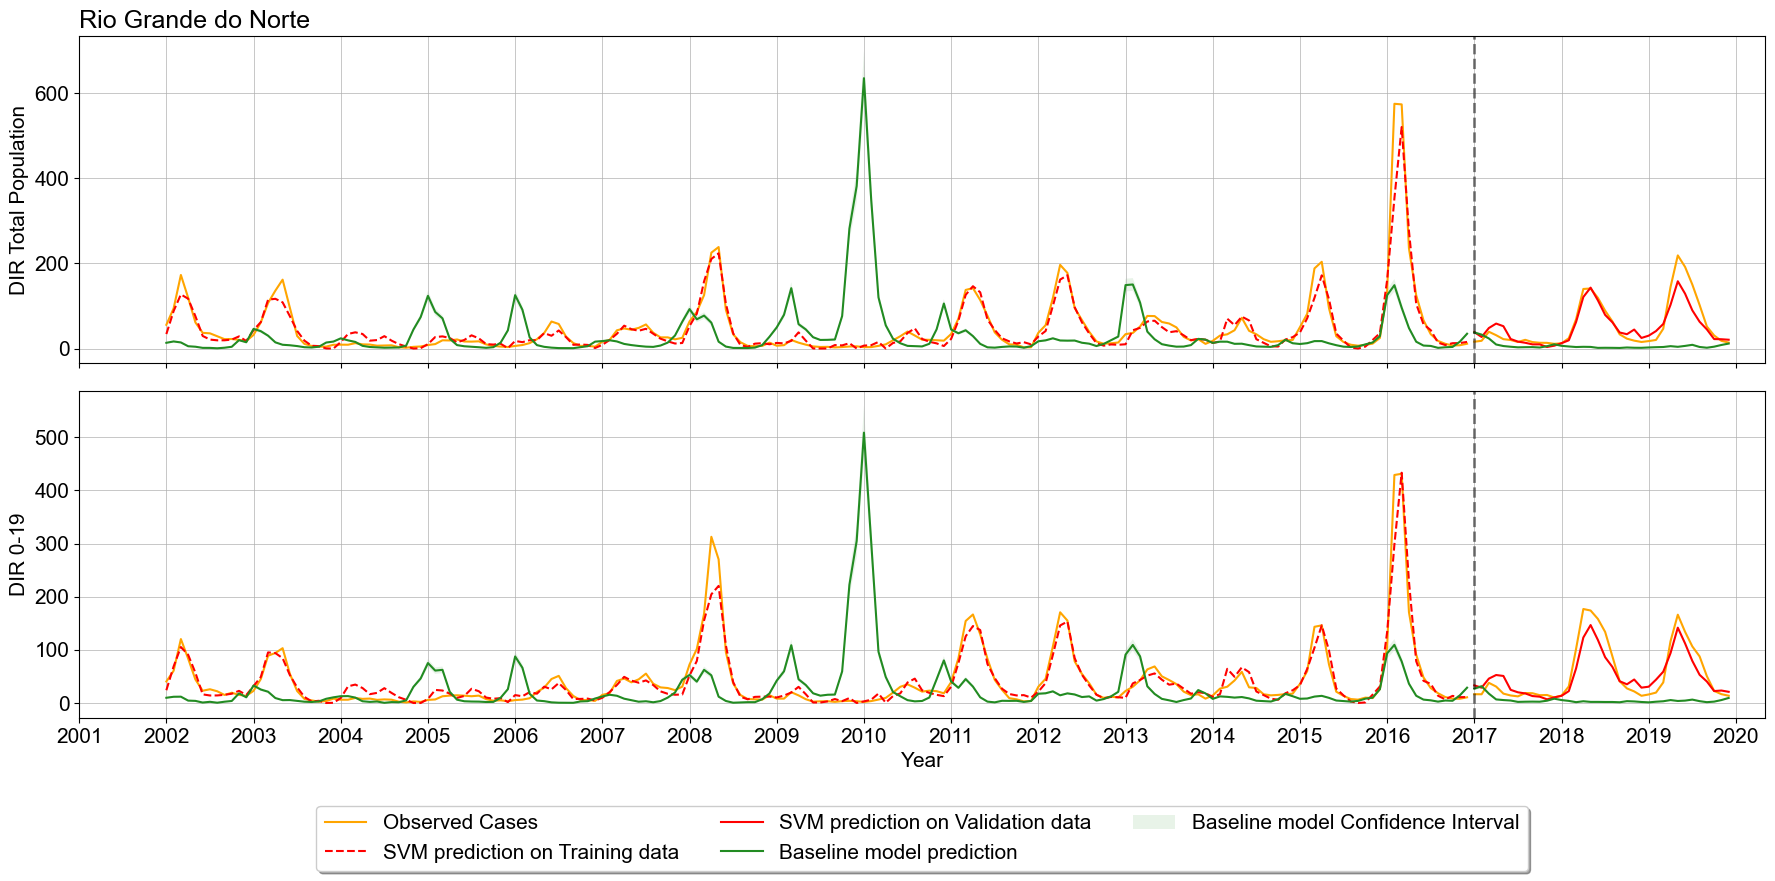

--------------------- TRAINING scores ---------------------
N-RMSE (group total):  0.038269019345014976
R2   (group total):  0.9126592601633504
N-RMSE (group 0-19):  0.040245220215340854
R2   (group 0-19):  0.9225979555728342
-------------------- VALIDATION scores ---------------------
N-RMSE (group total):  0.11204251726007074
R2   (group total):  0.8291866857259655
N-RMSE (group 0-19):  0.1318999750215973
R2   (group 0-19):  0.8347487418803525

##########################################################################################################


C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be remove

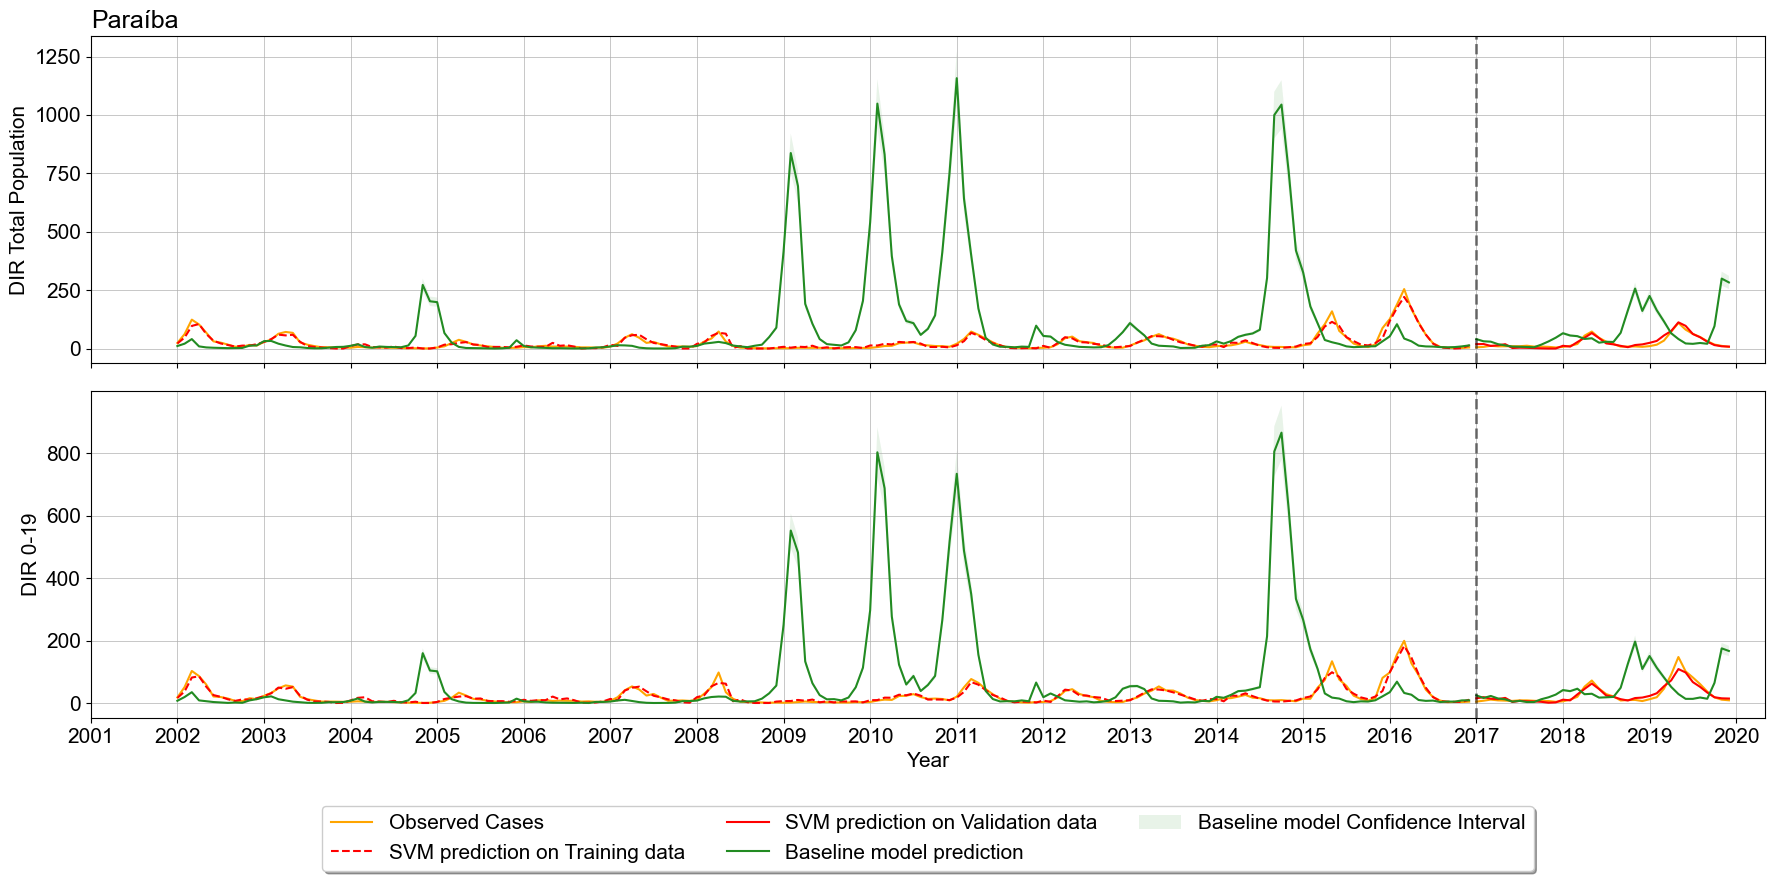

--------------------- TRAINING scores ---------------------
N-RMSE (group total):  0.03364353918903516
R2   (group total):  0.9428158983038389
N-RMSE (group 0-19):  0.038265399696969016
R2   (group 0-19):  0.9337271750241626
-------------------- VALIDATION scores ---------------------
N-RMSE (group total):  0.07884621662040235
R2   (group total):  0.8976677861067544
N-RMSE (group 0-19):  0.06774114578590867
R2   (group 0-19):  0.9142448112488543

##########################################################################################################


C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be remove

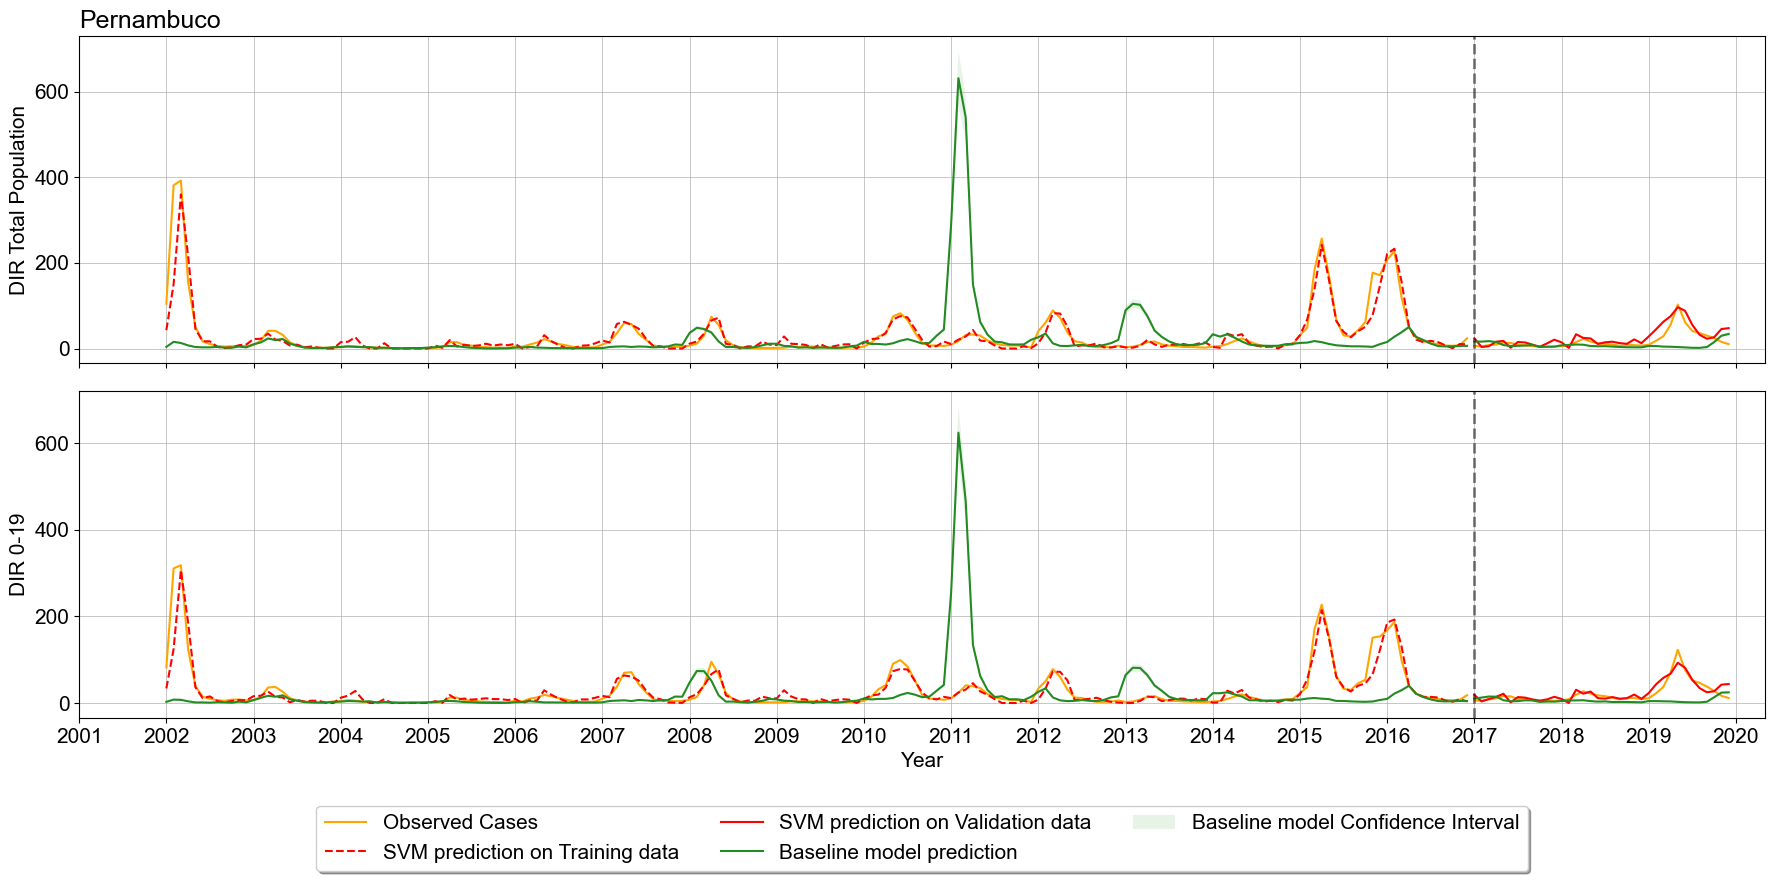

--------------------- TRAINING scores ---------------------
N-RMSE (group total):  0.05612274033010473
R2   (group total):  0.8514029440574098
N-RMSE (group 0-19):  0.059301380204797444
R2   (group 0-19):  0.8499178205235295
-------------------- VALIDATION scores ---------------------
N-RMSE (group total):  0.1485302849513161
R2   (group total):  0.45216234687476076
N-RMSE (group 0-19):  0.09875559115420116
R2   (group 0-19):  0.7684114579296661

##########################################################################################################


C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be remove

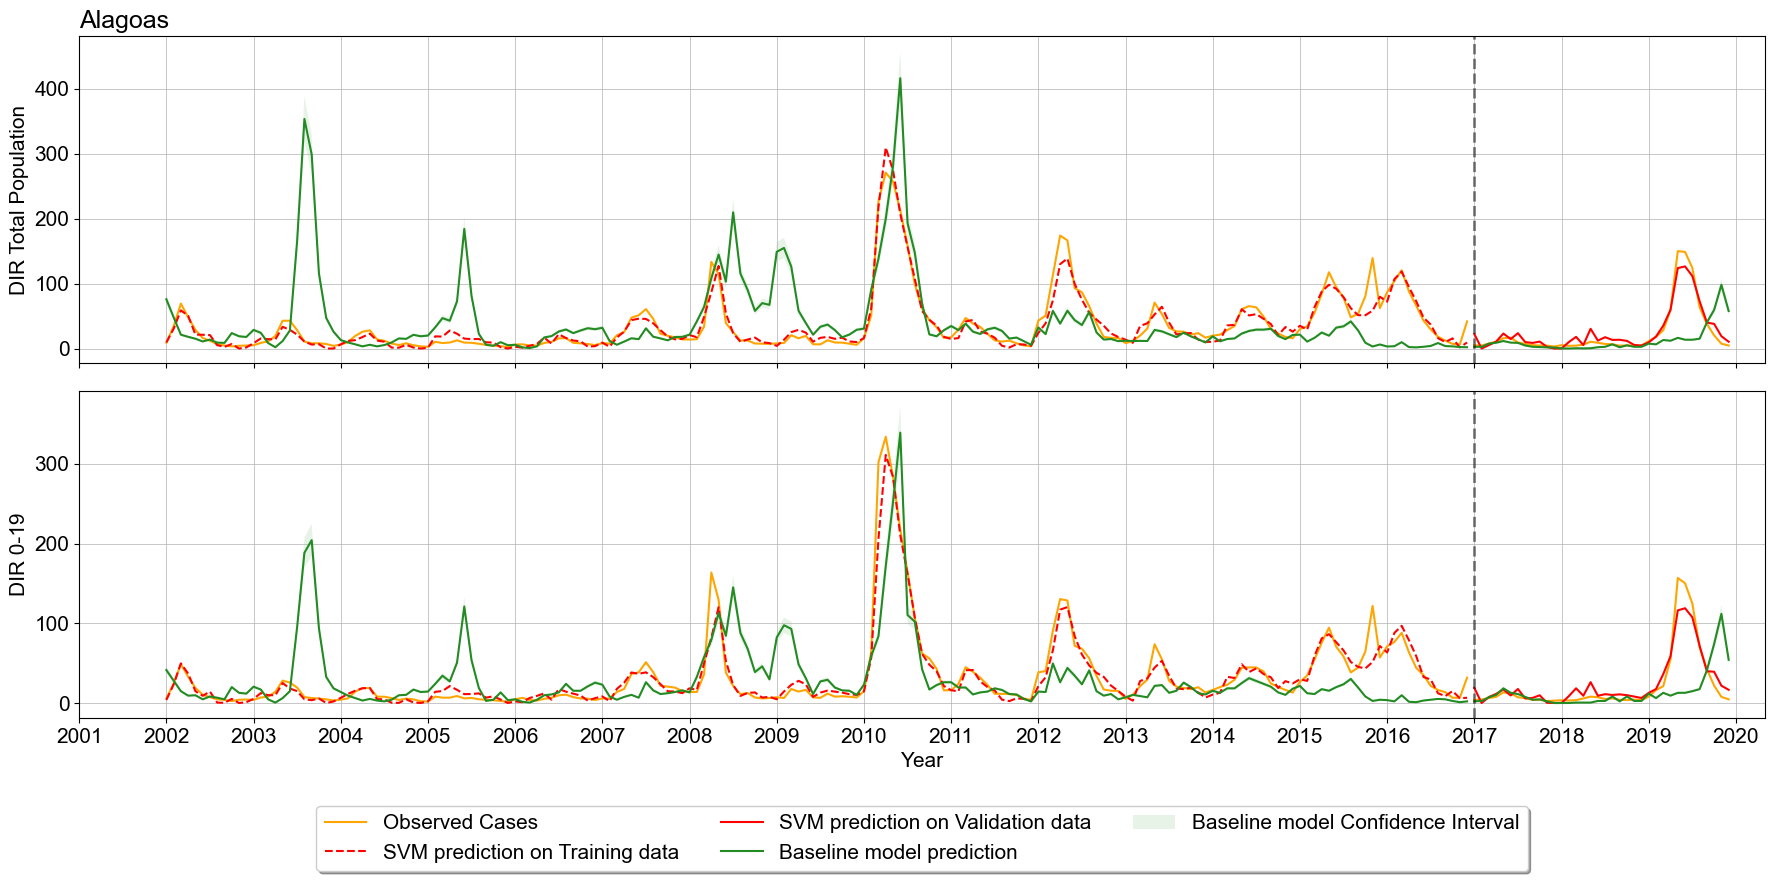

--------------------- TRAINING scores ---------------------
N-RMSE (group total):  0.044594633549557144
R2   (group total):  0.9319647607483508
N-RMSE (group 0-19):  0.039223349396233516
R2   (group 0-19):  0.9287606675738034
-------------------- VALIDATION scores ---------------------
N-RMSE (group total):  0.06771360094772849
R2   (group total):  0.9324625964257843
N-RMSE (group 0-19):  0.07679030767290196
R2   (group 0-19):  0.9103529115653941

##########################################################################################################


C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be remove

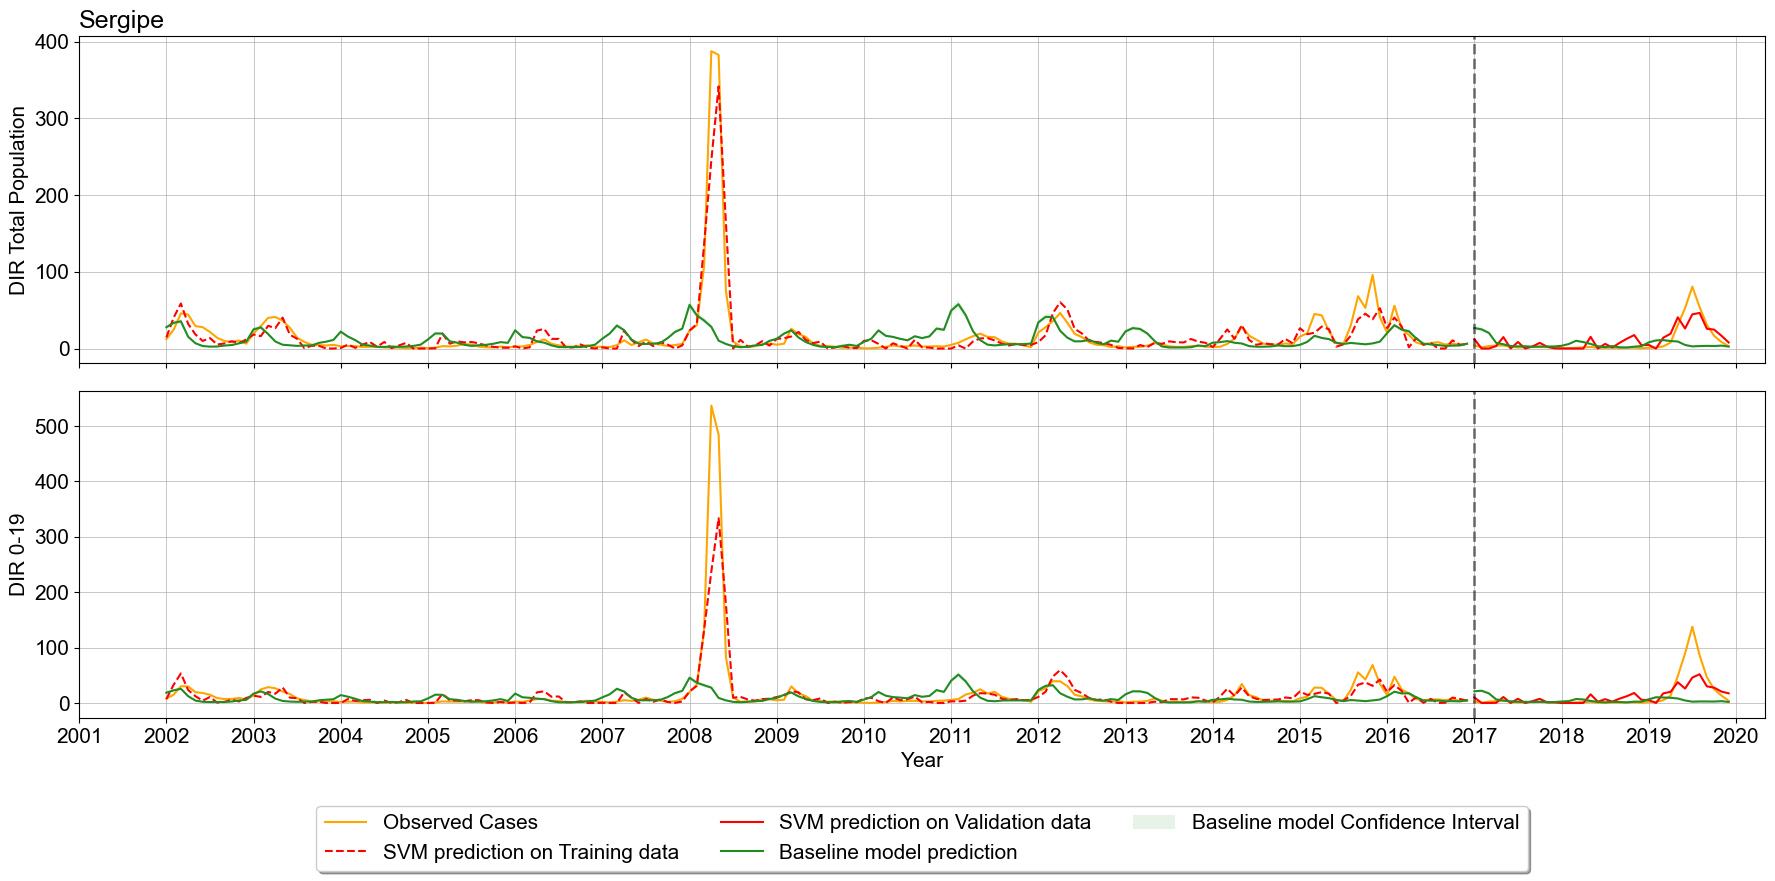

--------------------- TRAINING scores ---------------------
N-RMSE (group total):  0.03995749300057451
R2   (group total):  0.8669007622812455
N-RMSE (group 0-19):  0.05018842519537869
R2   (group 0-19):  0.7574611075893523
-------------------- VALIDATION scores ---------------------
N-RMSE (group total):  0.12458334068428317
R2   (group total):  0.6899048784029298
N-RMSE (group 0-19):  0.1504924895590383
R2   (group 0-19):  0.5305331276230061

##########################################################################################################


C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be remove

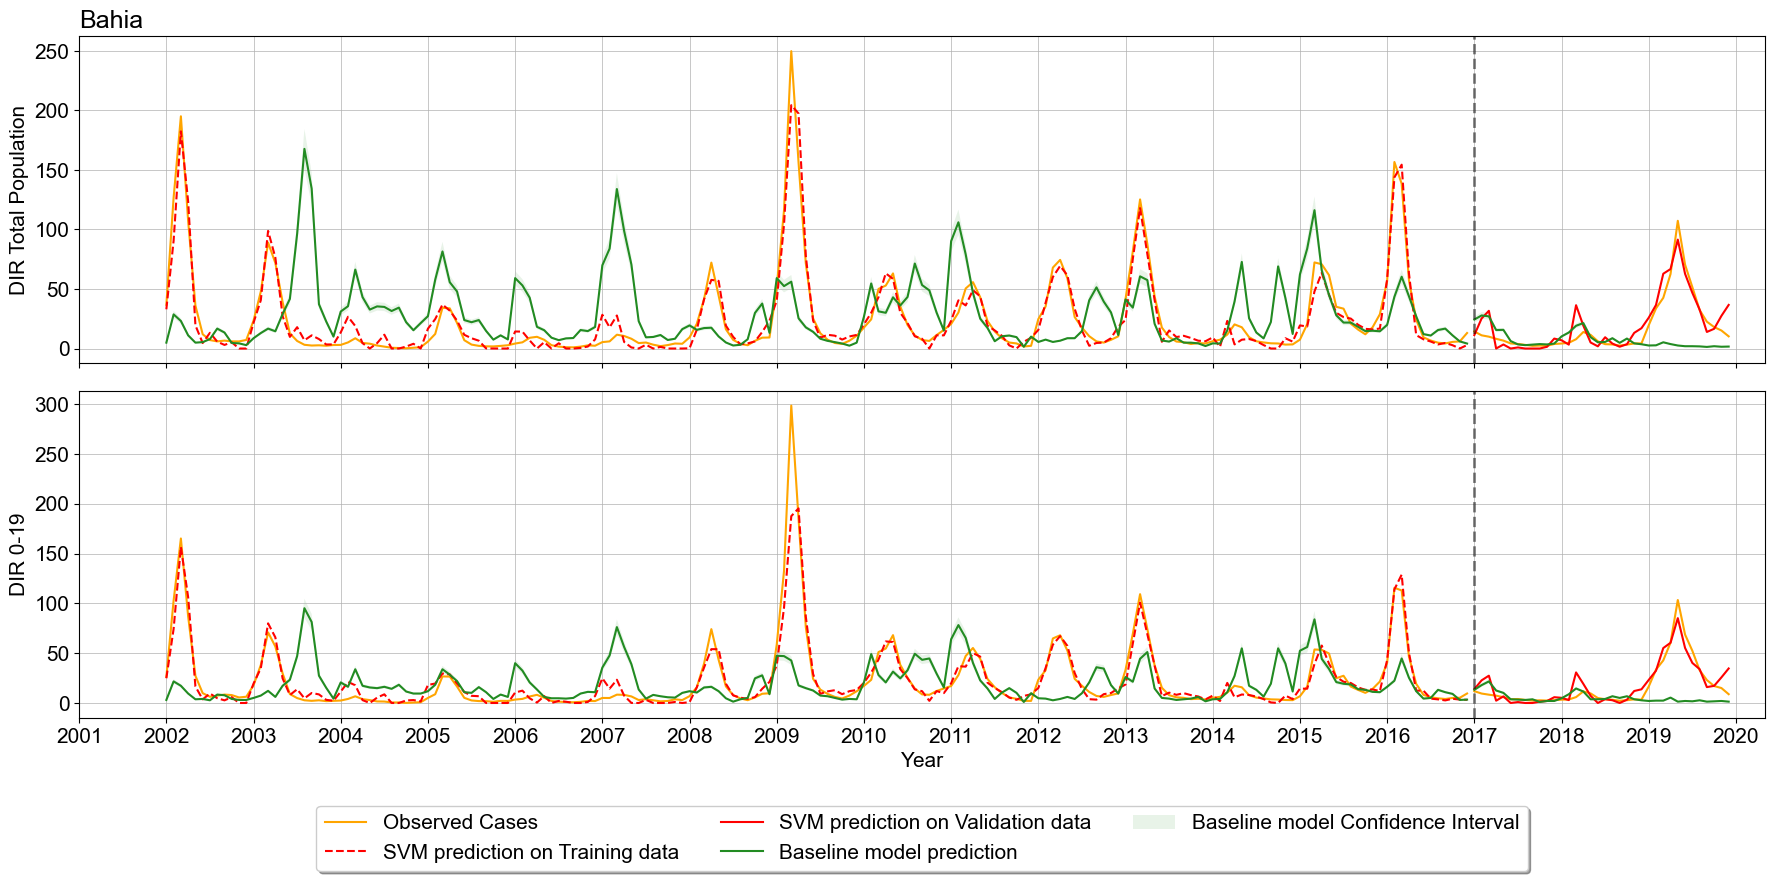

--------------------- TRAINING scores ---------------------
N-RMSE (group total):  0.03648590409868994
R2   (group total):  0.9391238941078054
N-RMSE (group 0-19):  0.03691469084781471
R2   (group 0-19):  0.9076764823193241
-------------------- VALIDATION scores ---------------------
N-RMSE (group total):  0.0971799259378012
R2   (group total):  0.8005707835922201
N-RMSE (group 0-19):  0.09320269588196968
R2   (group 0-19):  0.8240989106461731

##########################################################################################################


C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be remove

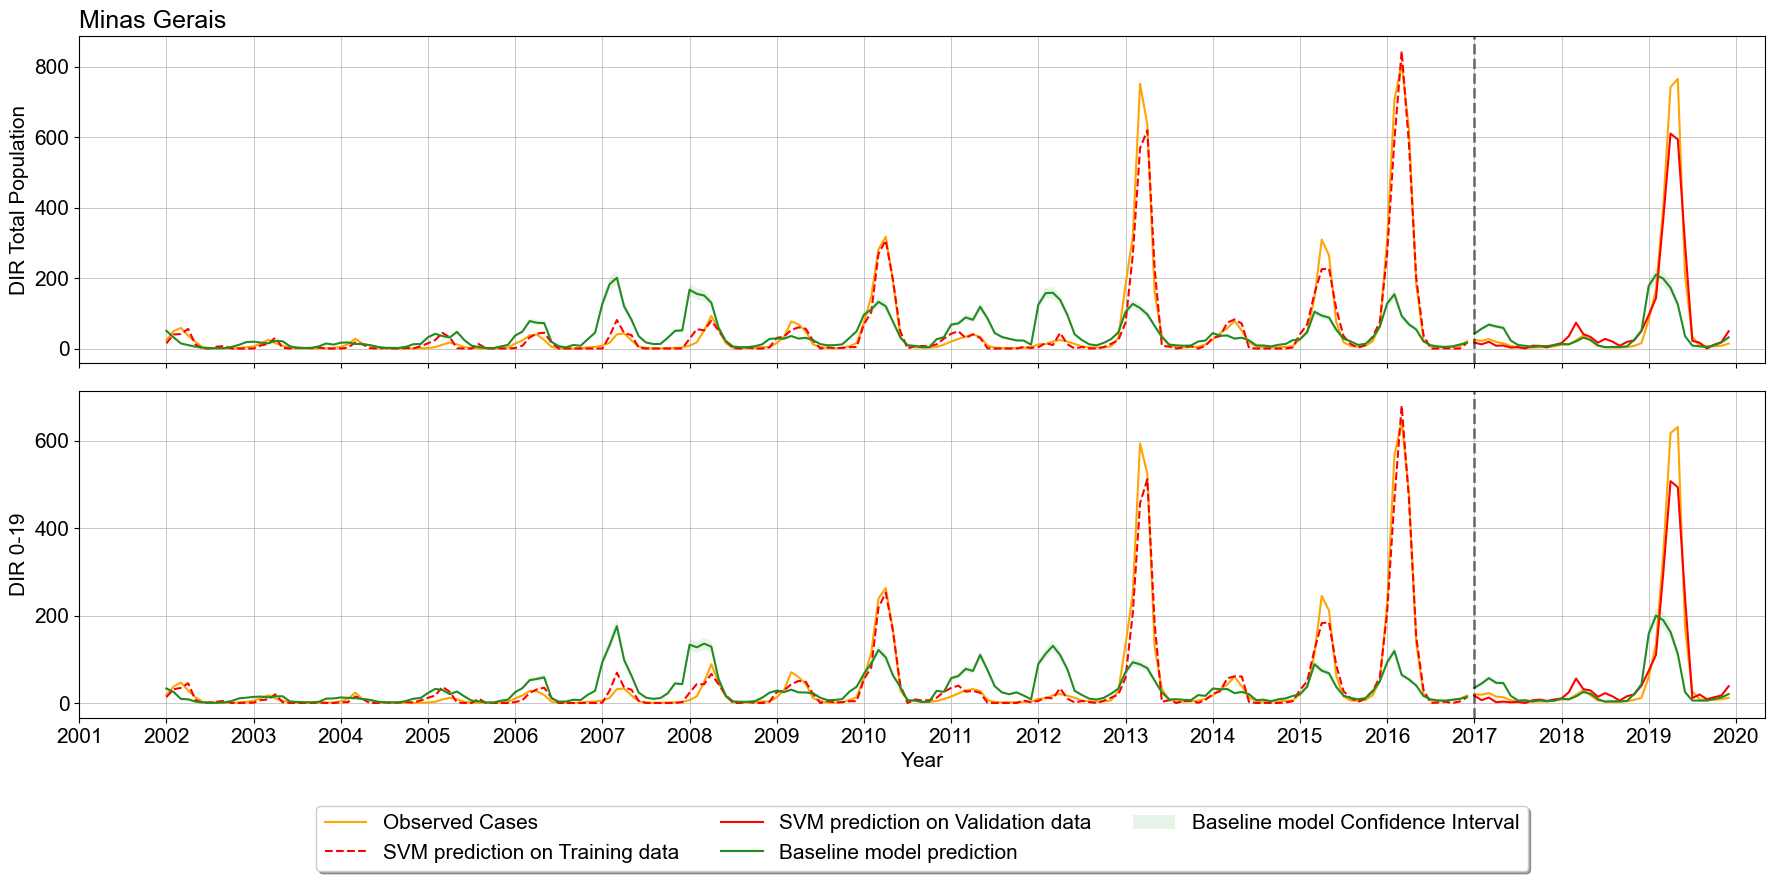

--------------------- TRAINING scores ---------------------
N-RMSE (group total):  0.029113238845189272
R2   (group total):  0.9655278488261223
N-RMSE (group 0-19):  0.02859412317712256
R2   (group 0-19):  0.9666594697677497
-------------------- VALIDATION scores ---------------------
N-RMSE (group total):  0.05568432684908389
R2   (group total):  0.9447918901066844
N-RMSE (group 0-19):  0.05537271321240629
R2   (group 0-19):  0.946016854374836

##########################################################################################################


C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be remove

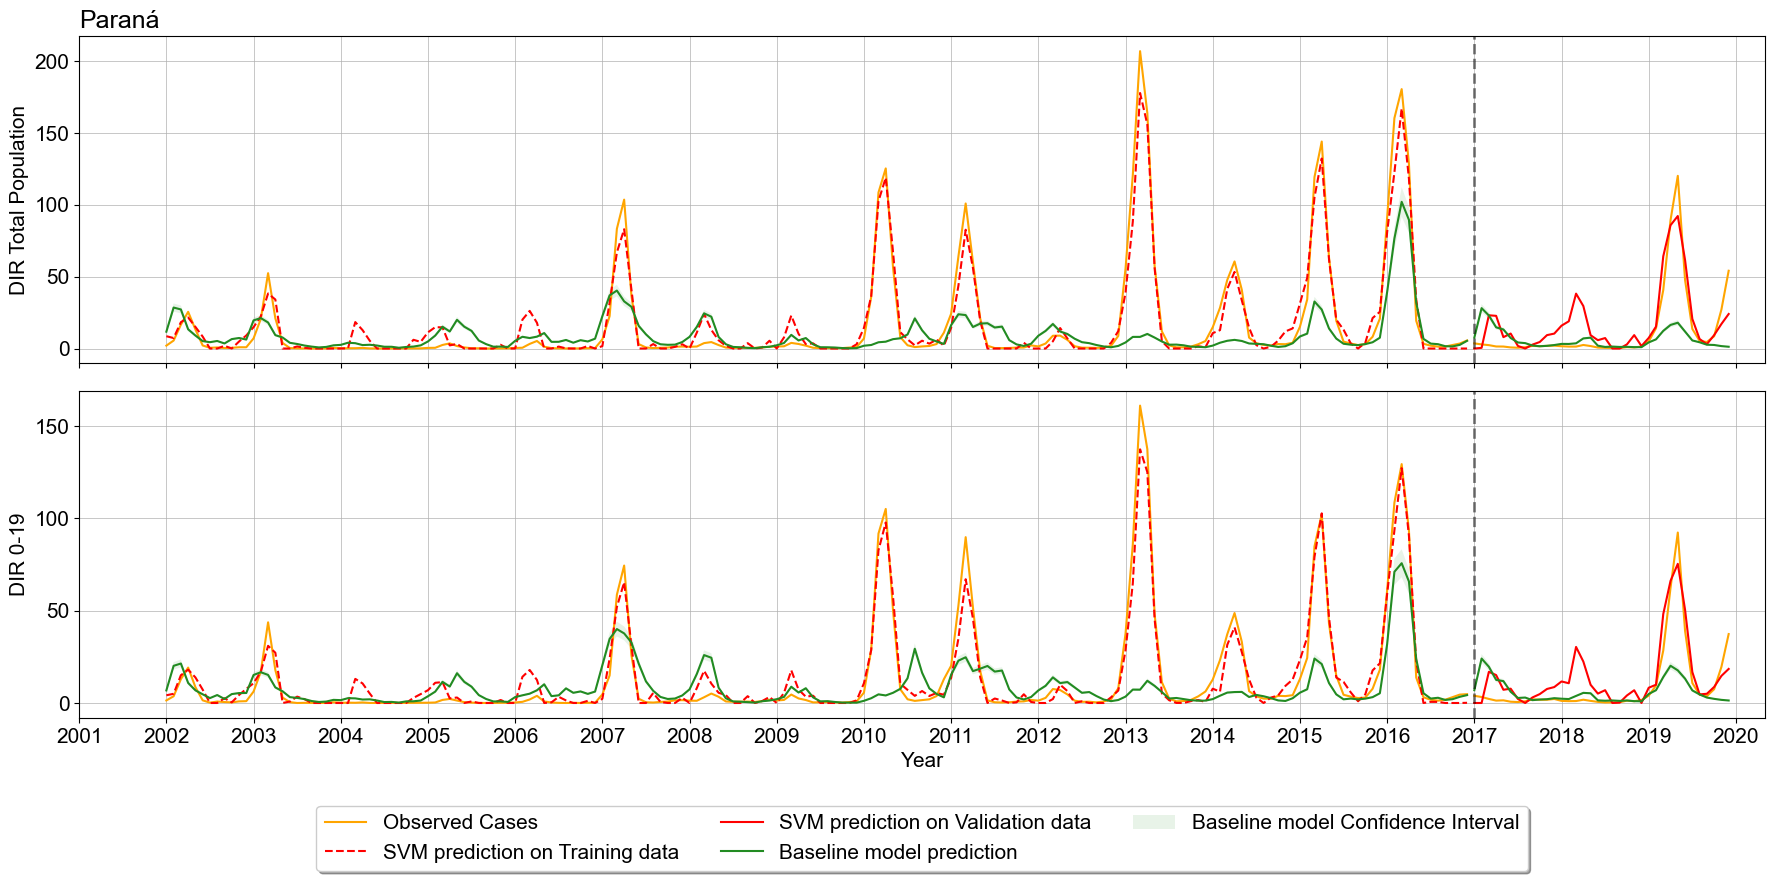

--------------------- TRAINING scores ---------------------
N-RMSE (group total):  0.03984466452422457
R2   (group total):  0.9507647496247341
N-RMSE (group 0-19):  0.0372822543904383
R2   (group 0-19):  0.9546110011003479
-------------------- VALIDATION scores ---------------------
N-RMSE (group total):  0.11292251679339009
R2   (group total):  0.7319168590062968
N-RMSE (group 0-19):  0.10776697373171439
R2   (group 0-19):  0.7366625831433382

##########################################################################################################


C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be remove

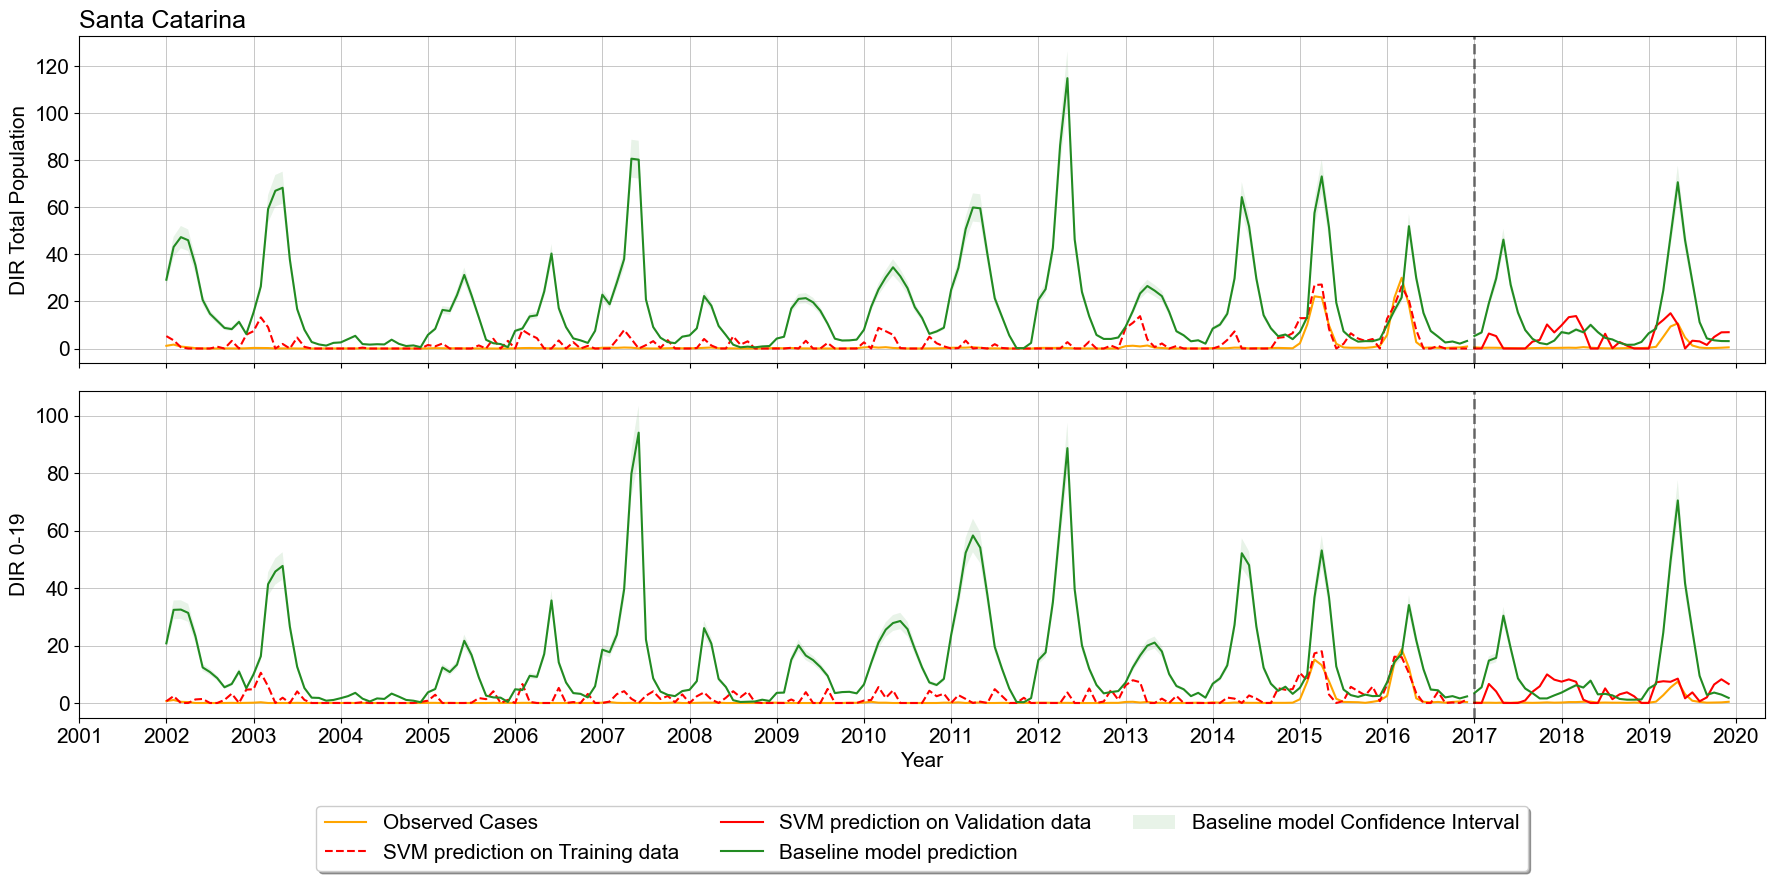

--------------------- TRAINING scores ---------------------
N-RMSE (group total):  0.10441207413721415
R2   (group total):  0.3575833793443427
N-RMSE (group 0-19):  0.1370309439917882
R2   (group 0-19):  -0.018228405413229787
-------------------- VALIDATION scores ---------------------
N-RMSE (group total):  0.5132165077689743
R2   (group total):  -4.104553670685702
N-RMSE (group 0-19):  0.6025527453280992
R2   (group 0-19):  -7.313323783141323

##########################################################################################################


C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be remove

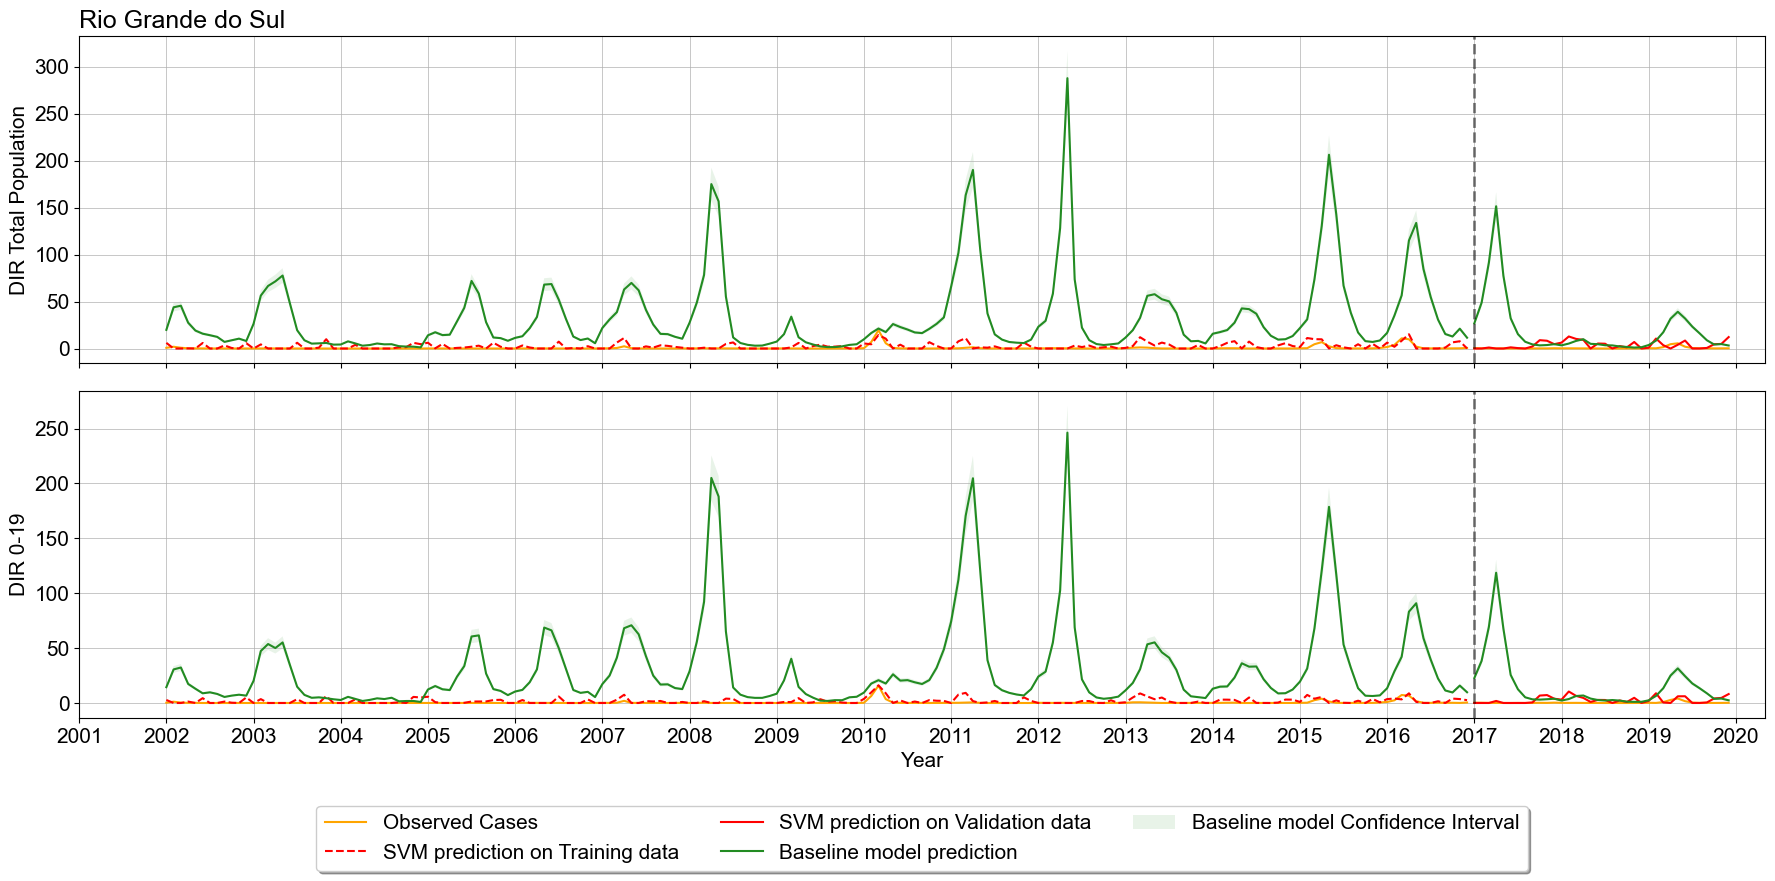

--------------------- TRAINING scores ---------------------
N-RMSE (group total):  0.17164197175386137
R2   (group total):  -1.759186375021903
N-RMSE (group 0-19):  0.15076485506239765
R2   (group 0-19):  -1.4631841607468092
-------------------- VALIDATION scores ---------------------
N-RMSE (group total):  0.9633856626588233
R2   (group total):  -19.676440046910674
N-RMSE (group 0-19):  0.9509447802508144
R2   (group 0-19):  -21.700041620107374

##########################################################################################################


C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be remove

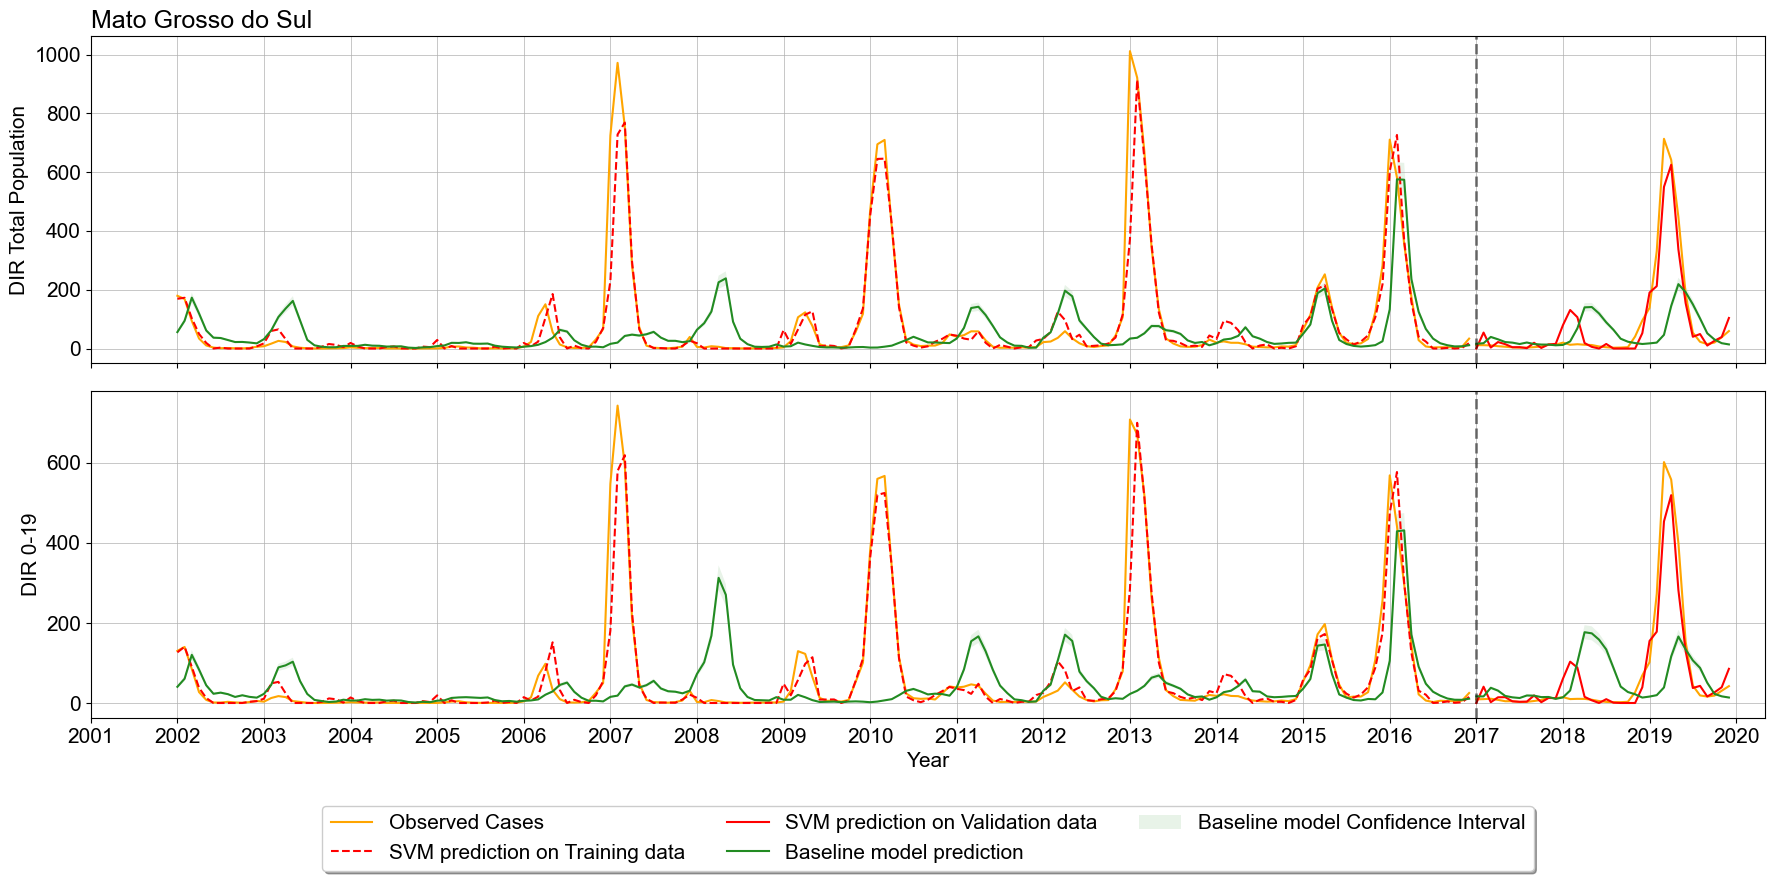

--------------------- TRAINING scores ---------------------
N-RMSE (group total):  0.06721928769815154
R2   (group total):  0.867790700586223
N-RMSE (group 0-19):  0.06589327196358172
R2   (group 0-19):  0.8833342216673832
-------------------- VALIDATION scores ---------------------
N-RMSE (group total):  0.07128409156201929
R2   (group total):  0.9126223587255836
N-RMSE (group 0-19):  0.07478813253942376
R2   (group 0-19):  0.9070349827727274

##########################################################################################################


C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be remove

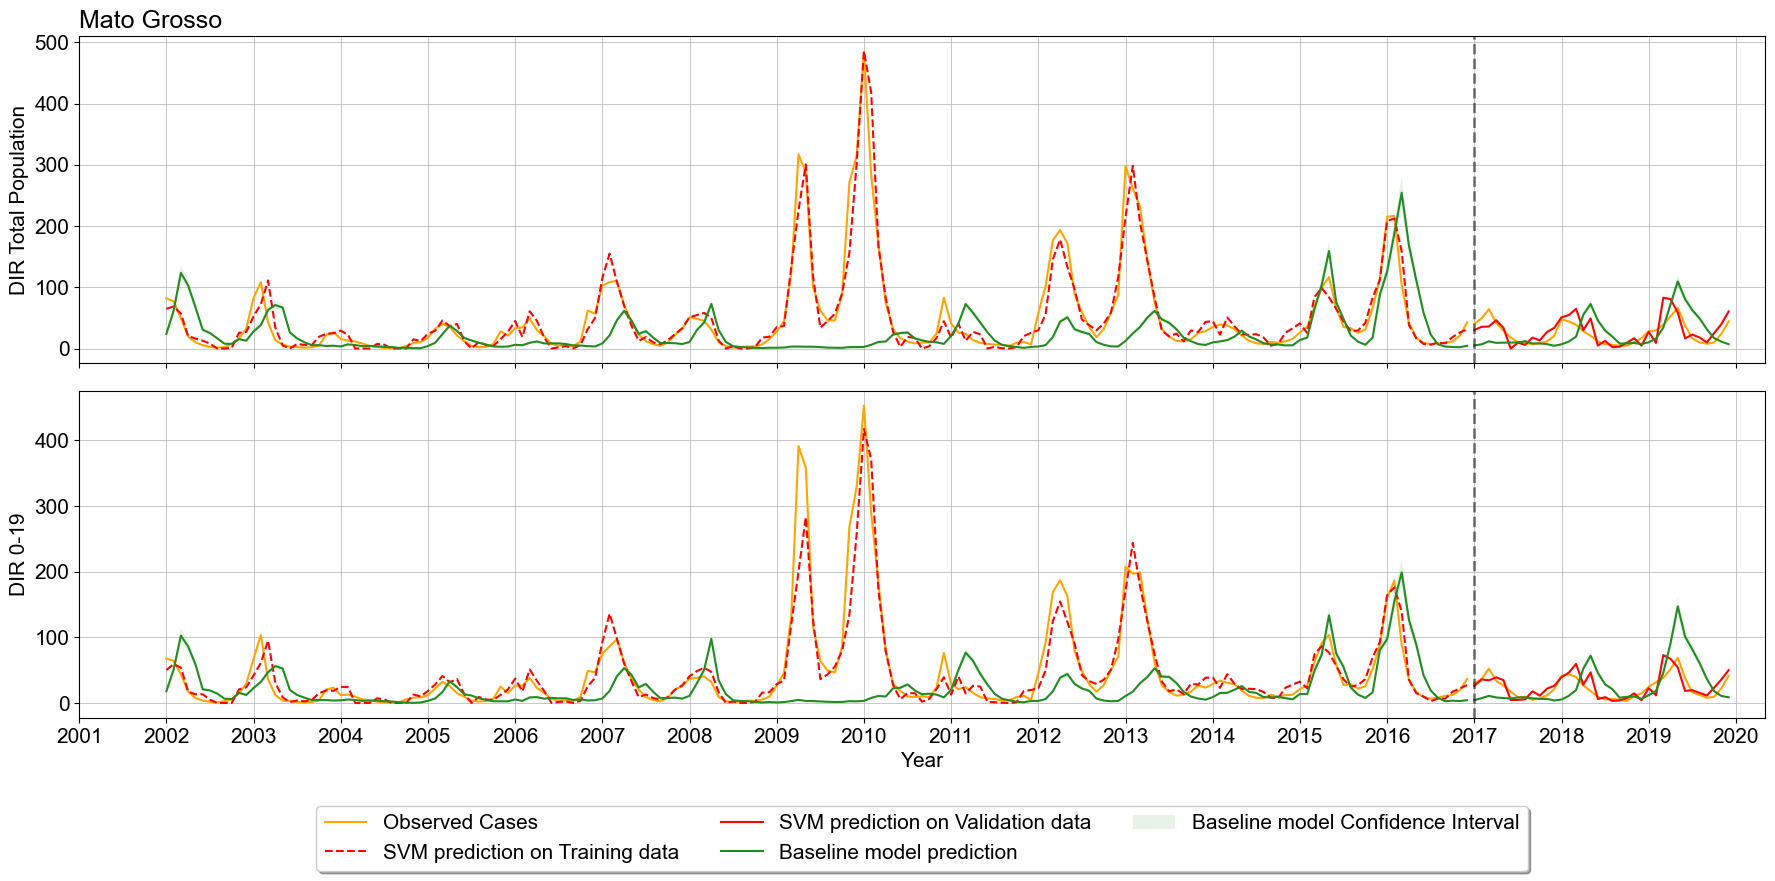

--------------------- TRAINING scores ---------------------
N-RMSE (group total):  0.04459234328696023
R2   (group total):  0.9135227721054089
N-RMSE (group 0-19):  0.0545406529778741
R2   (group 0-19):  0.8825095010855074
-------------------- VALIDATION scores ---------------------
N-RMSE (group total):  0.2474945159813935
R2   (group total):  0.2397797134807913
N-RMSE (group 0-19):  0.1834583200305636
R2   (group 0-19):  0.4457818739233457

##########################################################################################################


C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be remove

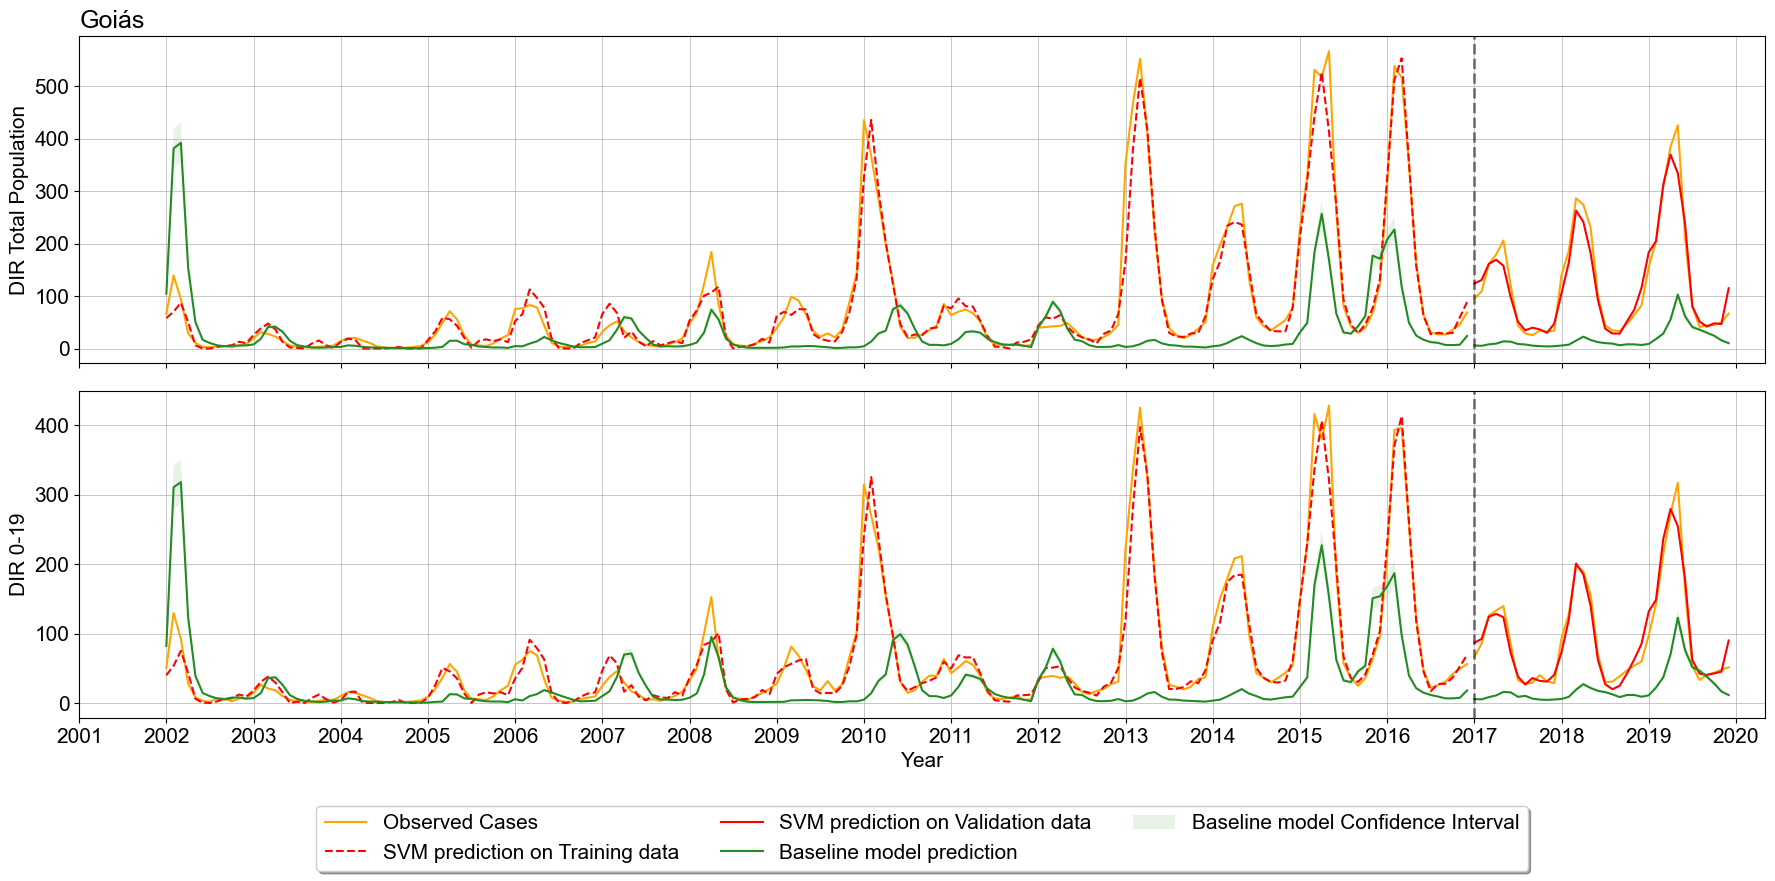

--------------------- TRAINING scores ---------------------
N-RMSE (group total):  0.04758776266374394
R2   (group total):  0.9521332128028142
N-RMSE (group 0-19):  0.045671434160250324
R2   (group 0-19):  0.9543862524964857
-------------------- VALIDATION scores ---------------------
N-RMSE (group total):  0.06504299578401228
R2   (group total):  0.9388788787319488
N-RMSE (group 0-19):  0.059308619442181985
R2   (group 0-19):  0.9438317078298264

##########################################################################################################


C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be remove

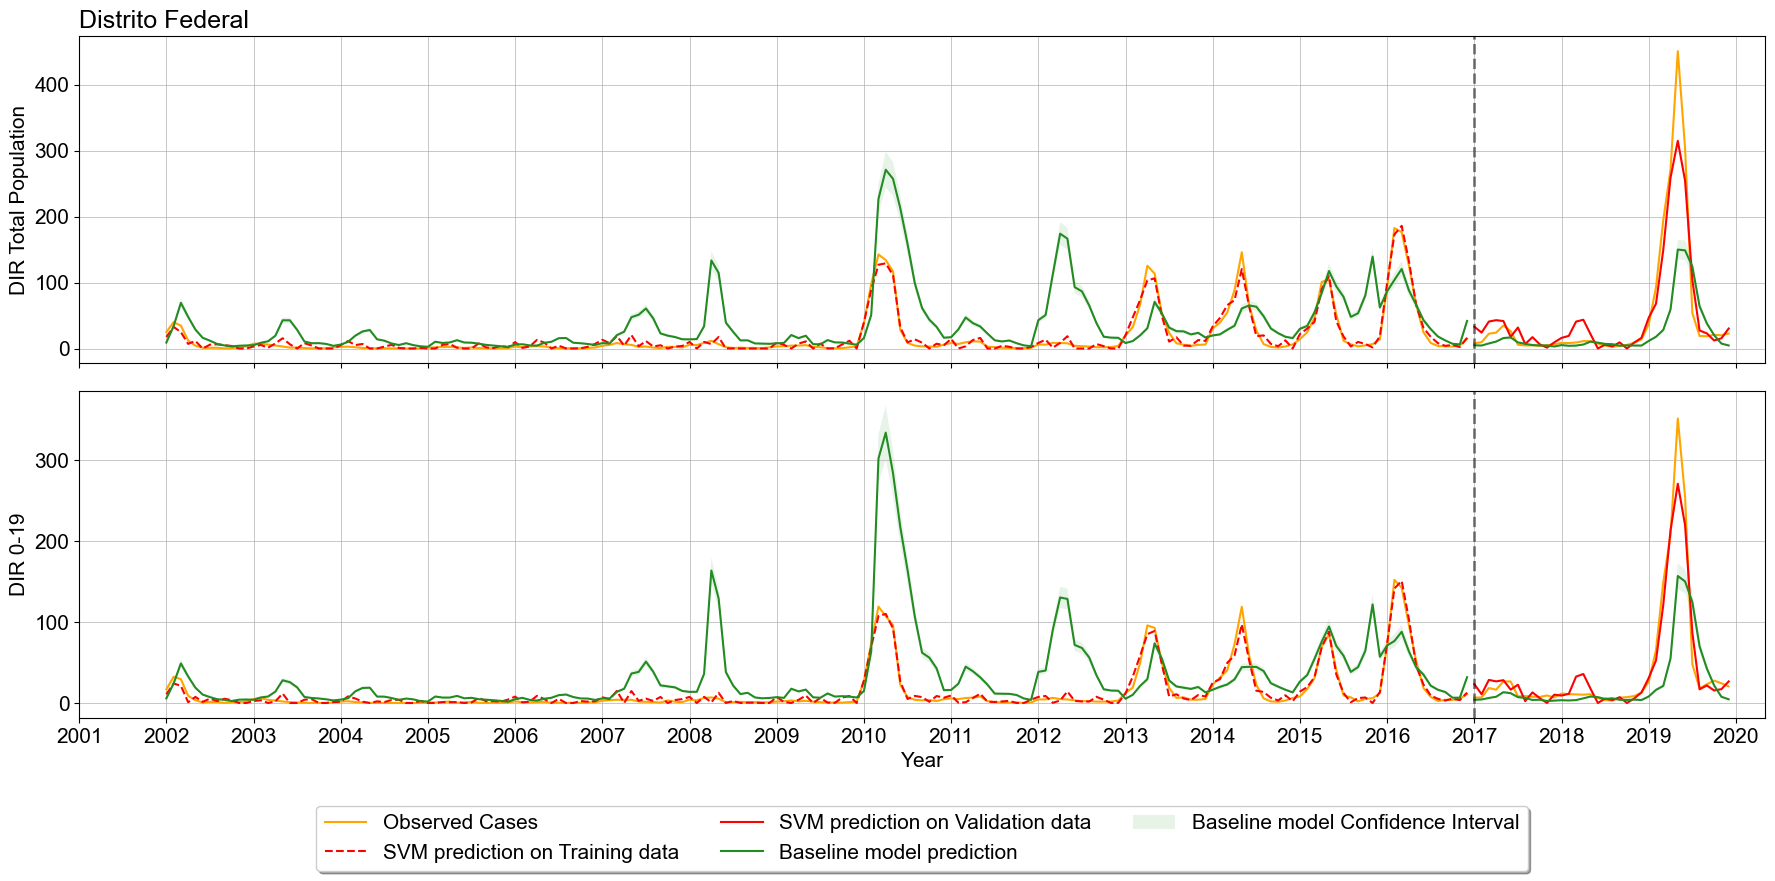

--------------------- TRAINING scores ---------------------
N-RMSE (group total):  0.03372412955156077
R2   (group total):  0.9685346976109677
N-RMSE (group 0-19):  0.03159261517779798
R2   (group 0-19):  0.9702797137829743
-------------------- VALIDATION scores ---------------------
N-RMSE (group total):  0.0661800500901049
R2   (group total):  0.9070970525062425
N-RMSE (group 0-19):  0.054102970162166454
R2   (group 0-19):  0.9382835760818142

##########################################################################################################
Writing performance metrics to file...


C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be remove

In [ ]:
TRAINING = False

if TRAINING:
    svm.train(trainingC, validationC, output_path=join(config['output'], "Brazil"))

else:
    # get most recent svm model
    svm_model = glob(join(config['output'], "Brazil", "svm*"))
    if svm_model == []:
        print('No file with such pattern was found in the directory. Run TRAINING = True first.')
    else:
        svm.load(svm_model[0])

        trainC, valC = dataset_handler.prepare_data_CatBoost(x_train[:,:,2:], y_train, x_val[:,:,2:], y_val)

        preds_tra = svm.model.predict(trainC[0])
        preds_tra[preds_tra < 0] = 0
        preds_val = svm.model.predict(valC[0])
        preds_val[preds_val < 0] = 0

        datelist = pd.date_range('01-01-2001', end='01-01-2020', freq='YS')
        dates = datelist.strftime("%Y").tolist()
        month_datelist = pd.date_range('01-01-2001', end='31-12-2019', freq='MS')
        ts = np.arange(0, len(month_datelist), 1)

        res = []
        res.append('Department,NRMSE 0-19 Training,NRMSE All Training,NRMSE 0-19 Validation,NRMSE All Validation')

        for i in range(nb_deps):
            fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,9))

            idxt = preds_tra.shape[0]//nb_deps
            idxv = preds_val.shape[0]//nb_deps

            t1 = ts[12:12+idxt]
            t2 = ts[(12+idxt):(12+idxt+idxv)]

            # Reverting Data Norm ---------
            pt = scaler.inverse_transform(preds_tra[idxt*i:idxt*(i+1), :])
            pv = scaler.inverse_transform(preds_val[idxv*i:idxv*(i+1), :])

            gtt = scaler.inverse_transform(trainC[1][idxt*i:idxt*(i+1), :])
            gtv = scaler.inverse_transform(valC[1][idxv*i:idxv*(i+1), :])
            # ------------------------------

            baseAll_df = baselineAll[baselineAll.state_index == i][['pred.mean','pred.uci','pred.lci']]
            base019_df = baseline019[baseline019.state_index == i][['pred.mean','pred.uci','pred.lci']]
            if baseAll_df.empty or base019_df.empty:
                # print(f"No baseline data for state_index {i}; skipping this plot.")
                plt.close(fig)
                continue

            axes[0].plot(t1, gtt[:,0], '-', color='orange', label = 'Observed Cases')
            axes[0].plot(t2, gtv[:,0], '-', color='orange')
            axes[0].plot(t1, pt[:,0], '--', color='red', label = 'SVM prediction on Training data')
            axes[0].plot(t2, pv[:,0], '-', color='red', label = 'SVM prediction on Validation data')

            # Baseline model
            axes[0].plot(t1, baseAll_df['pred.mean'].iloc[t1], color='forestgreen', label = 'Baseline model prediction')
            axes[0].fill_between(x=t1, y1=baseAll_df['pred.lci'].iloc[t1], y2=baseAll_df['pred.uci'].iloc[t1], facecolor='forestgreen', alpha=.1, label='Baseline model Confidence Interval')
            axes[0].plot(t2, baseAll_df['pred.mean'].iloc[t2], color='forestgreen')
            axes[0].fill_between(x=t2, y1=baseAll_df['pred.lci'].iloc[t2], y2=baseAll_df['pred.uci'].iloc[t2], facecolor='forestgreen', alpha=.1)

            axes[1].plot(t1, gtt[:,1], '-', color='orange', label = 'Observed Cases')
            axes[1].plot(t2, gtv[:,1], '-', color='orange')
            axes[1].plot(t1, pt[:,1], '--', color='red', label = 'SVM prediction on Training data')
            axes[1].plot(t2, pv[:,1], '-', color='red', label = 'SVM prediction on Validation data')

            # Baseline model
            axes[1].plot(t1, base019_df['pred.mean'].iloc[t1], color='forestgreen', label = 'Baseline model prediction')
            axes[1].fill_between(x=t1, y1=base019_df['pred.lci'].iloc[t1], y2=base019_df['pred.uci'].iloc[t1], facecolor='forestgreen', alpha=.1, label='Baseline model Confidence Interval')
            axes[1].plot(t2, base019_df['pred.mean'].iloc[t2], color='forestgreen')
            axes[1].fill_between(x=t2, y1=base019_df['pred.lci'].iloc[t2], y2=base019_df['pred.uci'].iloc[t2], facecolor='forestgreen', alpha=.1)

            # Configure visualization
            axes[0].set_title(DEP_NAMES[i], fontsize = 18, loc='left')
            axes[0].set(ylabel='DIR Total Population')
            axes[1].set(xlabel='Year', ylabel='DIR 0-19')
            axes[1].legend(ncol=3, loc='lower center', bbox_to_anchor=(0.5,-0.5), shadow=True)
            axes[0].axvline(t2[0], color='black', linewidth=2, linestyle='--', alpha=0.5)
            axes[1].axvline(t2[0], color='black', linewidth=2, linestyle='--', alpha=0.5)

            for ax in axes:
                ax.set_xticks(np.arange(0, len(ts)+1, 12))
                ax.grid(True, linewidth=0.5)
                ax.set_xlim(ts[0],ts[-1]+5)
            axes[0].set_xticklabels([])
            axes[1].set_xticklabels(dates)

            fig.tight_layout()
            plt.show()
            plt.close()

            print('--------------------- TRAINING scores ---------------------')
            rmse1, r2 = compute_scores(gtt[:,0], pt[:,0])
            print('N-RMSE (group total): ', rmse1)
            print('R2   (group total): ', r2)

            rmse2, r2 = compute_scores(gtt[:,1], pt[:,1])
            print('N-RMSE (group 0-19): ', rmse2)
            print('R2   (group 0-19): ', r2)

            print('-------------------- VALIDATION scores ---------------------')
            rmse3, r2 = compute_scores(gtv[:,0], pv[:,0])
            print('N-RMSE (group total): ', rmse3)
            print('R2   (group total): ', r2)

            rmse4, r2 = compute_scores(gtv[:,1], pv[:,1])
            print('N-RMSE (group 0-19): ', rmse4)
            print('R2   (group 0-19): ', r2)

            res.append('{},{},{},{},{}'.format(DEP_NAMES[i], rmse2, rmse1, rmse4, rmse3))
            print('\n##########################################################################################################')

        # # Save results
        # today = datetime.now().strftime("%d-%m-%Y-%H:%M:%S")
        # with open(join(config['metrics'], "Brazil", 'svm-'+today+'.csv'),'w') as f:
        #     print('Writing performance metrics to file...')
        #     for item in res:
        #         f.write("%s\n" % item)

        # Save results
        today = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
        output_path = os.path.join(config['metrics'], "Brazil", f'svm-{today}.csv')

        # Create the directory if it doesn't exist
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        with open(output_path, 'w', encoding='utf-8') as f:
            print('Writing performance metrics to file...')
            for item in res:
                f.write(f"{item}\n")


## LSTM
**Prepare dataset to fit LSTM requirements**

In [ ]:
trainingL, validationL = dataset_handler.prepare_data_LSTM(x_train_a[:,:,2:], y_train_a, x_val_a[:,:,2:], y_val_a)

**Initilize the LSTM**

In [ ]:
from models import LSTMNet
lstm = LSTMNet(trainingL[0].shape[1:])

**Train or Test**

In [ ]:
TRAINING = False

if TRAINING:
    lstm.train(trainingL, validationL, output_path=join(config['output'], "Brazil"))

else:
    # get most recent lstm model
    lstm_model = glob(join(config['output'], "Brazil", "lstm*"))
    if lstm_model == []:
        print('No file with such pattern was found in the directory. Run TRAINING = True first.')
    else:
        lstm.load(lstm_model[0])

        trainL, valL = dataset_handler.prepare_data_LSTM(x_train[:,:,2:], y_train, x_val[:,:,2:], y_val)

        preds_tra = lstm.model.predict(trainL[0])
        preds_tra[preds_tra < 0] = 0
        preds_val = lstm.model.predict(valL[0])
        preds_val[preds_val < 0] = 0

        datelist = pd.date_range('01-01-2001', end='01-01-2020', freq='YS')
        dates = datelist.strftime("%Y").tolist()
        month_datelist = pd.date_range('01-01-2001', end='31-12-2019', freq='MS')
        ts = np.arange(0, len(month_datelist), 1)

        res = []
        res.append('Department,NRMSE 0-19 Training,NRMSE All Training,NRMSE 0-19 Validation,NRMSE All Validation')

        for i in range(nb_deps):
            fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,9))

            idxt = preds_tra.shape[0]//nb_deps
            idxv = preds_val.shape[0]//nb_deps

            t1 = ts[12:12+idxt]
            t2 = ts[(12+idxt):(12+idxt+idxv)]

            # Reverting Data Norm ---------
            pt = scaler.inverse_transform(preds_tra[idxt*i:idxt*(i+1), :])
            pv = scaler.inverse_transform(preds_val[idxv*i:idxv*(i+1), :])

            gtt = scaler.inverse_transform(trainL[1][idxt*i:idxt*(i+1), :])
            gtv = scaler.inverse_transform(valL[1][idxv*i:idxv*(i+1), :])
            # ------------------------------

            baseAll_df = baselineAll[baselineAll.state_index == i][['pred.mean','pred.uci','pred.lci']]
            base019_df = baseline019[baseline019.state_index == i][['pred.mean','pred.uci','pred.lci']]
            if baseAll_df.empty or base019_df.empty:
                # print(f"No baseline data for state_index {i}; skipping this plot.")
                plt.close(fig)
                continue


            axes[0].plot(t1, gtt[:,0], '-', color='orange', label = 'Observed Cases')
            axes[0].plot(t2, gtv[:,0], '-', color='orange')
            axes[0].plot(t1, pt[:,0], '--', color='red', label = 'LSTM prediction on Training data')
            axes[0].plot(t2, pv[:,0], '-', color='red', label = 'LSTM prediction on Validation data')

            # Baseline model
            axes[0].plot(t1, baseAll_df['pred.mean'].iloc[t1], color='forestgreen', label = 'Baseline model prediction')
            axes[0].fill_between(x=t1, y1=baseAll_df['pred.lci'].iloc[t1], y2=baseAll_df['pred.uci'].iloc[t1], facecolor='forestgreen', alpha=.1, label='Baseline model Confidence Interval')
            axes[0].plot(t2, baseAll_df['pred.mean'].iloc[t2], color='forestgreen')
            axes[0].fill_between(x=t2, y1=baseAll_df['pred.lci'].iloc[t2], y2=baseAll_df['pred.uci'].iloc[t2], facecolor='forestgreen', alpha=.1)

            axes[1].plot(t1, gtt[:,1], '-', color='orange', label = 'Observed Cases')
            axes[1].plot(t2, gtv[:,1], '-', color='orange')
            axes[1].plot(t1, pt[:,1], '--', color='red', label = 'LSTM prediction on Training data')
            axes[1].plot(t2, pv[:,1], '-', color='red', label = 'LSTM prediction on Validation data')

            # Baseline model
            axes[1].plot(t1, base019_df['pred.mean'].iloc[t1], color='forestgreen', label = 'Baseline model prediction')
            axes[1].fill_between(x=t1, y1=base019_df['pred.lci'].iloc[t1], y2=base019_df['pred.uci'].iloc[t1], facecolor='forestgreen', alpha=.1, label='Baseline model Confidence Interval')
            axes[1].plot(t2, base019_df['pred.mean'].iloc[t2], color='forestgreen')
            axes[1].fill_between(x=t2, y1=base019_df['pred.lci'].iloc[t2], y2=base019_df['pred.uci'].iloc[t2], facecolor='forestgreen', alpha=.1)

            # Configure visualization
            axes[0].set_title(DEP_NAMES[i], fontsize = 18, loc='left')
            axes[0].set(ylabel='DIR Total Population')
            axes[1].set(xlabel='Year', ylabel='DIR 0-19')
            axes[1].legend(ncol=3, loc='lower center', bbox_to_anchor=(0.5,-0.5), shadow=True)
            axes[0].axvline(t2[0], color='black', linewidth=2, linestyle='--', alpha=0.5)
            axes[1].axvline(t2[0], color='black', linewidth=2, linestyle='--', alpha=0.5)

            for ax in axes:
                ax.set_xticks(np.arange(0, len(ts)+1, 12))
                ax.grid(True, linewidth=0.5)
                ax.set_xlim(ts[0],ts[-1]+5)
            axes[0].set_xticklabels([])
            axes[1].set_xticklabels(dates)

            fig.tight_layout()
            plt.show()
            plt.close()

            print('--------------------- TRAINING scores ---------------------')
            rmse1, r2 = compute_scores(gtt[:,0], pt[:,0])
            print('N-RMSE (group total): ', rmse1)
            print('R2   (group total): ', r2)

            rmse2, r2 = compute_scores(gtt[:,1], pt[:,1])
            print('N-RMSE (group 0-19): ', rmse2)
            print('R2   (group 0-19): ', r2)

            print('-------------------- VALIDATION scores ---------------------')
            rmse3, r2 = compute_scores(gtv[:,0], pv[:,0])
            print('N-RMSE (group total): ', rmse3)
            print('R2   (group total): ', r2)

            rmse4, r2 = compute_scores(gtv[:,1], pv[:,1])
            print('N-RMSE (group 0-19): ', rmse4)
            print('R2   (group 0-19): ', r2)

            res.append('{},{},{},{},{}'.format(DEP_NAMES[i], rmse2, rmse1, rmse4, rmse3))
            print('\n##########################################################################################################')

        # Save results
        today = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
        with open(join(config['metrics'], "Brazil", 'lstm-'+today+'.csv'),'w') as f:
            print('Writing performance metrics to file...')
            for item in res:
                f.write("%s\n" % item)

TypeError: Could not locate function 'mae'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mae', 'registered_name': 'mae'}

## Ensemble
**Prepare dataset to fit the Ensemble requirements**

In [ ]:
from scipy.optimize import curve_fit
from tqdm import tqdm

In [ ]:
def interpolation(trainL, valL):

    def pol_zero(x, a):
        return a

    def pol_one(x, a, b):
        return a + b*x

    def pol_two(x, a, b, c):
        return a + b*x + c*x*x

    train_019_pol0 = []
    train_019_pol1 = []
    train_019_pol2 = []

    train_all_pol0 = []
    train_all_pol1 = []
    train_all_pol2 = []

    val_019_pol0 = []
    val_019_pol1 = []
    val_019_pol2 = []

    val_all_pol0 = []
    val_all_pol1 = []
    val_all_pol2 = []

    for i in tqdm(range(trainL[0].shape[0])):
        popt_0, _ = curve_fit(pol_zero, np.arange(0,12,1), trainL[0][i,:,-1])
        popt_1, _ = curve_fit(pol_one, np.arange(0,12,1),  trainL[0][i,:,-1])
        popt_2, _ = curve_fit(pol_two, np.arange(0,12,1), trainL[0][i,:,-1])

        train_019_pol0.append(pol_zero(12, *popt_0))
        train_019_pol1.append(pol_one(12, *popt_1))
        train_019_pol2.append(pol_two(12, *popt_2))

        popt_0, _ = curve_fit(pol_zero, np.arange(0,12,1), trainL[0][i,:,-2])
        popt_1, _ = curve_fit(pol_one, np.arange(0,12,1),  trainL[0][i,:,-2])
        popt_2, _ = curve_fit(pol_two, np.arange(0,12,1),  trainL[0][i,:,-2])

        train_all_pol0.append(pol_zero(12, *popt_0))
        train_all_pol1.append(pol_one(12, *popt_1))
        train_all_pol2.append(pol_two(12, *popt_2))

    for i in tqdm(range(valL[0].shape[0])):
        popt_0, _ = curve_fit(pol_zero, np.arange(0,12,1), valL[0][i,:,-1])
        popt_1, _ = curve_fit(pol_one, np.arange(0,12,1), valL[0][i,:,-1])
        popt_2, _ = curve_fit(pol_two, np.arange(0,12,1), valL[0][i,:,-1])

        val_019_pol0.append(pol_zero(12, *popt_0))
        val_019_pol1.append(pol_one(12, *popt_1))
        val_019_pol2.append(pol_two(12, *popt_2))

        popt_0, _ = curve_fit(pol_zero, np.arange(0,12,1), valL[0][i,:,-2])
        popt_1, _ = curve_fit(pol_one, np.arange(0,12,1), valL[0][i,:,-2])
        popt_2, _ = curve_fit(pol_two, np.arange(0,12,1), valL[0][i,:,-2])

        val_all_pol0.append(pol_zero(12, *popt_0))
        val_all_pol1.append(pol_one(12, *popt_1))
        val_all_pol2.append(pol_two(12, *popt_2))

    train_019_pol0 = np.array(train_019_pol0)
    train_019_pol1 = np.array(train_019_pol1)
    train_019_pol2 = np.array(train_019_pol2)

    train_all_pol0 = np.array(train_all_pol0)
    train_all_pol1 = np.array(train_all_pol1)
    train_all_pol2 = np.array(train_all_pol2)

    val_019_pol0 = np.array(val_019_pol0)
    val_019_pol1 = np.array(val_019_pol1)
    val_019_pol2 = np.array(val_019_pol2)

    val_all_pol0 = np.array(val_all_pol0)
    val_all_pol1 = np.array(val_all_pol1)
    val_all_pol2 = np.array(val_all_pol2)


    train_pol0 = np.column_stack((train_019_pol0, train_all_pol0))
    train_pol1 = np.column_stack((train_019_pol1, train_all_pol1))
    train_pol2 = np.column_stack((train_019_pol2, train_all_pol2))

    val_pol0 = np.column_stack((val_019_pol0, val_all_pol0))
    val_pol1 = np.column_stack((val_019_pol1, val_all_pol1))
    val_pol2 = np.column_stack((val_019_pol2, val_all_pol2))

    return train_pol0, train_pol1, train_pol2, val_pol0, val_pol1, val_pol2

**Initilize the Ensemble model**

In [ ]:
from models import Ensamble, CatBoostEnsableNet, RandomForestEnsableNet
ens = RandomForestEnsableNet(False)

**Train or Test**

In [ ]:
# Load the inner models
cat_boost.load(glob(join(config['output'], "Brazil", "catboost*"))[0])
svm.load(glob(join(config['output'], "Brazil", "svm*"))[0])
lstm.load(glob(join(config['output'], "Brazil", "lstm*"))[0])

IndexError: list index out of range

In [ ]:
TRAINING = False

if TRAINING:

    catBoost_train = cat_boost.model.predict(trainingC[0])
    catBoost_train[catBoost_train < 0] = 0
    catBoost_val = cat_boost.model.predict(validationC[0])
    catBoost_val[catBoost_val < 0] = 0

    svm_train = svm.model.predict(trainingC[0])
    svm_train[svm_train < 0] = 0
    svm_val = svm.model.predict(validationC[0])
    svm_val[svm_val < 0] = 0

    lstm_train = lstm.model.predict(trainingL[0])
    lstm_train[lstm_train < 0] = 0
    lstm_val = lstm.model.predict(validationL[0])
    lstm_val[lstm_val < 0] = 0

    train_pol0, train_pol1, train_pol2, val_pol0, val_pol1, val_pol2 = interpolation(trainingL, validationL)

    x_trainE = np.concatenate((catBoost_train, svm_train, lstm_train, train_pol0, train_pol1, train_pol2), axis=-1)
    y_trainE = trainingL[1]
    x_valE = np.concatenate((catBoost_val, svm_val, lstm_val, val_pol0, val_pol1, val_pol2), axis=-1)
    y_valE = validationL[1]

    ens.train(x_trainE, y_trainE, x_valE, y_valE, output_path=join(config['output'], "Brazil"))

else:
    # Load the ensemble model
    ens_model = glob(join(config['output'], "Brazil", "rf*"))
    if ens_model == []:
        print('No file with such pattern was found in the directory. Run TRAINING = True first.')
    else:
        ens.load(ens_model[0])

        trainC, valC = dataset_handler.prepare_data_CatBoost(x_train[:,:,2:], y_train, x_val[:,:,2:], y_val)
        trainL, valL = dataset_handler.prepare_data_LSTM(x_train[:,:,2:], y_train, x_val[:,:,2:], y_val)

        catBoost_train = cat_boost.model.predict(trainC[0])
        catBoost_train[catBoost_train < 0] = 0
        catBoost_val = cat_boost.model.predict(valC[0])
        catBoost_val[catBoost_val < 0] = 0

        svm_train = svm.model.predict(trainC[0])
        svm_train[svm_train < 0] = 0
        svm_val = svm.model.predict(valC[0])
        svm_val[svm_val < 0] = 0

        lstm_train = lstm.model.predict(trainL[0])
        lstm_train[lstm_train < 0] = 0
        lstm_val = lstm.model.predict(valL[0])
        lstm_val[lstm_val < 0] = 0

        train_pol0, train_pol1, train_pol2, val_pol0, val_pol1, val_pol2 = interpolation(trainL, valL)

        x_trainE = np.concatenate((catBoost_train, svm_train, lstm_train, train_pol0, train_pol1, train_pol2), axis=-1)
        y_trainE = trainingL[1]
        x_valE = np.concatenate((catBoost_val, svm_val, lstm_val, val_pol0, val_pol1, val_pol2), axis=-1)
        y_valE = validationL[1]

        preds_tra = ens.model.predict(x_trainE)
        preds_tra[preds_tra < 0] = 0
        preds_val = ens.model.predict(x_valE)
        preds_val[preds_val < 0] = 0

        datelist = pd.date_range('01-01-2001', end='01-01-2020', freq='YS')
        dates = datelist.strftime("%Y").tolist()

        # Total timesteps (nb of months inside this time window) = 228
        month_datelist = pd.date_range('01-01-2001', end='31-12-2019', freq='MS')
        ts = np.arange(0, len(month_datelist), 1)

        res = []
        res.append('Department,NRMSE 0-19 Training,NRMSE All Training,NRMSE 0-19 Validation,NRMSE All Validation')

        for i in range(nb_deps):
            fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,9))

            idxt = preds_tra.shape[0]//nb_deps
            idxv = preds_val.shape[0]//nb_deps

            t1 = ts[12:12+idxt]
            t2 = ts[(12+idxt):(12+idxt+idxv)]

            # Reverting Data Norm ---------
            pt = scaler.inverse_transform(preds_tra[idxt*i:idxt*(i+1), :])
            pv = scaler.inverse_transform(preds_val[idxv*i:idxv*(i+1), :])

            gtt = scaler.inverse_transform(trainL[1][idxt*i:idxt*(i+1), :])
            gtv = scaler.inverse_transform(valL[1][idxv*i:idxv*(i+1), :])
            # ------------------------------

            baseAll_df = baselineAll[baselineAll.state_index == i][['pred.mean','pred.uci','pred.lci']]
            base019_df = baseline019[baseline019.state_index == i][['pred.mean','pred.uci','pred.lci']]

            axes[0].plot(t1, gtt[:,0], '-', color='orange', label = 'Observed Cases')
            axes[0].plot(t2, gtv[:,0], '-', color='orange')
            axes[0].plot(t1, pt[:,0], '--', color='red', label = 'Ensemble prediction on Training data')
            axes[0].plot(t2, pv[:,0], '-', color='red', label = 'Ensemble prediction on Validation data')

            # Baseline model
            axes[0].plot(t1, baseAll_df['pred.mean'].iloc[t1], color='forestgreen', label = 'Baseline model prediction')
            axes[0].fill_between(x=t1, y1=baseAll_df['pred.lci'].iloc[t1], y2=baseAll_df['pred.uci'].iloc[t1], facecolor='forestgreen', alpha=.1, label='Baseline model Confidence Interval')
            axes[0].plot(t2, baseAll_df['pred.mean'].iloc[t2], color='forestgreen')
            axes[0].fill_between(x=t2, y1=baseAll_df['pred.lci'].iloc[t2], y2=baseAll_df['pred.uci'].iloc[t2], facecolor='forestgreen', alpha=.1)

            axes[1].plot(t1, gtt[:,1], '-', color='orange', label = 'Observed Cases')
            axes[1].plot(t2, gtv[:,1], '-', color='orange')
            axes[1].plot(t1, pt[:,1], '--', color='red', label = 'Ensemble prediction on Training data')
            axes[1].plot(t2, pv[:,1], '-', color='red', label = 'Ensemble prediction on Validation data')

            # Baseline model
            axes[1].plot(t1, base019_df['pred.mean'].iloc[t1], color='forestgreen', label = 'Baseline model prediction')
            axes[1].fill_between(x=t1, y1=base019_df['pred.lci'].iloc[t1], y2=base019_df['pred.uci'].iloc[t1], facecolor='forestgreen', alpha=.1, label='Baseline model Confidence Interval')
            axes[1].plot(t2, base019_df['pred.mean'].iloc[t2], color='forestgreen')
            axes[1].fill_between(x=t2, y1=base019_df['pred.lci'].iloc[t2], y2=base019_df['pred.uci'].iloc[t2], facecolor='forestgreen', alpha=.1)

            # Configure visualization
            axes[0].set_title(DEP_NAMES[i], fontsize = 18, loc='left')
            axes[0].set(ylabel='DIR Total Population')
            axes[1].set(xlabel='Year', ylabel='DIR 0-19')
            axes[1].legend(ncol=3, loc='lower center', bbox_to_anchor=(0.5,-0.5), shadow=True)
            axes[0].axvline(t2[0], color='black', linewidth=2, linestyle='--', alpha=0.5)
            axes[1].axvline(t2[0], color='black', linewidth=2, linestyle='--', alpha=0.5)

            for ax in axes:
                ax.set_xticks(np.arange(0, len(ts)+1, 12))
                ax.grid(True, linewidth=0.5)
                ax.set_xlim(ts[0],ts[-1]+5)
            axes[0].set_xticklabels([])
            axes[1].set_xticklabels(dates)

            fig.tight_layout()
            plt.show()
            plt.close()

            print('--------------------- TRAINING scores ---------------------')
            rmse1, r2 = compute_scores(gtt[:,0], pt[:,0])
            print('N-RMSE (group total): ', rmse1)
            print('R2   (group total): ', r2)

            rmse2, r2 = compute_scores(gtt[:,1], pt[:,1])
            print('N-RMSE (group 0-19): ', rmse2)
            print('R2   (group 0-19): ', r2)

            print('-------------------- VALIDATION scores ---------------------')
            rmse3, r2 = compute_scores(gtv[:,0], pv[:,0])
            print('N-RMSE (group total): ', rmse3)
            print('R2   (group total): ', r2)

            rmse4, r2 = compute_scores(gtv[:,1], pv[:,1])
            print('N-RMSE (group 0-19): ', rmse4)
            print('R2   (group 0-19): ', r2)

            res.append('{},{},{},{},{}'.format(DEP_NAMES[i], rmse2, rmse1, rmse4, rmse3))
            print('\n##########################################################################################################')

        # Save results
        today = datetime.now().strftime("%d-%m-%Y-%H:%M:%S")
        with open(join(config['metrics'], "Brazil", 'rf_ensemble-'+today+'.csv'),'w') as f:
            print('Writing performance metrics to file...')
            for item in res:
                f.write("%s\n" % item)

No file with such pattern was found in the directory. Run TRAINING = True first.


Compute confidence intervals for the ensemble model.

In [ ]:
# Load the inner models
cat_boost.load(glob(join(config['output'], "Brazil", "catboost*"))[0])
svm.load(glob(join(config['output'], "Brazil", "svm*"))[0])
lstm.load(glob(join(config['output'], "Brazil", "lstm*"))[0])

# Ensemble
ens.load(glob(join(config['output'], "Brazil", "rf*"))[0])

IndexError: list index out of range

In [ ]:
trainC, valC = dataset_handler.prepare_data_CatBoost(x_train[:,:,2:], y_train, x_val[:,:,2:], y_val)
trainL, valL = dataset_handler.prepare_data_LSTM(x_train[:,:,2:], y_train, x_val[:,:,2:], y_val)

catBoost_train = cat_boost.model.predict(trainC[0])
catBoost_train[catBoost_train < 0] = 0
catBoost_val = cat_boost.model.predict(valC[0])
catBoost_val[catBoost_val < 0] = 0

svm_train = svm.model.predict(trainC[0])
svm_train[svm_train < 0] = 0
svm_val = svm.model.predict(valC[0])
svm_val[svm_val < 0] = 0

lstm_train = lstm.model.predict(trainL[0])
lstm_train[lstm_train < 0] = 0
lstm_val = lstm.model.predict(valL[0])
lstm_val[lstm_val < 0] = 0

train_pol0, train_pol1, train_pol2, val_pol0, val_pol1, val_pol2 = interpolation(trainL, valL)

x_trainE = np.concatenate((catBoost_train, svm_train, lstm_train, train_pol0, train_pol1, train_pol2), axis = -1)
y_trainE = trainingL[1]
x_valE = np.concatenate((catBoost_val, svm_val, lstm_val, val_pol0, val_pol1, val_pol2), axis = -1)
y_valE = validationL[1]

print(x_trainE.shape, y_trainE.shape, x_valE.shape, y_valE.shape)

CatBoostError: There is no trained model to use predict(). Use fit() to train model. Then use this method.

In [ ]:
def pred_ints(model, X, percentile=95):
    err_down = []
    err_up = []
    for x in range(len(X)):
        preds = []
        for pred in model.estimators_:
            preds.append(pred.predict(X[x].reshape(1, -1))[0])

        preds = np.array(preds)
        err_down.append(np.percentile(preds, (100 - percentile) / 2., axis=0))
        err_up.append(np.percentile(preds, 100 - (100 - percentile) / 2., axis=0))
    return np.array(err_down), np.array(err_up)

train_err_down, train_err_up = pred_ints(ens.model, x_trainE, percentile=95)
val_err_down, val_err_up = pred_ints(ens.model, x_valE, percentile=95)

In [ ]:
preds_tra = ens.model.predict(x_trainE)
preds_tra[preds_tra < 0] = 0
preds_val = ens.model.predict(x_valE)
preds_val[preds_val < 0] = 0

datelist = pd.date_range('01-01-2001', end='01-01-2020', freq='YS')
dates = datelist.strftime("%Y").tolist()

# Total timesteps (nb of months inside this time window) = 228
month_datelist = pd.date_range('01-01-2001', end='31-12-2019', freq='MS')
ts = np.arange(0, len(month_datelist), 1)

for i in range(nb_deps):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,9))

    idxt = preds_tra.shape[0]//nb_deps
    idxv = preds_val.shape[0]//nb_deps

    t1 = ts[12:12+idxt]
    t2 = ts[(12+idxt):(12+idxt+idxv)]

    # Reverting Data Norm ---------
    pt = scaler.inverse_transform(preds_tra[idxt*i:idxt*(i+1), :])
    pv = scaler.inverse_transform(preds_val[idxv*i:idxv*(i+1), :])

    gtt = scaler.inverse_transform(trainL[1][idxt*i:idxt*(i+1), :])
    gtv = scaler.inverse_transform(valL[1][idxv*i:idxv*(i+1), :])

    lstm_pt = scaler.inverse_transform(lstm_train[idxt*i:idxt*(i+1), :])
    lstm_pv = scaler.inverse_transform(lstm_val[idxv*i:idxv*(i+1), :])

    svm_pt = scaler.inverse_transform(svm_train[idxt*i:idxt*(i+1), :])
    svm_pv = scaler.inverse_transform(svm_val[idxv*i:idxv*(i+1), :])

    cb_pt = scaler.inverse_transform(catBoost_train[idxt*i:idxt*(i+1), :])
    cb_pv = scaler.inverse_transform(catBoost_val[idxv*i:idxv*(i+1), :])

    t_lci = scaler.inverse_transform(train_err_down[idxt*i:idxt*(i+1), :])
    t_uci = scaler.inverse_transform(train_err_up[idxt*i:idxt*(i+1), :])

    v_lci = scaler.inverse_transform(val_err_down[idxv*i:idxv*(i+1), :])
    v_uci = scaler.inverse_transform(val_err_up[idxv*i:idxv*(i+1), :])
    # ------------------------------

    baseAll_df = baselineAll[baselineAll.state_index == i][['pred.mean','pred.uci','pred.lci']]
    base019_df = baseline019[baseline019.state_index == i][['pred.mean','pred.uci','pred.lci']]

    ########################
    ### Total population ###
    ########################
    axes[0].plot(t1, gtt[:,0], '-', color='orange', label = 'Observed Cases')
    axes[0].plot(t2, gtv[:,0], '-', color='orange')
    axes[0].plot(t1, pt[:,0], '--', color='red', label = 'Ensemble prediction on Training data')
    axes[0].fill_between(t1, y1=(pt[:,0]-t_lci[:,0]), y2=(pt[:,0]+t_uci[:,0]), facecolor='red', alpha=.1, label='Ensemble CI')
    axes[0].plot(t2, pv[:,0], '-', color='red', label = 'Ensemble prediction on Validation data')
    axes[0].fill_between(t2, y1=(pv[:,0]-v_lci[:,0]), y2=(pv[:,0]+v_uci[:,0]), facecolor='red', alpha=.1)

    # Baseline model
    axes[0].plot(t1, baseAll_df['pred.mean'].iloc[t1], color='forestgreen', label = 'Baseline model prediction')
    axes[0].fill_between(x=t1, y1=baseAll_df['pred.lci'].iloc[t1], y2=baseAll_df['pred.uci'].iloc[t1], facecolor='forestgreen', alpha=.1, label='Baseline model CI')
    axes[0].plot(t2, baseAll_df['pred.mean'].iloc[t2], color='forestgreen')
    axes[0].fill_between(x=t2, y1=baseAll_df['pred.lci'].iloc[t2], y2=baseAll_df['pred.uci'].iloc[t2], facecolor='forestgreen', alpha=.1)

    #####################
    ### Children 0-19 ###
    #####################
    axes[1].plot(t1, gtt[:,1], '-', color='orange', label = 'Observed Cases')
    axes[1].plot(t2, gtv[:,1], '-', color='orange')
    axes[1].plot(t1, pt[:,1], '--', color='red', label = 'Ensemble prediction on Training data')
    axes[1].fill_between(t1, y1=(pt[:,1]-t_lci[:,1]), y2=(pt[:,1]+t_uci[:,1]), facecolor='red', alpha=.1, label='Ensemble CI')
    axes[1].plot(t2, pv[:,1], '-', color='red', label = 'Ensemble prediction on Validation data')
    axes[1].fill_between(t2, y1=(pv[:,1]-v_lci[:,1]), y2=(pv[:,1]+v_uci[:,1]), facecolor='red', alpha=.1)

    # Baseline model
    axes[1].plot(t1, base019_df['pred.mean'].iloc[t1], color='forestgreen', label = 'Baseline model prediction')
    axes[1].fill_between(x=t1, y1=base019_df['pred.lci'].iloc[t1], y2=base019_df['pred.uci'].iloc[t1], facecolor='forestgreen', alpha=.1, label='Baseline model CI')
    axes[1].plot(t2, base019_df['pred.mean'].iloc[t2], color='forestgreen')
    axes[1].fill_between(x=t2, y1=base019_df['pred.lci'].iloc[t2], y2=base019_df['pred.uci'].iloc[t2], facecolor='forestgreen', alpha=.1)

    # Configure visualization
    axes[0].set_title(DEP_NAMES[i], fontsize = 18, loc='left')
    axes[0].set(ylabel='DIR Total Population')
    axes[1].set(xlabel='Year', ylabel='DIR 0-19')
    axes[1].legend(ncol=3, loc='lower center', bbox_to_anchor=(0.5,-0.5), shadow=True)
    axes[0].axvline(t2[0], color='black', linewidth=2, linestyle='--', alpha=0.5)
    axes[1].axvline(t2[0], color='black', linewidth=2, linestyle='--', alpha=0.5)

    for ax in axes:
        ax.set_xticks(np.arange(0, len(ts)+1, 12))
        ax.grid(True, linewidth=0.5)
        ax.set_xlim(ts[0],ts[-1]+5)
    axes[0].set_xticklabels([])
    axes[1].set_xticklabels(dates)

    fig.tight_layout()
    plt.show()
    plt.close()
    print('\n##########################################################################################################')

**Get time series plots with validation period zoomed.**

In [ ]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
y_rescaled = False

preds_tra = ens.model.predict(x_trainE)
preds_tra[preds_tra < 0] = 0
preds_val = ens.model.predict(x_valE)
preds_val[preds_val < 0] = 0

datelist = pd.date_range('01-01-2001', end='01-01-2020', freq='YS')
dates = datelist.strftime("%Y").tolist()

# Total timesteps (nb of months inside this time window) = 228
month_datelist = pd.date_range('01-01-2001', end='31-12-2019', freq='MS')
ts = np.arange(0, len(month_datelist), 1)
val_dates = pd.date_range('01-01-2017', end='31-12-2019', freq = 'M').strftime("%m-%Y").tolist()

data = []

for i in range(nb_deps):
    fig, (axes1, axes2) = plt.subplots(nrows=2, ncols=2, figsize=(25,9), gridspec_kw={'width_ratios': [7, 3], 'wspace':0.01, 'hspace':0.06})

    idxt = preds_tra.shape[0]//nb_deps
    idxv = preds_val.shape[0]//nb_deps

    t1 = ts[12:12+idxt]
    t2 = ts[(12+idxt):(12+idxt+idxv)]

    # Reverting Data Norm ---------
    pt = scaler.inverse_transform(preds_tra[idxt*i:idxt*(i+1), :])
    pv = scaler.inverse_transform(preds_val[idxv*i:idxv*(i+1), :])

    gtt = scaler.inverse_transform(trainL[1][idxt*i:idxt*(i+1), :])
    gtv = scaler.inverse_transform(valL[1][idxv*i:idxv*(i+1), :])

    t_lci = scaler.inverse_transform(train_err_down[idxt*i:idxt*(i+1), :])
    t_uci = scaler.inverse_transform(train_err_up[idxt*i:idxt*(i+1), :])

    v_lci = scaler.inverse_transform(val_err_down[idxv*i:idxv*(i+1), :])
    v_uci = scaler.inverse_transform(val_err_up[idxv*i:idxv*(i+1), :])
    # ------------------------------

    baseAll_df = baselineAll[baselineAll.state_index == i][['pred.mean','pred.uci','pred.lci']]
    base019_df = baseline019[baseline019.state_index == i][['pred.mean','pred.uci','pred.lci']]

    #________________________________________________________________________
    # TOTAL POPULATION
    axes1[0].plot(t1, gtt[:,0], '-', color='orange', label = 'Observed Cases')
    axes1[0].plot(t2, gtv[:,0], '-', color='orange')
    axes1[0].plot(t1, pt[:,0], '-', color='red', label = 'Ensemble prediction')
    axes1[0].fill_between(t1, y1=(pt[:,0]-t_lci[:,0]), y2=(pt[:,0]+t_uci[:,0]), facecolor='red', alpha=.1, label='Ensemble CI')
    axes1[0].plot(t2, pv[:,0], '-', color='red', label = 'Ensemble prediction')
    axes1[0].fill_between(t2, y1=(pv[:,0]-v_lci[:,0]), y2=(pv[:,0]+v_uci[:,0]), facecolor='red', alpha=.1)

    # Baseline model
    axes1[0].plot(t1, baseAll_df['pred.mean'].iloc[t1], color='forestgreen', label = 'Baseline model prediction')
    axes1[0].fill_between(x=t1, y1=baseAll_df['pred.lci'].iloc[t1], y2=baseAll_df['pred.uci'].iloc[t1], facecolor='forestgreen', alpha=.1, label='Baseline model CI')
    axes1[0].plot(t2, baseAll_df['pred.mean'].iloc[t2], color='forestgreen')
    axes1[0].fill_between(x=t2, y1=baseAll_df['pred.lci'].iloc[t2], y2=baseAll_df['pred.uci'].iloc[t2], facecolor='forestgreen', alpha=.1)

    # Validation Zoom
    axes1[1].plot(t2, gtv[:,0], '-', color='orange')
    axes1[1].plot(t2, pv[:,0], '-', color='red')
    axes1[1].fill_between(t2, y1=(pv[:,0]-v_lci[:,0]), y2=(pv[:,0]+v_uci[:,0]), facecolor='red', alpha=.1)
    axes1[1].plot(t2, baseAll_df['pred.mean'].iloc[t2], color='forestgreen')
    axes1[1].fill_between(x=t2, y1=baseAll_df['pred.lci'].iloc[t2], y2=baseAll_df['pred.uci'].iloc[t2], facecolor='forestgreen', alpha=.1)

    #________________________________________________________________________
    # AGE 0-19
    axes2[0].plot(t1, gtt[:,1], '-', color='orange', label = 'Observed Cases')
    axes2[0].plot(t2, gtv[:,1], '-', color='orange')
    axes2[0].plot(t1, pt[:,1], '-', color='red', label = 'Ensemble prediction')
    axes2[0].fill_between(t1, y1=(pt[:,1]-t_lci[:,1]), y2=(pt[:,1]+t_uci[:,1]), facecolor='red', alpha=.1, label='Ensemble CI')
    axes2[0].plot(t2, pv[:,1], '-', color='red', label = 'Ensemble prediction')
    axes2[0].fill_between(t2, y1=(pv[:,1]-v_lci[:,1]), y2=(pv[:,1]+v_uci[:,1]), facecolor='red', alpha=.1)

    # Baseline model
    axes2[0].plot(t1, base019_df['pred.mean'].iloc[t1], color='forestgreen', label = 'Baseline model prediction')
    axes2[0].fill_between(x=t1, y1=base019_df['pred.lci'].iloc[t1], y2=base019_df['pred.uci'].iloc[t1], facecolor='forestgreen', alpha=.1, label='Baseline model CI')
    axes2[0].plot(t2, base019_df['pred.mean'].iloc[t2], color='forestgreen')
    axes2[0].fill_between(x=t2, y1=base019_df['pred.lci'].iloc[t2], y2=base019_df['pred.uci'].iloc[t2], facecolor='forestgreen', alpha=.1)

    # Validation Zoom
    axes2[1].plot(t2, gtv[:,1], '-', color='orange')
    axes2[1].plot(t2, pv[:,1], '-', color='red')
    axes2[1].fill_between(t2, y1=(pv[:,1]-v_lci[:,1]), y2=(pv[:,1]+v_uci[:,1]), facecolor='red', alpha=.1)
    axes2[1].plot(t2, base019_df['pred.mean'].iloc[t2], color='forestgreen')
    axes2[1].fill_between(x=t2, y1=base019_df['pred.lci'].iloc[t2], y2=base019_df['pred.uci'].iloc[t2], facecolor='forestgreen', alpha=.1)

    # Configure visualization
    axes1[0].set_title(DEP_NAMES[i], fontsize = 18, loc='left', fontweight="bold")
    axes1[1].set_title('Validation period', fontsize = 15)
    axes1[0].set(ylabel='DIR Total Population')
    axes2[0].set(xlabel='Year', ylabel='DIR 0-19')
    axes2[1].set(xlabel='Month-Year')
    axes1[0].axvline(t2[0], color='black', linewidth=2, linestyle='--', alpha=0.5)
    axes2[0].axvline(t2[0], color='black', linewidth=2, linestyle='--', alpha=0.5)

    legend_elements = [Line2D([0], [0], color='orange', lw=2),
                       (Line2D([0], [0], color='red', lw=2), Patch(facecolor='red', alpha=.1, lw=2)),
                       (Line2D([0], [0], color='forestgreen', lw=2), Patch(facecolor='forestgreen', alpha=.1, lw=2))
                    ]
    axes2[0].legend(handles=legend_elements, labels=['Observed Cases', 'Ensemble Prediction + CI', 'Baseline Prediction + CI'],
                    ncol=3, loc='lower center', bbox_to_anchor=(0.71,-0.55), shadow=True)


    for ax in [axes1[0], axes2[0]]:
        #ax.set_yscale('log')
        ax.set_xticks(np.arange(0, len(ts)+1, 12))
        ax.grid(True, linewidth=0.5)
        ax.set_xlim(ts[0],ts[-1]+5)

    for ax in [axes1[1], axes2[1]]:
        #ax.set_yscale('log')
        ax.set_xticks(np.arange(t2[0],t2[0]+len(t2),3))
        ax.yaxis.tick_right()
        ax.grid(True, linewidth=0.5)
        ax.set_xlim(t2[0]-1,)

    if y_rescaled:
        ymax = max(np.max(gtt[:,0]), np.max(gtv[:,0]), np.max(pt[:,0]), np.max(pv[:,0]))
        ymax_019 = max(np.max(gtt[:,1]), np.max(gtv[:,1]), np.max(pt[:,1]), np.max(pv[:,1]))
        ymin = min(np.min(gtt[:,0]), np.min(gtv[:,0]), np.min(pt[:,0]), np.min(pv[:,0]))
        ymin_019 = min(np.min(gtt[:,1]), np.min(gtv[:,1]), np.min(pt[:,1]), np.min(pv[:,1]))

        val_ymax = max(np.max(gtv[:,0]), np.max(pv[:,0]))
        val_ymax_019 = max(np.max(gtv[:,1]), np.max(pv[:,1]))
        val_ymin = min(np.min(gtv[:,0]), np.min(pv[:,0]))
        val_ymin_019 = min(np.min(gtv[:,1]), np.min(pv[:,1]))

        # 5% bottom margin and 10% top margin
        minY = ymin-0.05*(ymax-ymin)
        maxY = ymax+0.1*(ymax-ymin)
        minY_019 = ymin_019-0.05*(ymax_019-ymin_019)
        maxY_019 = ymax_019+0.1*(ymax_019-ymin_019)
        val_minY = val_ymin-0.05*(val_ymax-val_ymin)
        val_maxY = val_ymax+0.1*(val_ymax-val_ymin)
        val_minY_019 = val_ymin_019-0.05*(val_ymax_019-val_ymin_019)
        val_maxY_019 = val_ymax_019+0.1*(val_ymax_019-val_ymin_019)

        axes1[0].set_ylim((minY, maxY))
        axes2[0].set_ylim((minY_019, maxY_019))
        axes1[1].set_ylim((val_minY, val_maxY))
        axes2[1].set_ylim((val_minY_019, val_maxY_019))

    axes1[0].set_xticklabels([])
    axes2[0].set_xticklabels(dates)
    axes1[1].set_xticklabels([])
    axes2[1].set_xticklabels(val_dates[::3], rotation=45)

    plt.show()
    plt.close()


    # print('-------------------- VALIDATION scores ---------------------')
    rmseAll, _ = compute_scores(gtv[:,0], pv[:,0])
    rmseAll_uci, _ = compute_scores(gtv[:,0], v_uci[:,0])
    rmseAll_lci, _ = compute_scores(gtv[:,0], v_lci[:,0])

    rmse019, _ = compute_scores(gtv[:,1], pv[:,1])
    rmse019_uci, _ = compute_scores(gtv[:,1], v_uci[:,1])
    rmse019_lci, _ = compute_scores(gtv[:,1], v_lci[:,1])

    data.append([i, DEP_NAMES[i], rmseAll, rmseAll_uci, rmseAll_lci, rmse019, rmse019_uci, rmse019_lci])

    print('\n##########################################################################################################')

## Compare Results

## Time series

In [ ]:
trainC, valC = dataset_handler.prepare_data_CatBoost(x_train[:,:,2:], y_train, x_val[:,:,2:], y_val)
trainL, valL = dataset_handler.prepare_data_LSTM(x_train[:,:,2:], y_train, x_val[:,:,2:], y_val)

catBoost_train = cat_boost.model.predict(trainC[0])
catBoost_train[catBoost_train < 0] = 0
catBoost_val = cat_boost.model.predict(valC[0])
catBoost_val[catBoost_val < 0] = 0

svm_train = svm.model.predict(trainC[0])
svm_train[svm_train < 0] = 0
svm_val = svm.model.predict(valC[0])
svm_val[svm_val < 0] = 0

lstm_train = lstm.model.predict(trainL[0])
lstm_train[lstm_train < 0] = 0
lstm_val = lstm.model.predict(valL[0])
lstm_val[lstm_val < 0] = 0

train_pol0, train_pol1, train_pol2, val_pol0, val_pol1, val_pol2 = interpolation(trainL, valL)

x_trainE = np.concatenate((catBoost_train, svm_train, lstm_train, train_pol0, train_pol1, train_pol2), axis = -1)
y_trainE = trainingL[1]
x_valE = np.concatenate((catBoost_val, svm_val, lstm_val, val_pol0, val_pol1, val_pol2), axis = -1)
y_valE = validationL[1]

preds_tra = ens.model.predict(x_trainE)
preds_tra[preds_tra < 0] = 0
preds_val = ens.model.predict(x_valE)
preds_val[preds_val < 0] = 0

dates = pd.date_range('01-01-2001', end='31-12-2019', freq = 'Y').strftime("%Y").tolist()
val_dates = pd.date_range('01-01-2016', end='31-12-2019', freq = 'M').strftime("%m-%Y").tolist()

for i in range(nb_deps):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(30,10), gridspec_kw={'width_ratios': [3, 2]})
    t1 = np.arange(0, preds_tra.shape[0]//nb_deps, 1)
    t2 = preds_tra.shape[0]//nb_deps + np.arange(0, preds_val.shape[0]//nb_deps, 1)

    idxt = preds_tra.shape[0]//nb_deps
    idxv = preds_val.shape[0]//nb_deps

    # Reverting Data Norm ---------
    lstm_pt = scaler.inverse_transform(lstm_train[idxt*i:idxt*(i+1), :])
    lstm_pv = scaler.inverse_transform(lstm_val[idxv*i:idxv*(i+1), :])

    ens_pt = scaler.inverse_transform(preds_tra[idxt*i:idxt*(i+1), :])
    ens_pv = scaler.inverse_transform(preds_val[idxv*i:idxv*(i+1), :])

    svm_pt = scaler.inverse_transform(svm_train[idxt*i:idxt*(i+1), :])
    svm_pv = scaler.inverse_transform(svm_val[idxv*i:idxv*(i+1), :])

    cb_pt = scaler.inverse_transform(catBoost_train[idxt*i:idxt*(i+1), :])
    cb_pv = scaler.inverse_transform(catBoost_val[idxv*i:idxv*(i+1), :])

    gtt = scaler.inverse_transform(trainL[1][idxt*i:idxt*(i+1), :])
    gtv = scaler.inverse_transform(valL[1][idxv*i:idxv*(i+1), :])
    # ------------------------------

    ##############################
    ### Cases Total Population ###
    ##############################
    ax1.plot(t1, gtt[:,0], '-', color='orange', label='Observed Cases')
    ax1.plot(t2, gtv[:,0], '-', color='orange')
    ax1.set_title('Dengue Incidence Rate (DIR) total for {}'.format(DEP_NAMES[i]), fontsize = 18)

    # Ensemble
    ax1.plot(t1, ens_pt[:,0], '--', color='darkgrey', label='Ensemble on Training data')
    ax1.plot(t2, ens_pv[:,0], '-', color='black', label='Ensemble on Validation data')
    # LSTM
    ax1.plot(t1, lstm_pt[:,0], '--', color='plum', label='LSTM on Training data')
    ax1.plot(t2, lstm_pv[:,0], '-', color='purple', label='LSTM on Validation data')
    # SVM
    ax1.plot(t1, svm_pt[:,0], '--', color='dodgerblue', label='SVM on Training data')
    ax1.plot(t2, svm_pv[:,0], '-', color='blue', label='SVM on Validation data')
    # CatBoost
    ax1.plot(t1, cb_pt[:,0], '--', color='yellowgreen', label='CatBoost on Training data')
    ax1.plot(t2, cb_pv[:,0], '-', color='green', label='CatBoost on Validation data')
    ax1.set_xticks(np.arange(0, idxt+idxv, 11))
    ax1.set_xticklabels(dates)
    ax1.set_xlim(t1[0],)
    ax1.set(xlabel='Year', ylabel='DIR')
    ax1.grid(True, linewidth=0.5)

    #################
    ax2.plot(t2, gtv[:,0], '-', color='orange', label='Observed Cases')
    ax2.set_title('Zoom on the Validation period', fontsize = 18)
    ax2.plot(t2, ens_pv[:,0], '-', color='black', label='Ensemble')
    ax2.plot(t2, lstm_pv[:,0], '-', color='purple', label='LSTM')
    ax2.plot(t2, svm_pv[:,0], '-', color='blue', label='SVM')
    ax2.plot(t2, cb_pv[:,0], '-', color='green', label='CatBoost')
    ax2.set_xticks(t2)
    ax2.set_xticklabels(val_dates, rotation=45)
    ax2.set_xlim(t2[0],)
    ax2.set(xlabel='Month-Year', ylabel='DIR')
    ax2.grid(True, linewidth=0.5)

    #############################
    ### Cases Population 0-19 ###
    #############################
    ax3.plot(t1, gtt[:,1], '-', color='orange', label='Observed Cases')
    ax3.plot(t2, gtv[:,1], '-', color='orange')
    ax3.set_title('Dengue Incidence Rate (DIR) 0-19 for {}'.format(DEP_NAMES[i]), fontsize = 18)

    # Ensemble
    ax3.plot(t1, ens_pt[:,1], '--', color='darkgrey', label='Ensemble on Training data')
    ax3.plot(t2, ens_pv[:,1], '-', color='black', label='Ensemble on Validation data')
    # LSTM
    ax3.plot(t1, lstm_pt[:,1], '--', color='plum', label='LSTM on Training data')
    ax3.plot(t2, lstm_pv[:,1], '-', color='purple', label='LSTM on Validation data')
    # SVM
    ax3.plot(t1, svm_pt[:,1], '--', color='dodgerblue', label='SVM on Training data')
    ax3.plot(t2, svm_pv[:,1], '-', color='blue', label='SVM on Validation data')
    # CatBoost
    ax3.plot(t1, cb_pt[:,1], '--', color='yellowgreen', label='CatBoost on Training data')
    ax3.plot(t2, cb_pv[:,1], '-', color='green', label='CatBoost on Validation data')
    ax3.set_xticks(np.arange(0, idxt+idxv, 11))
    ax3.set_xticklabels(dates)
    ax3.set_xlim(t1[0],)
    ax3.set(xlabel='Year', ylabel='DIR')
    ax3.grid(True, linewidth=0.5)

    #################
    ax4.plot(t2, gtv[:,1], '-', color='orange', label='Observed Cases')
    ax4.set_title('Zoom on the Validation period', fontsize = 18)
    ax4.plot(t2, ens_pv[:,1], '-', color='black', label='Ensemble')
    ax4.plot(t2, lstm_pv[:,1], '-', color='purple', label='LSTM')
    ax4.plot(t2, svm_pv[:,1], '-', color='blue', label='LSTM')
    ax4.plot(t2, cb_pv[:,1], '-', color='green', label='CatBoost')
    ax4.set_xticks(t2)
    ax4.set_xticklabels(val_dates, rotation=45)
    ax4.set_xlim(t2[0],)
    ax4.set(xlabel='Month-Year', ylabel='DIR')
    ax4.grid(True, linewidth=0.5)

    fig.tight_layout()
    ax3.legend(fontsize=14, ncol=4, shadow=True, loc='center', bbox_to_anchor=(0.7,-0.5))
    plt.show()
    plt.close()
    print('\n##########################################################################################################')

## Normalized RMSE

In [ ]:
catD = pd.read_csv(glob(join(config['metrics'], "Brazil", 'catboost*'))[0])
svmD = pd.read_csv(glob(join(config['metrics'], "Brazil", 'svm*'))[0])
lstmD = pd.read_csv(glob(join(config['metrics'], "Brazil", 'lstm*'))[0])
rf_ensD = pd.read_csv(glob(join(config['metrics'], "Brazil", 'rf*'))[0])
baseD = pd.read_csv(glob(join(config['metrics'], "Brazil", 'baseline*'))[0])

Comparison between all models.

In [ ]:
X = np.arange(0, 2*nb_deps, 2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
axes[0].bar(X, catD["NRMSE 0-19 Training"], color='red', label='CatBoost', width=0.3)
axes[0].bar(X+0.3, svmD["NRMSE 0-19 Training"], color='blue', label='SVM', width=0.3)
axes[0].bar(X+0.6, lstmD["NRMSE 0-19 Training"], color='orange', label='LSTM', width=0.3)
axes[0].bar(X+0.9, rf_ensD["NRMSE 0-19 Training"], color='purple', label='Ensemble', width=0.3)
axes[0].bar(X+1.2, baseD["NRMSE 0-19 Training"], color='green', label='Baseline', width=0.3)
axes[0].set_title('N-RMSE 0-19 Training')

axes[1].bar(X, catD["NRMSE All Training"], color='red', label='CatBoost', width=0.3)
axes[1].bar(X+0.3, svmD["NRMSE All Training"], color='blue', label='SVM', width=0.3)
axes[1].bar(X+0.6, lstmD["NRMSE All Training"], color='orange', label='LSTM', width=0.3)
axes[1].bar(X+0.9, rf_ensD["NRMSE All Training"], color='purple', label='Ensemble', width=0.3)
axes[1].bar(X+1.2, baseD["NRMSE All Training"], color='green', label='Baseline', width=0.3)
axes[1].set_title('N-RMSE All Training')

for ax in axes:
    ax.set_xticks(0.6+np.arange(0, 2*nb_deps, 2))
    ax.set_xticklabels(catD["Department"].values, rotation=90)
    ax.grid(True, linewidth=0.5)
    ax.legend(shadow=True, ncol=5)
    ax.set_xlim(X[0]-0.6, X[-1]+2)

fig.tight_layout()
plt.show()
plt.close()


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
axes[0].bar(X, catD["NRMSE 0-19 Validation"], color='red', label='CatBoost', width=0.3)
axes[0].bar(X+0.3, svmD["NRMSE 0-19 Validation"], color='blue', label='SVM', width=0.3)
axes[0].bar(X+0.6, lstmD["NRMSE 0-19 Validation"], color='orange', label='LSTM', width=0.3)
axes[0].bar(X+0.9, rf_ensD["NRMSE 0-19 Validation"], color='purple', label='Ensemble', width=0.3)
axes[0].bar(X+1.2, baseD["NRMSE 0-19 Validation"], color='green', label='Baseline', width=0.3)
axes[0].set_title('N-RMSE 0-19 Validation')

axes[1].bar(X, catD["NRMSE All Validation"], color='red', label='CatBoost', width=0.3)
axes[1].bar(X+0.3, svmD["NRMSE All Validation"], color='blue', label='SVM', width=0.3)
axes[1].bar(X+0.6, lstmD["NRMSE All Validation"], color='orange', label='LSTM', width=0.3)
axes[1].bar(X+0.9, rf_ensD["NRMSE All Validation"], color='purple', label='Ensemble', width=0.3)
axes[1].bar(X+1.2, baseD["NRMSE All Validation"], color='green', label='Baseline', width=0.3)
axes[1].set_title('N-RMSE All Validation')

for ax in axes:
    ax.set_xticks(0.6+np.arange(0, 2*nb_deps, 2))
    ax.set_xticklabels(catD["Department"].values, rotation=90)
    ax.grid(True, linewidth=0.5)
    ax.legend(shadow=True, ncol=5)
    ax.set_xlim(X[0]-0.6, X[-1]+2)

fig.tight_layout()
plt.show()
plt.close()

Comparison between 2 models.

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
axes[0].bar(rf_ensD["Department"], baseD["NRMSE 0-19 Training"] - rf_ensD["NRMSE 0-19 Training"], color='red', label='Ensemble vs. Baseline', width=0.25)
axes[0].set_title('N-RMSE comparison for population 0-19 on Training set')
axes[1].bar(rf_ensD["Department"], baseD["NRMSE All Training"]- rf_ensD["NRMSE All Training"], color='red', label='Ensemble vs. Baseline', width=0.25)
axes[1].set_title('N-RMSE comparison for All population on Training set')

for ax in axes:
    ax.axhline(y=0, color='black', linewidth=1, linestyle='--')
    ax.set_ylabel('NRMSE$_{baseline}$ $-$ NRMSE$_{proposed}$')
    ax.grid(True, linewidth=0.5)
    ax.set_xticklabels(rf_cnn_ensD_withoutMaxDepth["Department"].values, rotation=90)

plt.show()
plt.close()


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
axes[0].bar(rf_ensD["Department"], baseD["NRMSE 0-19 Validation"] - rf_ensD["NRMSE 0-19 Validation"], color='red', label='Ensemble vs. Baseline', width=0.25)
axes[0].set_title('N-RMSE comparison for population 0-19 on Validation set')
axes[1].bar(rf_ensD["Department"], baseD["NRMSE All Validation"]- rf_ensD["NRMSE All Validation"], color='red', label='Ensemble vs. Baseline', width=0.25)
axes[1].set_title('N-RMSE comparison for All population on Validation set')

for ax in axes:
    ax.axhline(y=0, color='black', linewidth=1, linestyle='--')
    ax.set_ylabel('NRMSE$_{baseline}$ $-$ NRMSE$_{proposed}$')
    ax.grid(True, linewidth=0.5)
    ax.set_xticklabels(rf_ensD["Department"].values, rotation=90)

plt.show()
plt.close()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(17,8))

X = np.arange(len(rf_ensD["Department"].values))

axes.bar(X, baseD["NRMSE 0-19 Validation"] - rf_ensD["NRMSE 0-19 Validation"], color='red', label='Population 0-19', width=0.25)
axes.bar(X+0.25, baseD["NRMSE All Validation"]- rf_ensD["NRMSE All Validation"], color='blue', label='Population All', width=0.25)

axes.set_title('N-RMSE comparison on Validation set', fontsize=18)
axes.axhline(y=0, color='black', linewidth=1, linestyle='--')
axes.set_ylabel('NRMSE$_{baseline}$ $-$ NRMSE$_{proposed}$', fontsize=16)
axes.legend(shadow=True, fontsize=16)
axes.grid(True, linewidth=0.5)
axes.set_xticks(X+0.125)
axes.set_xticklabels(rf_ensD["Department"].values, rotation=90, fontsize=16)

plt.show()
plt.close()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
axes[0].bar(catD["Department"], rf_ensD["NRMSE 0-19 Training"] - catD["NRMSE 0-19 Training"], color='red', label='Ensemble vs. CatBoost', width=0.25)
axes[0].set_title('N-RMSE 0-19 Training')
axes[1].bar(catD["Department"], rf_ensD["NRMSE All Training"]- catD["NRMSE All Training"], color='red', label='Ensemble vs. CatBoost', width=0.25)
axes[1].set_title('N-RMSE All Training')

for ax in axes:
    ax.axhline(y=0, color='black', linewidth=1, linestyle='--')
    ax.legend(shadow=True)
    ax.grid(True, linewidth=0.5)
    ax.set_xticklabels(catD["Department"].values, rotation=90)

plt.show()
plt.close()


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
axes[0].bar(catD["Department"], rf_ensD["NRMSE 0-19 Validation"] - catD["NRMSE 0-19 Validation"], color='red', label='Ensemble vs. CatBoost', width=0.25)
axes[0].set_title('N-RMSE 0-19 Validation')
axes[1].bar(catD["Department"], rf_ensD["NRMSE All Validation"]- catD["NRMSE All Validation"], color='red', label='Ensemble vs. CatBoost', width=0.25)
axes[1].set_title('N-RMSE All Validation')

for ax in axes:
    ax.axhline(y=0, color='black', linewidth=1, linestyle='--')
    ax.legend(shadow=True)
    ax.grid(True, linewidth=0.5)
    ax.set_xticklabels(catD["Department"].values, rotation=90)

plt.show()
plt.close()

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30,10))
axes[0].bar(catD["Department"], rf_ensD["NRMSE 0-19 Training"] - svmD["NRMSE 0-19 Training"], color='red', label='Ensemble RF vs. SVM', width=0.25)
axes[0].set_title('N-RMSE 0-19 Training')
axes[1].bar(catD["Department"], rf_ensD["NRMSE All Training"]- svmD["NRMSE All Training"], color='red', label='Ensemble RF vs. SVM', width=0.25)
axes[1].set_title('N-RMSE All Training')

for ax in axes:
    ax.axhline(y=0, color='black', linewidth=1, linestyle='--')
    ax.legend(shadow=True)
    ax.grid(True, linewidth=0.5)
    ax.set_xticklabels(catD["Department"].values, rotation=90)

plt.show()
plt.close()


fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30,10))
axes[0].bar(catD["Department"], rf_ensD["NRMSE 0-19 Validation"] - svmD["NRMSE 0-19 Validation"], color='red', label='Ensemble RF vs. SVM', width=0.25)
axes[0].set_title('N-RMSE 0-19 Validation')
axes[1].bar(catD["Department"], rf_ensD["NRMSE All Validation"]- svmD["NRMSE All Validation"], color='red', label='Ensemble RF vs. SVM', width=0.25)
axes[1].set_title('N-RMSE All Validation')

for ax in axes:
    ax.axhline(y=0, color='black', linewidth=1, linestyle='--')
    ax.legend(shadow=True)
    ax.grid(True, linewidth=0.5)
    ax.set_xticklabels(catD["Department"].values, rotation=90)

plt.show()
plt.close()

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30,10))
axes[0].bar(catD["Department"], rf_ensD["NRMSE 0-19 Training"] - lstmD["NRMSE 0-19 Training"], color='red', label='Ensemble RF vs. LSTM', width=0.25)
axes[0].set_title('N-RMSE 0-19 Training')
axes[1].bar(catD["Department"], rf_ensD["NRMSE All Training"]- lstmD["NRMSE All Training"], color='red', label='Ensemble RF vs. LSTM', width=0.25)
axes[1].set_title('N-RMSE All Training')

for ax in axes:
    ax.axhline(y=0, color='black', linewidth=1, linestyle='--')
    ax.legend(shadow=True)
    ax.grid(True, linewidth=0.5)
    ax.set_xticklabels(catD["Department"].values, rotation=90)

plt.show()
plt.close()


fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30,10))
axes[0].bar(catD["Department"], rf_ensD["NRMSE 0-19 Validation"] - lstmD["NRMSE 0-19 Validation"], color='red', label='Ensemble RF vs. LSTM', width=0.25)
axes[0].set_title('N-RMSE 0-19 Validation')
axes[1].bar(catD["Department"], rf_ensD["NRMSE All Validation"] - lstmD["NRMSE All Validation"], color='red', label='Ensemble RF vs. LSTM', width=0.25)
axes[1].set_title('N-RMSE All Validation')

for ax in axes:
    ax.axhline(y=0, color='black', linewidth=1, linestyle='--')
    ax.legend(shadow=True)
    ax.grid(True, linewidth=0.5)
    ax.set_xticklabels(catD["Department"].values, rotation=90)

plt.show()
plt.close()

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30,10))
axes[0].bar(catD["Department"], svmD["NRMSE 0-19 Training"] - lstmD["NRMSE 0-19 Training"], color='red', label='SVM vs. LSTM', width=0.25)
axes[0].set_title('N-RMSE 0-19 Training')
axes[1].bar(catD["Department"], svmD["NRMSE All Training"]- lstmD["NRMSE All Training"], color='red', label='SVM vs. LSTM', width=0.25)
axes[1].set_title('N-RMSE All Training')

for ax in axes:
    ax.axhline(y=0, color='black', linewidth=1, linestyle='--')
    ax.legend(shadow=True)
    ax.grid(True, linewidth=0.5)
    ax.set_xticklabels(catD["Department"].values, rotation=90)

plt.show()
plt.close()


fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30,10))
axes[0].bar(catD["Department"], svmD["NRMSE 0-19 Validation"] - lstmD["NRMSE 0-19 Validation"], color='red', label='SVM vs. LSTM', width=0.25)
axes[0].set_title('N-RMSE 0-19 Validation')
axes[1].bar(catD["Department"], svmD["NRMSE All Validation"] - lstmD["NRMSE All Validation"], color='red', label='SVM vs. LSTM', width=0.25)
axes[1].set_title('N-RMSE All Validation')

for ax in axes:
    ax.axhline(y=0, color='black', linewidth=1, linestyle='--')
    ax.legend(shadow=True)
    ax.grid(True, linewidth=0.5)
    ax.set_xticklabels(catD["Department"].values, rotation=90)

plt.show()
plt.close()

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30,10))
axes[0].bar(catD["Department"], catD["NRMSE 0-19 Training"] - lstmD["NRMSE 0-19 Training"], color='red', label='CatBoost vs. LSTM', width=0.25)
axes[0].set_title('N-RMSE 0-19 Training')
axes[1].bar(catD["Department"], catD["NRMSE All Training"]- lstmD["NRMSE All Training"], color='red', label='CatBoost vs. LSTM', width=0.25)
axes[1].set_title('N-RMSE All Training')

for ax in axes:
    ax.axhline(y=0, color='black', linewidth=1, linestyle='--')
    ax.legend(shadow=True)
    ax.grid(True, linewidth=0.5)
    ax.set_xticklabels(catD["Department"].values, rotation=90)

plt.show()
plt.close()


fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30,10))
axes[0].bar(catD["Department"], catD["NRMSE 0-19 Validation"] - lstmD["NRMSE 0-19 Validation"], color='red', label='CatBoost vs. LSTM', width=0.25)
axes[0].set_title('N-RMSE 0-19 Validation')
axes[1].bar(catD["Department"], catD["NRMSE All Validation"] - lstmD["NRMSE All Validation"], color='red', label='CatBoost vs. LSTM', width=0.25)
axes[1].set_title('N-RMSE All Validation')

for ax in axes:
    ax.axhline(y=0, color='black', linewidth=1, linestyle='--')
    ax.legend(shadow=True)
    ax.grid(True, linewidth=0.5)
    ax.set_xticklabels(catD["Department"].values, rotation=90)

plt.show()
plt.close()

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30,10))
axes[0].bar(catD["Department"], catD["NRMSE 0-19 Training"] - svmD["NRMSE 0-19 Training"], color='red', label='CatBoost vs. SVM', width=0.25)
axes[0].set_title('N-RMSE 0-19 Training')
axes[1].bar(catD["Department"], catD["NRMSE All Training"]- svmD["NRMSE All Training"], color='red', label='CatBoost vs. SVM', width=0.25)
axes[1].set_title('N-RMSE All Training')

for ax in axes:
    ax.axhline(y=0, color='black', linewidth=1, linestyle='--')
    ax.legend(shadow=True)
    ax.grid(True, linewidth=0.5)
    ax.set_xticklabels(catD["Department"].values, rotation=90)

plt.show()
plt.close()


fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30,10))
axes[0].bar(catD["Department"], catD["NRMSE 0-19 Validation"] - svmD["NRMSE 0-19 Validation"], color='red', label='CatBoost vs. SVM', width=0.25)
axes[0].set_title('N-RMSE 0-19 Validation')
axes[1].bar(catD["Department"], catD["NRMSE All Validation"] - svmD["NRMSE All Validation"], color='red', label='CatBoost vs. SVM', width=0.25)
axes[1].set_title('N-RMSE All Validation')

for ax in axes:
    ax.axhline(y=0, color='black', linewidth=1, linestyle='--')
    ax.legend(shadow=True)
    ax.grid(True, linewidth=0.5)
    ax.set_xticklabels(catD["Department"].values, rotation=90)

plt.show()
plt.close()

## new

In [ ]:
!git clone https://github.com/GAUTAMMANU/projminor.git
%cd projminor
%cd code

Cloning into 'projminor'...
remote: Enumerating objects: 89, done.
remote: Total 89 (delta 0), reused 0 (delta 0), pack-reused 89 (from 1)
Receiving objects: 100% (89/89), 76.77 MiB | 16.91 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Updating files: 100% (103/103), done.
/content/projminor
/content/projminor/code


In [4]:
import os
from os.path import join
project_path = os.path.dirname(os.getcwd())
# os.chdir(join('..','data'))
os.getcwd()

import sys
sys.path.append(join(project_path, 'code'))

config = {
    'main_brazil': 'Brazil',
    'main_peru': 'Peru',
    'baseline': join(project_path, "baseline_models"),
    'output': join(project_path, "code", "saved_models"),
    'metrics': join(project_path, "code", "metrics")
}
project_path

# List comprehension for the folder structure code
[os.makedirs(val, exist_ok=True) for key, val in config.items()]

[None, None, None, None, None]

In [5]:
class datasetHandler:
    def __init__(self, training_dataframe, validation_dataframe):
        """
        Initialize the dataset handler with training and validation dataframes.
        """
        self.training_dataframe = training_dataframe
        self.validation_dataframe = validation_dataframe

    def get_data(self, feature_type='learning', target_type='prediction'):
        """
        Retrieve the features and target variables for learning and prediction.

        Args:
        - feature_type (str): Type of features to retrieve, e.g., 'learning' (X) or 'prediction' (y)
        - target_type (str): Type of target to retrieve, e.g., 'prediction' (y)

        Returns:
        - Tuple: x_train, y_train, x_val, y_val
        """

        # Extract features based on the feature_type
        if feature_type == 'learning':
            # Extracting features (PCA components in this case)
            x_train = self.training_dataframe.drop(columns=['Year', 'DengRate_all', 'DengRate_019'])
            x_val = self.validation_dataframe.drop(columns=['Year', 'DengRate_all', 'DengRate_019'])
        else:
            raise ValueError("Unsupported feature type")

        # Extracting targets (Dengue rates)
        if target_type == 'prediction':
            y_train = self.training_dataframe[['DengRate_all', 'DengRate_019']]
            y_val = self.validation_dataframe[['DengRate_all', 'DengRate_019']]
        else:
            raise ValueError("Unsupported target type")

        # Convert the dataframes to numpy arrays
        x_train = x_train.values
        x_val = x_val.values
        y_train = y_train.values
        y_val = y_val.values

        return x_train, y_train, x_val, y_val

In [6]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

# PCA Reducer
def pca_reducer(X, n_components):
    """
    Apply PCA to reduce the dimensionality of the input data.

    Args:
    - X (numpy.ndarray): The feature data to be reduced.
    - n_components (int): The number of components to retain.

    Returns:
    - (numpy.ndarray): The transformed data after PCA reduction.
    """
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)
    return X_reduced


# PLS Reducer
def pls_reducer(X, y, n_components):
    """
    Apply PLS (Partial Least Squares) to reduce the dimensionality of the input data.

    Args:
    - X (numpy.ndarray): The feature data to be reduced.
    - y (numpy.ndarray): The target variable to be used in fitting the model.
    - n_components (int): The number of components to retain.

    Returns:
    - (numpy.ndarray): The transformed data after PLS reduction.
    """
    pls = PLSRegression(n_components=n_components)
    pls.fit(X, y)  # Fit PLS model
    X_reduced = pls.transform(X)
    return X_reduced


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
# from data_reduction import pca_reducer, pls_reducer
# from datasetHandler import datasetHandataler
import warnings
warnings.filterwarnings("ignore")

# Load and inspect data
dataframe = pd.read_csv(join('dataset', "Brazil_UF_dengue_monthly.csv"))
print("Initial DataFrame shape:", dataframe.shape)
print(dataframe.head())
print(dataframe.info())

# Convert Date column to datetime format if necessary
dataframe['Date'] = pd.to_datetime(dataframe['Date'], errors='coerce')

# Drop unnecessary columns and handle any missing values
dataframe.dropna(inplace=True)
print("DataFrame shape after cleaning:", dataframe.shape)

# Define GROUPED_VARS according to your dataset
dataframe['rate_total'] = dataframe['cases_total'] / dataframe['PopTotal_UF']
dataframe['rate_019'] = dataframe['cases0_19'] / dataframe['Pop0_19_UF']

GROUPED_VARS = {
    'EXCLUDED':[
        't_fundc_ocup18m',
        't_medioc_ocup18m',
        'PopTotal_Urban_UF',
        'PopTotal_Rural_UF',
        'total_precipitation_d',
        'surface_pressure_d',
        'area_km2',
        'humidity_d',
        'temperature_2m_d',
        'min_temperature_2m_d',
    ],

    'CLIMATIC VARIABLES': [
        'dewpoint_temperature_2m_d',
        'max_temperature_2m_d',
        'u_component_of_wind_10m_d',
        'v_component_of_wind_10m_d'
    ],

    'GEO VARIABLES': [
        'NDVI_d',
        'max_elevation_d',
        'mean_elevation_d',
        'min_elevation_d',
        'stdDev_elevation_d',
        'variance_elevation_d',
        'Forest_Cover_Percent',
        'Urban_Cover_Percent'
    ],

    'SOCIO VARIABLES':[
        'Urban_Cover_Percent',
        'ivs',
        'ivs_infraestrutura_urbana',
        'ivs_capital_humano',
        'ivs_renda_e_trabalho',
        't_sem_agua_esgoto',
        't_sem_lixo',
        't_vulner_mais1h',
        't_analf_15m',
        't_cdom_fundin',
        't_p15a24_nada',
        't_vulner',
        't_desocup18m',
        't_p18m_fundin_informal',
        'idhm',
        'idhm_long',
        'idhm_educ',
        'idhm_renda',
        'idhm_educ_sub_esc',
        't_pop18m_fundc',
        'idhm_educ_sub_freq',
        'renda_per_capita',
        'pea10a14',
        'pea15a17',
        'pea18m',
        't_eletrica',
        't_densidadem2',
        'rdpc_def_vulner',
        't_analf_18m',
        't_formal_18m'
    ],

    'AUXILIAR':[
        'Month',
        'cases20_99',
        'cases0_19'
    ],

    'DENGUE':[
        'rate_total',
        'rate_019'
    ]
}

DATA_REDUCER_SETTINGS = {
    'TYPE': 'PCA',
    'NUMBER OF COMPONENTS': {
        'CLIMATIC VARIABLES': 4,
        'GEO VARIABLES': 6,
        'SOCIO VARIABLES':10
    }
}

# Extract feature groups
X_climatic = dataframe[GROUPED_VARS['CLIMATIC VARIABLES']].values
X_geo = dataframe[GROUPED_VARS['GEO VARIABLES']].values
X_socio = dataframe[GROUPED_VARS['SOCIO VARIABLES']].values
y_dengue = dataframe[GROUPED_VARS['DENGUE']].values

# Normalize the target variable
scaler = MinMaxScaler()
y_dengue = scaler.fit_transform(y_dengue)



if DATA_REDUCER_SETTINGS['TYPE'] == 'PLS':
    climatic_vars_reduced = pls_reducer(X_climatic, y_dengue, DATA_REDUCER_SETTINGS['NUMBER OF COMPONENTS']['CLIMATIC VARIABLES'])
    geo_vars_reduced = pls_reducer(X_geo, y_dengue, DATA_REDUCER_SETTINGS['NUMBER OF COMPONENTS']['GEO VARIABLES'])
    socio_vars_reduced = pls_reducer(X_socio, y_dengue, DATA_REDUCER_SETTINGS['NUMBER OF COMPONENTS']['SOCIO VARIABLES'])
else:
    climatic_vars_reduced = pca_reducer(X_climatic, DATA_REDUCER_SETTINGS['NUMBER OF COMPONENTS']['CLIMATIC VARIABLES'])
    geo_vars_reduced = pca_reducer(X_geo, DATA_REDUCER_SETTINGS['NUMBER OF COMPONENTS']['GEO VARIABLES'])
    socio_vars_reduced = pca_reducer(X_socio, DATA_REDUCER_SETTINGS['NUMBER OF COMPONENTS']['SOCIO VARIABLES'])

# Combine features into a single DataFrame
columns = {
    'Year': dataframe.Year.values,
    'dep_id': dataframe.CD_UF.values,
    **{f'PCA{i}-Climatic': climatic_vars_reduced[:, i] for i in range(climatic_vars_reduced.shape[1])},
    **{f'PCA{i}-Geo': geo_vars_reduced[:, i] for i in range(geo_vars_reduced.shape[1])},
    **{f'PCA{i}-Socio': socio_vars_reduced[:, i] for i in range(socio_vars_reduced.shape[1])},
    'DengRate_all': y_dengue[:, 0],
    'DengRate_019': y_dengue[:, 1]
}

# Create the reduced dataframe
reduced_dataframe = pd.DataFrame(columns)
print(reduced_dataframe.head())

reduced_dataframe.to_csv("reduced_for_tcn.csv",index=False)



# Split the data into training and validation sets
training_dataframe = reduced_dataframe[reduced_dataframe.Year <= 2016]
validation_dataframe = reduced_dataframe[reduced_dataframe.Year > 2016]

# Dataset handling
dataset_handler = datasetHandler(training_dataframe, validation_dataframe)
x_train, y_train, x_val, y_val = dataset_handler.get_data('learning', 'prediction')
print('\nTraining Shapes:', x_train.shape, y_train.shape)
print('Validation Shapes:', x_val.shape, y_val.shape)

# Data Augmentation
def augment_data(X, y, scaling_factor=0.1, noise_factor=0.01):
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=X.shape)
    augmented_X = X + noise
    augmented_X *= (1 + scaling_factor * np.random.randn(*X.shape))
    return augmented_X, y

x_train_aug, y_train_aug = augment_data(x_train, y_train)
print("Augmented Training Data Shape:", x_train_aug.shape)

# Reshape for TCN model
def reshape_to_tcn_format(X, timesteps=12):
    return X.reshape(X.shape[0] // timesteps, timesteps, X.shape[1])

timesteps = 12
x_train_tcn = reshape_to_tcn_format(x_train_aug, timesteps)
x_val_tcn = reshape_to_tcn_format(x_val, timesteps)

# Normalizing data
scaler = MinMaxScaler()
x_train_tcn = scaler.fit_transform(x_train_tcn.reshape(-1, x_train_tcn.shape[-1])).reshape(x_train_tcn.shape)
x_val_tcn = scaler.transform(x_val_tcn.reshape(-1, x_val_tcn.shape[-1])).reshape(x_val_tcn.shape)

# Reshape y_train_aug for TCN model based on timesteps
y_train_tcn = y_train_aug[:len(x_train_tcn) * timesteps].reshape(-1, timesteps, y_train_aug.shape[1])[:len(x_train_tcn)]
y_val_tcn = y_val[:len(x_val_tcn) * timesteps].reshape(-1, timesteps, y_val.shape[1])[:len(x_val_tcn)]

print(f"x_train_tcn shape: {x_train_tcn.shape}")
print(f"y_train_tcn shape: {y_train_tcn.shape}")
print(f"x_val_tcn shape: {x_val_tcn.shape}")
print(f"y_val_tcn shape: {y_val_tcn.shape}")

# Modeling using TCN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten

def build_tcn_model(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=2, activation='relu', input_shape=input_shape),
        Conv1D(32, kernel_size=2, activation='relu'),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(2) # Output for Dengue rates
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

tcn_model = build_tcn_model((timesteps, x_train_tcn.shape[-1]))
tcn_model.summary()

Initial DataFrame shape: (6156, 62)
         Date  Year  Month  CD_UF     area_km2    NDVI_d  \
0  2001-01-01  2001      1     11   237765.347  0.154301   
1  2001-01-01  2001      1     12   164173.431  0.168145   
2  2001-01-01  2001      1     13  1559167.878  0.139269   
3  2001-01-01  2001      1     14   223644.527  0.260150   
4  2001-01-01  2001      1     15  1240882.471  0.143704   

   dewpoint_temperature_2m_d  humidity_d  max_temperature_2m_d  \
0                 295.674980   88.460308            303.987216   
1                 295.542503   88.487910            304.124060   
2                 295.833200   89.794076            302.986562   
3                 291.351277   59.916340            306.345735   
4                 295.546890   88.441514            303.062775   

   min_temperature_2m_d  ...  pea10a14  pea15a17   pea18m  t_eletrica  \
0            294.155015  ...     18698     34904   723839       97.26   
1            294.199406  ...      9054     11629   283968   

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 11, 64)              │           2,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 10, 32)              │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          10,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,218 (67.26 KB)

 Trainable params: 17,218 (67.26 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
output_path = os.path.join(config['output'], "Brazil")

TRAINING = True  # Set to False to skip training and load the model if it exists

# Check if model exists or train it
if TRAINING:
    # Train the model
    history = tcn_model.fit(x_train_tcn, y_train_tcn, epochs=50, batch_size=32, validation_data=(x_val_tcn, y_val))

    # Save the trained model
    today = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
    model_save_path = os.path.join(output_path, f'TCN_model_new1_{today}.h5')
    model.save(model_save_path)

    # Evaluate the model
    results = tcn_model.evaluate(x_val_tcn, y_val)
    print(f"\nEvaluation Results - Loss: {results[0]}, MAE: {results[1]}")

    # Plot the training history
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Model Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
else:
    # Check if a saved model exists
    saved_models = glob(os.path.join(output_path, "TCN_model_new1_*.h5"))
    if saved_models:
        # Load the most recent model
        latest_model_path = max(saved_models, key=os.path.getctime)
        model = load_model(latest_model_path)
        # model.compile(optimizer='adam', loss='mse')
    else:
        print('No pre-trained model found. Run TRAINING = True to train and save the model.')
        exit()
    # Make predictions
    y_val_indices=y_val.index.to_list()
    y_val_indices_df = pd.DataFrame(y_val_indices,columns = ['actual_index'])

    y_train_indices=y_train.index.to_list()
    y_train_indices_df = pd.DataFrame(y_train_indices,columns = ['actual_index'])


    y_train_pred = model.predict(X_train_tcn)
    y_val_pred = model.predict(X_val_tcn)

    results = []

    for department_idx, department_name in DEP_NAMES.items():
        # Filter rows corresponding to the current department for both training and validation
        department_rows_val = val_data[val_data['dep_id'] - 1 == department_idx]
        department_rows_train = train_data[train_data['dep_id'] - 1 == department_idx]  # Assuming train_data exists

        department_indices_val = department_rows_val.index.tolist()
        department_indices_train = department_rows_train.index.tolist()

        # Matching indices for validation data
        matching_indices_val = y_val_indices_df[y_val_indices_df['actual_index'].isin(department_indices_val)].index
        if matching_indices_val.empty:
            # If no matching indices found for validation data, skip to the next department
            continue

        # Matching indices for training data (if applicable)
        matching_indices_train = y_train_indices_df[y_train_indices_df['actual_index'].isin(department_indices_train)].index
        if matching_indices_train.empty:
            # If no matching indices found for training data, skip to the next department
            continue

        # Extract true and predicted values for validation data
        true_dengrate_all_val = department_rows_val['DengRate_all'].values
        true_dengrate_019_val = department_rows_val['DengRate_019'].values
        predicted_dengrate_all_val = y_val_pred[matching_indices_val, 0]
        predicted_dengrate_019_val = y_val_pred[matching_indices_val, 1]

        # Extract true and predicted values for training data
        true_dengrate_all_train = department_rows_train['DengRate_all'].values
        true_dengrate_019_train = department_rows_train['DengRate_019'].values
        predicted_dengrate_all_train = y_train_pred[matching_indices_train, 0]
        predicted_dengrate_019_train = y_train_pred[matching_indices_train, 1]

        # Calculate NRMSE for both DengRate_all and DengRate_019 (validation data)
        nrmse_dengrate_all_val = np.sqrt(np.mean((true_dengrate_all_val - predicted_dengrate_all_val) ** 2)) / np.std(true_dengrate_all_val)
        nrmse_dengrate_019_val = np.sqrt(np.mean((true_dengrate_019_val - predicted_dengrate_019_val) ** 2)) / np.std(true_dengrate_019_val)

        # Calculate NRMSE for both DengRate_all and DengRate_019 (training data)
        nrmse_dengrate_all_train = np.sqrt(np.mean((true_dengrate_all_train - predicted_dengrate_all_train) ** 2)) / np.std(true_dengrate_all_train)
        nrmse_dengrate_019_train = np.sqrt(np.mean((true_dengrate_019_train - predicted_dengrate_019_train) ** 2)) / np.std(true_dengrate_019_train)

        # Calculate MAE for both DengRate_all and DengRate_019 (validation data)
        mae_dengrate_all_val = mean_absolute_error(true_dengrate_all_val, predicted_dengrate_all_val)
        mae_dengrate_019_val = mean_absolute_error(true_dengrate_019_val, predicted_dengrate_019_val)

        # # Calculate MAE for both DengRate_all and DengRate_019 (training data)
        # mae_dengrate_all_train = mean_absolute_error(true_dengrate_all_train, predicted_dengrate_all_train)
        # mae_dengrate_019_train = mean_absolute_error(true_dengrate_019_train, predicted_dengrate_019_train)

        # Store the results for both training and validation data
        results.append({
            'Department': department_name,
            'NRMSE 0-19 Training': nrmse_dengrate_019_train,
            'NRMSE All Training': nrmse_dengrate_all_train,
            'NRMSE 0-19 Validation': nrmse_dengrate_019_val,
            'NRMSE All Validation': nrmse_dengrate_all_val,
            # 'MAE (DengRate_all) Training': mae_dengrate_all_train,
            # 'MAE (DengRate_019) Training': mae_dengrate_019_train,
            'MAE (DengRate_all) Val': mae_dengrate_all_val,
            'MAE (DengRate_019) Val': mae_dengrate_019_val
        })


    # print(results)
    results_df = pd.DataFrame(results)
    # Save to CSV
    results_df.to_csv('model_predictions_metrics.csv', index=False)

    #Save results
    today = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
    output_path = os.path.join(config['metrics'], "Brazil", f'TCN-new1-{today}.csv')

    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    results_df.to_csv(output_path, index=False)
    print(f"Results saved to {output_path}")

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/mse/sub defined at (most recent call last):
  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\runpy.py", line 196, in _run_module_as_main

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\runpy.py", line 86, in _run_code

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\ipykernel\kernelapp.py", line 701, in start

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\asyncio\windows_events.py", line 321, in run_forever

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\asyncio\base_events.py", line 603, in run_forever

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\asyncio\base_events.py", line 1909, in _run_once

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\Gautam\AppData\Local\Temp\ipykernel_15520\312408295.py", line 8, in <module>

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 54, in train_step

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\keras\src\trainers\trainer.py", line 398, in _compute_loss

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\keras\src\trainers\trainer.py", line 366, in compute_loss

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\keras\src\trainers\compile_utils.py", line 618, in __call__

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\keras\src\trainers\compile_utils.py", line 659, in call

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\keras\src\losses\loss.py", line 60, in __call__

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\keras\src\losses\losses.py", line 27, in call

  File "C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\keras\src\losses\losses.py", line 1303, in mean_squared_error

Incompatible shapes: [32,12,2] vs. [32,2]
	 [[{{node compile_loss/mse/sub}}]] [Op:__inference_one_step_on_iterator_54268]

## TCn imple. from 0->no reduction or augmentation just scaling and appying=> max errors

In [1]:
!git clone https://github.com/GAUTAMMANU/projminor.git
%cd projminor
%cd code

Cloning into 'projminor'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 97 (delta 3), reused 0 (delta 0), pack-reused 89 (from 1)
Receiving objects: 100% (97/97), 82.15 MiB | 9.87 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (104/104), done.
/content/projminor
/content/projminor/code


In [2]:
import os
from os.path import join
project_path = os.path.dirname(os.getcwd())
# os.chdir(join('..','data'))
os.getcwd()

import sys
sys.path.append(join(project_path, 'code'))

config = {
    'main_brazil': 'Brazil',
    'main_peru': 'Peru',
    'baseline': join(project_path, "baseline_models"),
    'output': join(project_path, "code", "saved_models"),
    'metrics': join(project_path, "code", "metrics")
}
project_path

# List comprehension for the folder structure code
[os.makedirs(val, exist_ok=True) for key, val in config.items()]

[None, None, None, None, None]

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from glob import glob
from config import DEP_NAMES
from tensorflow.keras.models import load_model

In [4]:
# Dataset Handler Class
class datasetHandler:
    def __init__(self, training_dataframe, validation_dataframe):
        """
        Initialize the dataset handler with training and validation dataframes.
        """
        self.training_dataframe = training_dataframe
        self.validation_dataframe = validation_dataframe

    def get_data(self, feature_type='learning', target_type='prediction'):
        """
        Retrieve the features and target variables for learning and prediction.
        """
        if feature_type == 'learning':
            x_train = self.training_dataframe.drop(columns=['Year', 'DengRate_all', 'DengRate_019'])
            x_val = self.validation_dataframe.drop(columns=['Year', 'DengRate_all', 'DengRate_019'])
        else:
            raise ValueError("Unsupported feature type")

        if target_type == 'prediction':
            y_train = self.training_dataframe[['DengRate_all', 'DengRate_019']]
            y_val = self.validation_dataframe[['DengRate_all', 'DengRate_019']]
        else:
            raise ValueError("Unsupported target type")

        return x_train.values, y_train.values, x_val.values, y_val.values

In [21]:
# Load and clean data
dataframe = pd.read_csv(join('dataset', "Brazil_UF_dengue_monthly.csv"))
# dataframe['Date'] = pd.to_datetime(dataframe['Date'], errors='coerce')
dataframe.dropna(inplace=True)
dataframe['DengRate_all'] = dataframe['cases_total'] / dataframe['PopTotal_UF']
dataframe['DengRate_019'] = dataframe['cases0_19'] / dataframe['Pop0_19_UF']


# Data Splitting
training_dataframe = dataframe[dataframe.Year <= 2016]
validation_dataframe = dataframe[dataframe.Year > 2016]

training_dataframe = training_dataframe.drop(columns=['Date'])
validation_dataframe = validation_dataframe.drop(columns=['Date'])

dataset_handler = datasetHandler(training_dataframe, validation_dataframe)
x_train, y_train, x_val, y_val = dataset_handler.get_data('learning', 'prediction')


# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
x_train = scaler_X.fit_transform(x_train)
x_val = scaler_X.transform(x_val)
y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)

print(x_train.shape,"\n",x_val.shape,"\n",y_train.shape,"\n",y_val.shape,"\n",)
# print(x_train,"\n",x_val,"\n",y_train,"\n",y_val)

# Reshape for TCN
timesteps = 12


# Function to reshape data into sequences for TCN
def reshape_for_tcn(x_data, y_data, time_steps=12):
    num_samples = x_data.shape[0] - time_steps + 1
    features = x_data.shape[1]

    # Generate sequences using a sliding window approach
    x_tcn = np.array([x_data[i:i + time_steps] for i in range(num_samples)])
    y_tcn = y_data[time_steps - 1:]  # Align targets to the end of each sequence

    return x_tcn, y_tcn

# Reshape training data
x_train_tcn, y_train_tcn = reshape_for_tcn(x_train, y_train, time_steps=12)
x_val_tcn, y_val_tcn = reshape_for_tcn(x_val, y_val, time_steps=12)

# Check the shapes
print(f"x_train_tcn shape: {x_train_tcn.shape}")
print(f"y_train_tcn shape: {y_train_tcn.shape}")
print(f"x_val_tcn shape: {x_val_tcn},")
print(f"y_val_tcn shape: {y_val_tcn}")


# Creating DataFrames of indices for tracking without reshaping
y_train_indices_df = pd.DataFrame(y_train_tcn, columns=['DengRate_all', 'DengRate_019'])
y_val_indices_df = pd.DataFrame(y_val_tcn, columns=['DengRate_all', 'DengRate_019'])

# Check the created DataFrames
print("y_train_indices_df (Head):\n", y_train_indices_df)
print("y_val_indices_df (Head):\n", y_val_indices_df)

# Build TCN Model
def build_tcn_model(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=2, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Conv1D(32, kernel_size=2, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(2)  # Predicting two targets (DengRate_all, DengRate_019)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Updated input shape for TCN
input_shape = (timesteps, x_train_tcn.shape[2])  # (12, 60)
tcn_model = build_tcn_model(input_shape)
tcn_model.summary()

(5184, 60) 
 (972, 60) 
 (5184, 2) 
 (972, 2) 

x_train_tcn shape: (5173, 12, 60)
y_train_tcn shape: (5173, 2)
x_val_tcn shape: [[[0.         0.         0.14935207 ... 0.47548139 0.20675105 0.12853005]
  [0.         0.02380952 0.10197755 ... 0.34017972 0.25492264 0.22556119]
  [0.         0.04761905 1.         ... 0.29165597 0.43108298 0.38486604]
  ...
  [0.         0.28571429 0.09214176 ... 0.21617458 0.31399437 0.22737147]
  [0.         0.30952381 0.0302875  ... 0.44441592 0.33333333 0.32150615]
  [0.         0.33333333 0.03264209 ... 0.19486521 0.06118143 0.10391021]]

 [[0.         0.02380952 0.10197755 ... 0.34017972 0.25492264 0.22556119]
  [0.         0.04761905 1.         ... 0.29165597 0.43108298 0.38486604]
  [0.         0.07142857 0.14026184 ... 0.37971759 0.63748242 0.61766836]
  ...
  [0.         0.30952381 0.0302875  ... 0.44441592 0.33333333 0.32150615]
  [0.         0.33333333 0.03264209 ... 0.19486521 0.06118143 0.10391021]
  [0.         0.35714286 0.05941037 ... 0.34

C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 11, 64)              │           7,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 11, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 10, 32)              │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 10, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │          10,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,594 (88.26 KB)

 Trainable params: 22,402 (87.51 KB)

 Non-trainable params: 192 (768.00 B)

In [20]:
output_path = os.path.join(config['output'], "Brazil")

TRAINING = False  # Set to False to skip training and load the model if it exists

if TRAINING:
    # Use reshaped TCN data for training and validation
    history = tcn_model.fit(
        x_train_tcn, y_train_tcn,
        epochs=50,
        batch_size=32,
        validation_data=(x_val_tcn, y_val_tcn),
        verbose=1
    )

    # # Save the model with a timestamped filename
    today = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
    model_save_path = os.path.join(output_path, f'TCN_model_new_{today}.h5')
    tcn_model.save(model_save_path)
    print(f"Model saved to: {model_save_path}")

    # Evaluate the model
    val_loss, val_mae = tcn_model.evaluate(x_val_tcn, y_val_tcn, verbose=1)
    print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

    # Plot the training history
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Model Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
else:
    saved_models = glob(os.path.join(output_path, "TCN_model_new_*.h5"))
    if saved_models:
        latest_model_path = max(saved_models, key=os.path.getctime)
        tcn_model = load_model(latest_model_path, custom_objects={'mse': 'mean_squared_error'})
        print(f"Loaded model from: {latest_model_path}")

    else:
        print("No pre-trained model found. Set TRAINING=True to train the model.")
        exit()

    # Generate Predictions
    y_train_pred = tcn_model.predict(x_train_tcn)
    y_val_pred = tcn_model.predict(x_val_tcn)
    
    validation_dataframe_indices=validation_dataframe.index.to_list()
    validation_dataframe_indices_df = pd.DataFrame(validation_dataframe_indices,columns = ['actual_index'])

    training_dataframe_indices=training_dataframe.index.to_list()
    training_dataframe_indices_df = pd.DataFrame(training_dataframe_indices,columns = ['actual_index'])

    results = []
    # c=0
    # Loop over each department using DEP_NAMES dictionary
    for department_idx, department_name in DEP_NAMES.items():
        # Filter department-specific data
        department_rows_val = validation_dataframe[validation_dataframe['CD_UF'] - 1 == department_idx]
        department_rows_train = training_dataframe[training_dataframe['CD_UF'] - 1 == department_idx]

        department_indices_val = department_rows_val.index.tolist()
        department_indices_train = department_rows_train.index.tolist()

        # print("dep_indices_val",department_indices_val,"\n","dep_indices_train",department_indices_train)
        
                # Matching indices for validation data
        matching_indices_val = validation_dataframe_indices_df[validation_dataframe_indices_df['actual_index'].isin(department_indices_val)].index
        matching_indices_train = training_dataframe_indices_df[training_dataframe_indices_df['actual_index'].isin(department_indices_train)].index


        if matching_indices_train.empty or matching_indices_val.empty:
            # If no matching indices found for training data, skip to the next department
            continue


        # Extract true and predicted values for validation data
        true_dengrate_all_val = department_rows_val['DengRate_all'].values
        true_dengrate_019_val = department_rows_val['DengRate_019'].values
        predicted_dengrate_all_val = y_val_pred[matching_indices_val, 0]  # Adjusted indexing
        predicted_dengrate_019_val = y_val_pred[matching_indices_val, 1]  # Adjusted indexing

        # Extract true and predicted values for training data
        true_dengrate_all_train = department_rows_train.loc[matching_indices_train, 'DengRate_all'].values
        true_dengrate_019_train = department_rows_train.loc[matching_indices_train, 'DengRate_019'].values

        predicted_dengrate_all_train = y_train_pred[matching_indices_train, 0]  # Adjusted indexing
        predicted_dengrate_019_train = y_train_pred[matching_indices_train, 1]  # Adjusted indexing

        # Calculate NRMSE for both DengRate_all and DengRate_019 (training data)
        nrmse_dengrate_all_train = np.sqrt(mean_squared_error(true_dengrate_all_train, predicted_dengrate_all_train)) / np.std(true_dengrate_all_train)
        nrmse_dengrate_019_train = np.sqrt(mean_squared_error(true_dengrate_019_train, predicted_dengrate_019_train)) / np.std(true_dengrate_019_train)

        # Calculate NRMSE for both DengRate_all and DengRate_019 (validation data)
        nrmse_dengrate_all_val = np.sqrt(mean_squared_error(true_dengrate_all_val, predicted_dengrate_all_val)) / np.std(true_dengrate_all_val)
        nrmse_dengrate_019_val = np.sqrt(mean_squared_error(true_dengrate_019_val, predicted_dengrate_019_val)) / np.std(true_dengrate_019_val)

        # Calculate MAE for both DengRate_all and DengRate_019 (validation data)
        mae_dengrate_all_val = mean_absolute_error(true_dengrate_all_val, predicted_dengrate_all_val)
        mae_dengrate_019_val = mean_absolute_error(true_dengrate_019_val, predicted_dengrate_019_val)

        # Store the results for each department
        results.append({
            'Department': department_name,
            'NRMSE 0-19 Training': nrmse_dengrate_019_train,
            'NRMSE All Training': nrmse_dengrate_all_train,
            'NRMSE 0-19 Validation': nrmse_dengrate_019_val,
            'NRMSE All Validation': nrmse_dengrate_all_val,
            'MAE (DengRate_all) Val': mae_dengrate_all_val,
            'MAE (DengRate_019) Val': mae_dengrate_019_val
        })
        
    

    # Convert results to DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    # Save with timestamp for record-keeping
    today = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
    output_path = os.path.join(config['metrics'], "Brazil", f'TCN-new-{today}.csv')

    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    results_df.to_csv(output_path, index=False)
    print(f"Results saved to {output_path}")


Loaded model from: E:\minor\proj\code\saved_models\Brazil\TCN_model_new_13-11-2024-01-16-39.h5
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Results saved to E:\minor\proj\code\metrics\Brazil\TCN-new-13-11-2024-01-44-52.csv
